## Part-1

## 1.DOMAIN: 
Automobile
### CONTEXT: 
The data concerns city-cycle fuel consumption in miles per gallon, to be predicted in terms of 3 multivalued discrete and 5 continuous attributes <br />
### DATA DESCRIPTION: 
The data concerns city-cycle fuel consumption in miles per gallon <br />
###  Attribute Information:
1. mpg: continuous
2. cylinders(cyl): multi-valued discrete
3. displacement(disp): continuous
4. horsepower(hp): continuous
5. weight(wt): continuous
6. acceleration(acc): continuous
7. model year(yr): multi-valued discrete
8. origin: multi-valued discrete
9. car name: string (unique for each instance) <br/>

### PROJECT OBJECTIVE: 
Goal is to cluster the data and treat them as individual datasets to train Regression models to predict ‘mpg’

In [2]:
#Loading the required packages
import numpy as np   
from sklearn.linear_model import LinearRegression
from scipy import stats 
from scipy.stats import zscore
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_samples, silhouette_score
import pandas as pd    
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline 
sns.set(color_codes=True)
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split

In [3]:
#Loading the json file and concatinating it with car names
ca=pd.read_json (r'./Part1 - Car-Attributes.json')
ca1=pd.read_csv('./Part1 - Car name.csv')
car=pd.concat([ca,ca1],axis=1)
car.head()

mpg  cyl   disp   hp    wt   acc  yr  origin                   car_name
0  18.0    8  307.0  130  3504  12.0  70       1  chevrolet chevelle malibu
1  15.0    8  350.0  165  3693  11.5  70       1          buick skylark 320
2  18.0    8  318.0  150  3436  11.0  70       1         plymouth satellite
3  16.0    8  304.0  150  3433  12.0  70       1              amc rebel sst
4  17.0    8  302.0  140  3449  10.5  70       1                ford torino

In [4]:
row, column = car.shape
print('The dataset contains', row, 'rows and', column, 'columns')

The dataset contains 398 rows and 9 columns


In [5]:
# save this data as to csv,xlsx and json
car.to_csv('mpg.csv', index=False)
car.to_excel('mpg.xlsx', index = False)
car.to_json('mpg.json', orient = 'split', compression = 'infer', index = 'true')

In [6]:
#dropping/ignoring car_name 
car = car.drop('car_name', axis=1)
# Also replacing the categorical var with actual values
car['origin'] = car['origin'].replace({1: 'america', 2: 'europe', 3: 'asia'})
car.head()

mpg  cyl   disp   hp    wt   acc  yr   origin
0  18.0    8  307.0  130  3504  12.0  70  america
1  15.0    8  350.0  165  3693  11.5  70  america
2  18.0    8  318.0  150  3436  11.0  70  america
3  16.0    8  304.0  150  3433  12.0  70  america
4  17.0    8  302.0  140  3449  10.5  70  america

In [7]:
print('The data type of each attribute: \n')
car.info()

The data type of each attribute: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   mpg     398 non-null    float64
 1   cyl     398 non-null    int64  
 2   disp    398 non-null    float64
 3   hp      398 non-null    object 
 4   wt      398 non-null    int64  
 5   acc     398 non-null    float64
 6   yr      398 non-null    int64  
 7   origin  398 non-null    object 
dtypes: float64(3), int64(3), object(2)
memory usage: 25.0+ KB


In [8]:
#5-point summary
car.describe().T

count         mean         std     min       25%     50%       75%  \
mpg   398.0    23.514573    7.815984     9.0    17.500    23.0    29.000   
cyl   398.0     5.454774    1.701004     3.0     4.000     4.0     8.000   
disp  398.0   193.425879  104.269838    68.0   104.250   148.5   262.000   
wt    398.0  2970.424623  846.841774  1613.0  2223.750  2803.5  3608.000   
acc   398.0    15.568090    2.757689     8.0    13.825    15.5    17.175   
yr    398.0    76.010050    3.697627    70.0    73.000    76.0    79.000   

         max  
mpg     46.6  
cyl      8.0  
disp   455.0  
wt    5140.0  
acc     24.8  
yr      82.0

In [9]:
# isdigit()? on 'horsepower' 
hpIsDigit = pd.DataFrame(car.hp.str.isdigit()) 

#print isDigit = False!
car[hpIsDigit['hp'] == False]  

mpg  cyl   disp hp    wt   acc  yr   origin
32   25.0    4   98.0  ?  2046  19.0  71  america
126  21.0    6  200.0  ?  2875  17.0  74  america
330  40.9    4   85.0  ?  1835  17.3  80   europe
336  23.6    4  140.0  ?  2905  14.3  80  america
354  34.5    4  100.0  ?  2320  15.8  81   europe
374  23.0    4  151.0  ?  3035  20.5  82  america

In [10]:
# Replace missing values with NaN
car = car.replace('?', np.nan)
car[hpIsDigit['hp'] == False] 

mpg  cyl   disp  hp    wt   acc  yr   origin
32   25.0    4   98.0 NaN  2046  19.0  71  america
126  21.0    6  200.0 NaN  2875  17.0  74  america
330  40.9    4   85.0 NaN  1835  17.3  80   europe
336  23.6    4  140.0 NaN  2905  14.3  80  america
354  34.5    4  100.0 NaN  2320  15.8  81   europe
374  23.0    4  151.0 NaN  3035  20.5  82  america

In [11]:
#replace hp with median
car['hp'].fillna((car['hp'].median()), inplace=True)

In [12]:
print('The data set has no missing values \n')
car.isnull().sum()

The data set has no missing values 



mpg       0
cyl       0
disp      0
hp        0
wt        0
acc       0
yr        0
origin    0
dtype: int64

In [13]:
#creating mpg_level attribute using the 25% and 75% of mpg values( <  17 as low, > 17 and <29 as medium, > 29 as high  )
car['mpg_level'] = car['mpg'].apply(lambda x: 'low' if x<17 else 'high' if x>29 else 'medium')
car.head()

mpg  cyl   disp     hp    wt   acc  yr   origin mpg_level
0  18.0    8  307.0  130.0  3504  12.0  70  america    medium
1  15.0    8  350.0  165.0  3693  11.5  70  america       low
2  18.0    8  318.0  150.0  3436  11.0  70  america    medium
3  16.0    8  304.0  150.0  3433  12.0  70  america       low
4  17.0    8  302.0  140.0  3449  10.5  70  america    medium

In [14]:
#categorical variable
car_cat = car.iloc[:,[1,6,7,8]]
car_cat.head()

cyl  yr   origin mpg_level
0    8  70  america    medium
1    8  70  america       low
2    8  70  america    medium
3    8  70  america       low
4    8  70  america    medium

In [15]:
#numeric variables
car_num=car.drop(['cyl','yr','origin','mpg_level'],axis=1)
car_num.head()

mpg   disp     hp    wt   acc
0  18.0  307.0  130.0  3504  12.0
1  15.0  350.0  165.0  3693  11.5
2  18.0  318.0  150.0  3436  11.0
3  16.0  304.0  150.0  3433  12.0
4  17.0  302.0  140.0  3449  10.5

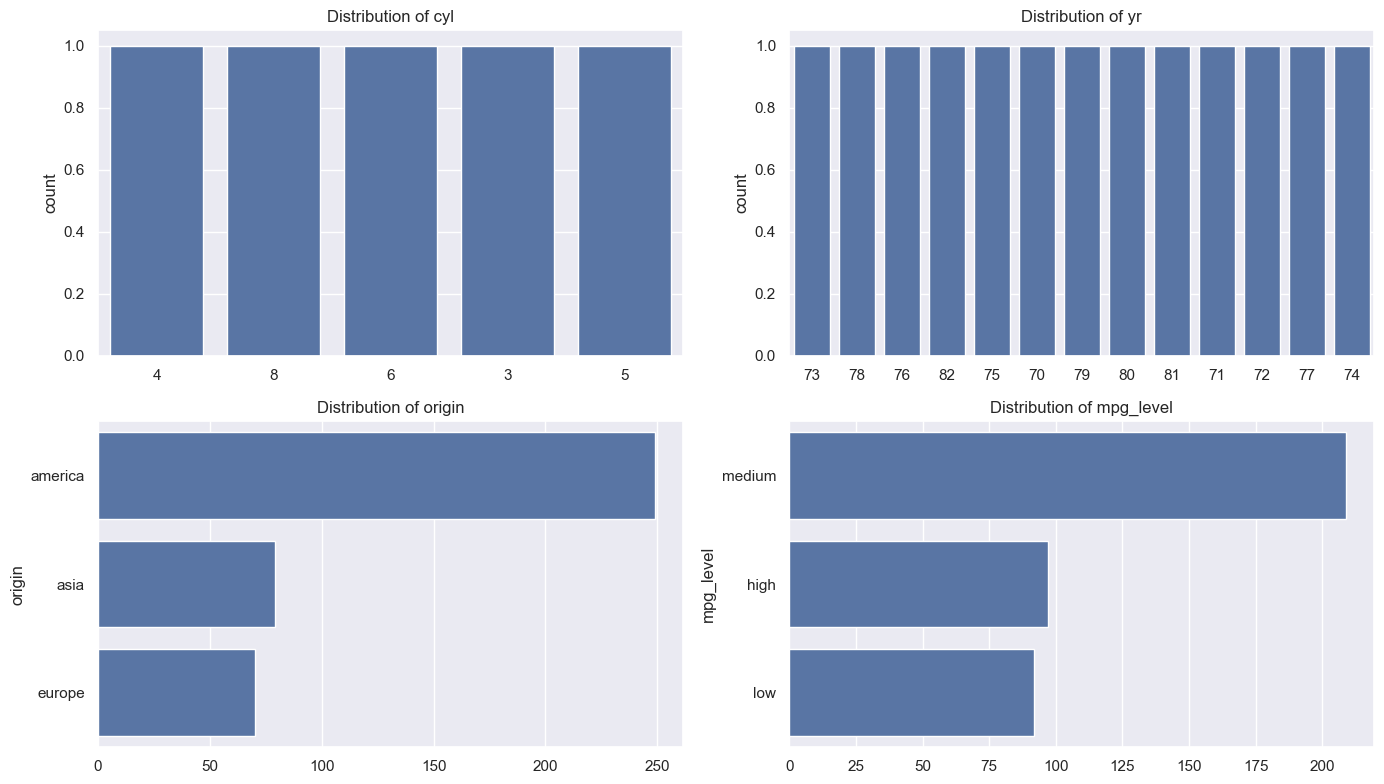

In [16]:
#plotting categorical variables
fig = plt.figure(1, (14, 8))

for i,car in enumerate(car_cat.columns):
    ax = plt.subplot(2,2,i+1)
    sns.countplot(car_cat[car], order=car_cat[car].value_counts().index)
    ax.set_xlabel(None)
    ax.set_title(f'Distribution of {car}')
    plt.tight_layout()

plt.show()

American 4 cylinder cars produced in 1973 with medium mpg level seem to dominate the dateset

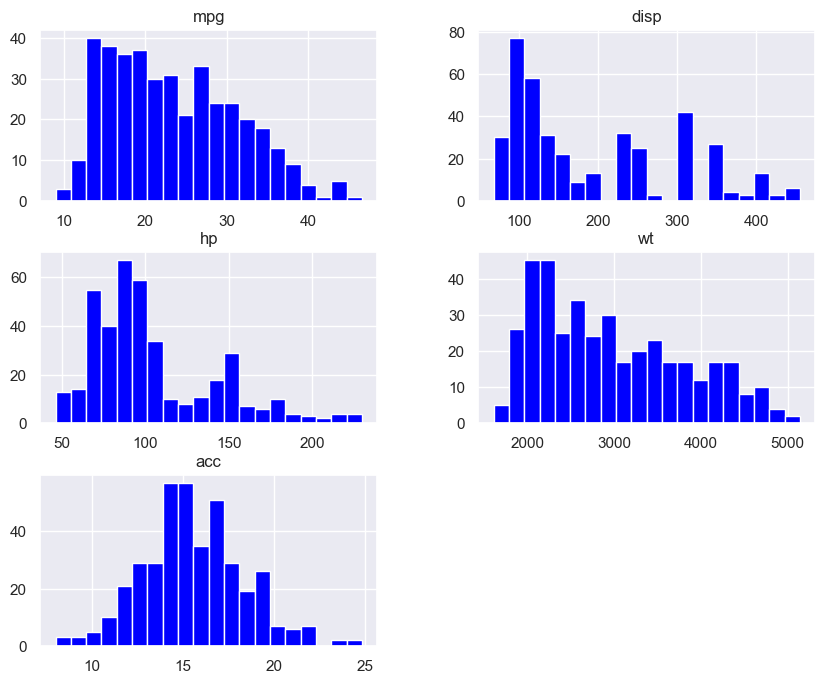

In [18]:
#plot histograms
car_num.hist(bins = 20, figsize = (10, 8), color = 'blue')
plt.show()

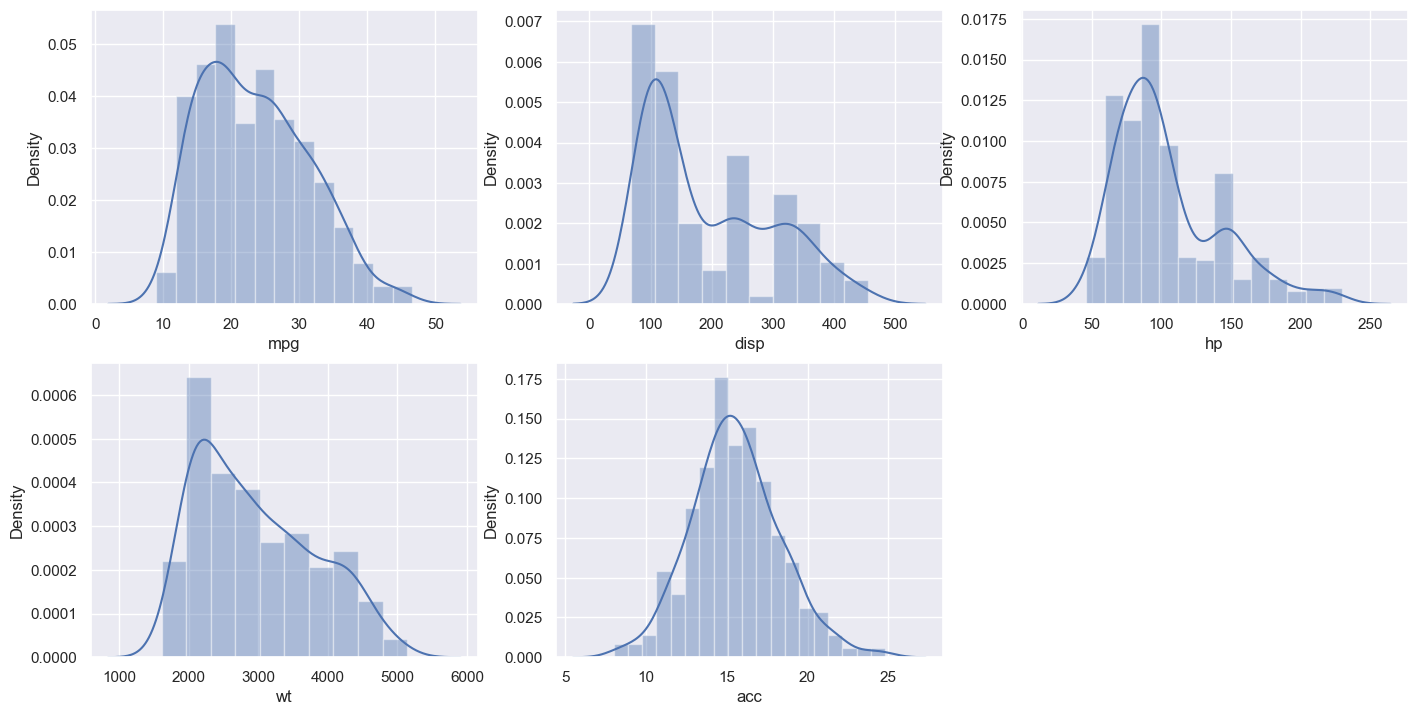

In [19]:
#plot density
plt.figure(figsize=(17, 13))
col = 1
for i in car_num.columns:
    plt.subplot(3, 3, col)
    sns.distplot(car_num[i], color = 'b')
    col += 1 

Displacement and Horsepower seem to be skewed to the right

In [21]:
#joining the categorical and numerical variables
car=pd.concat([car_cat,car_num],axis=1)

In [22]:
#checking for attribute type
car.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   cyl        398 non-null    int64  
 1   yr         398 non-null    int64  
 2   origin     398 non-null    object 
 3   mpg_level  398 non-null    object 
 4   mpg        398 non-null    float64
 5   disp       398 non-null    float64
 6   hp         398 non-null    float64
 7   wt         398 non-null    int64  
 8   acc        398 non-null    float64
dtypes: float64(4), int64(3), object(2)
memory usage: 28.1+ KB


In [23]:
#create dummy varibale for mpg_level and origin and creating a seperate datset for k-means and heirarchical clustering
car = pd.get_dummies(car, columns=['origin'])
car = pd.get_dummies(car, columns=['mpg_level'])
car.head()
carH=car.copy()
carK=car.copy()

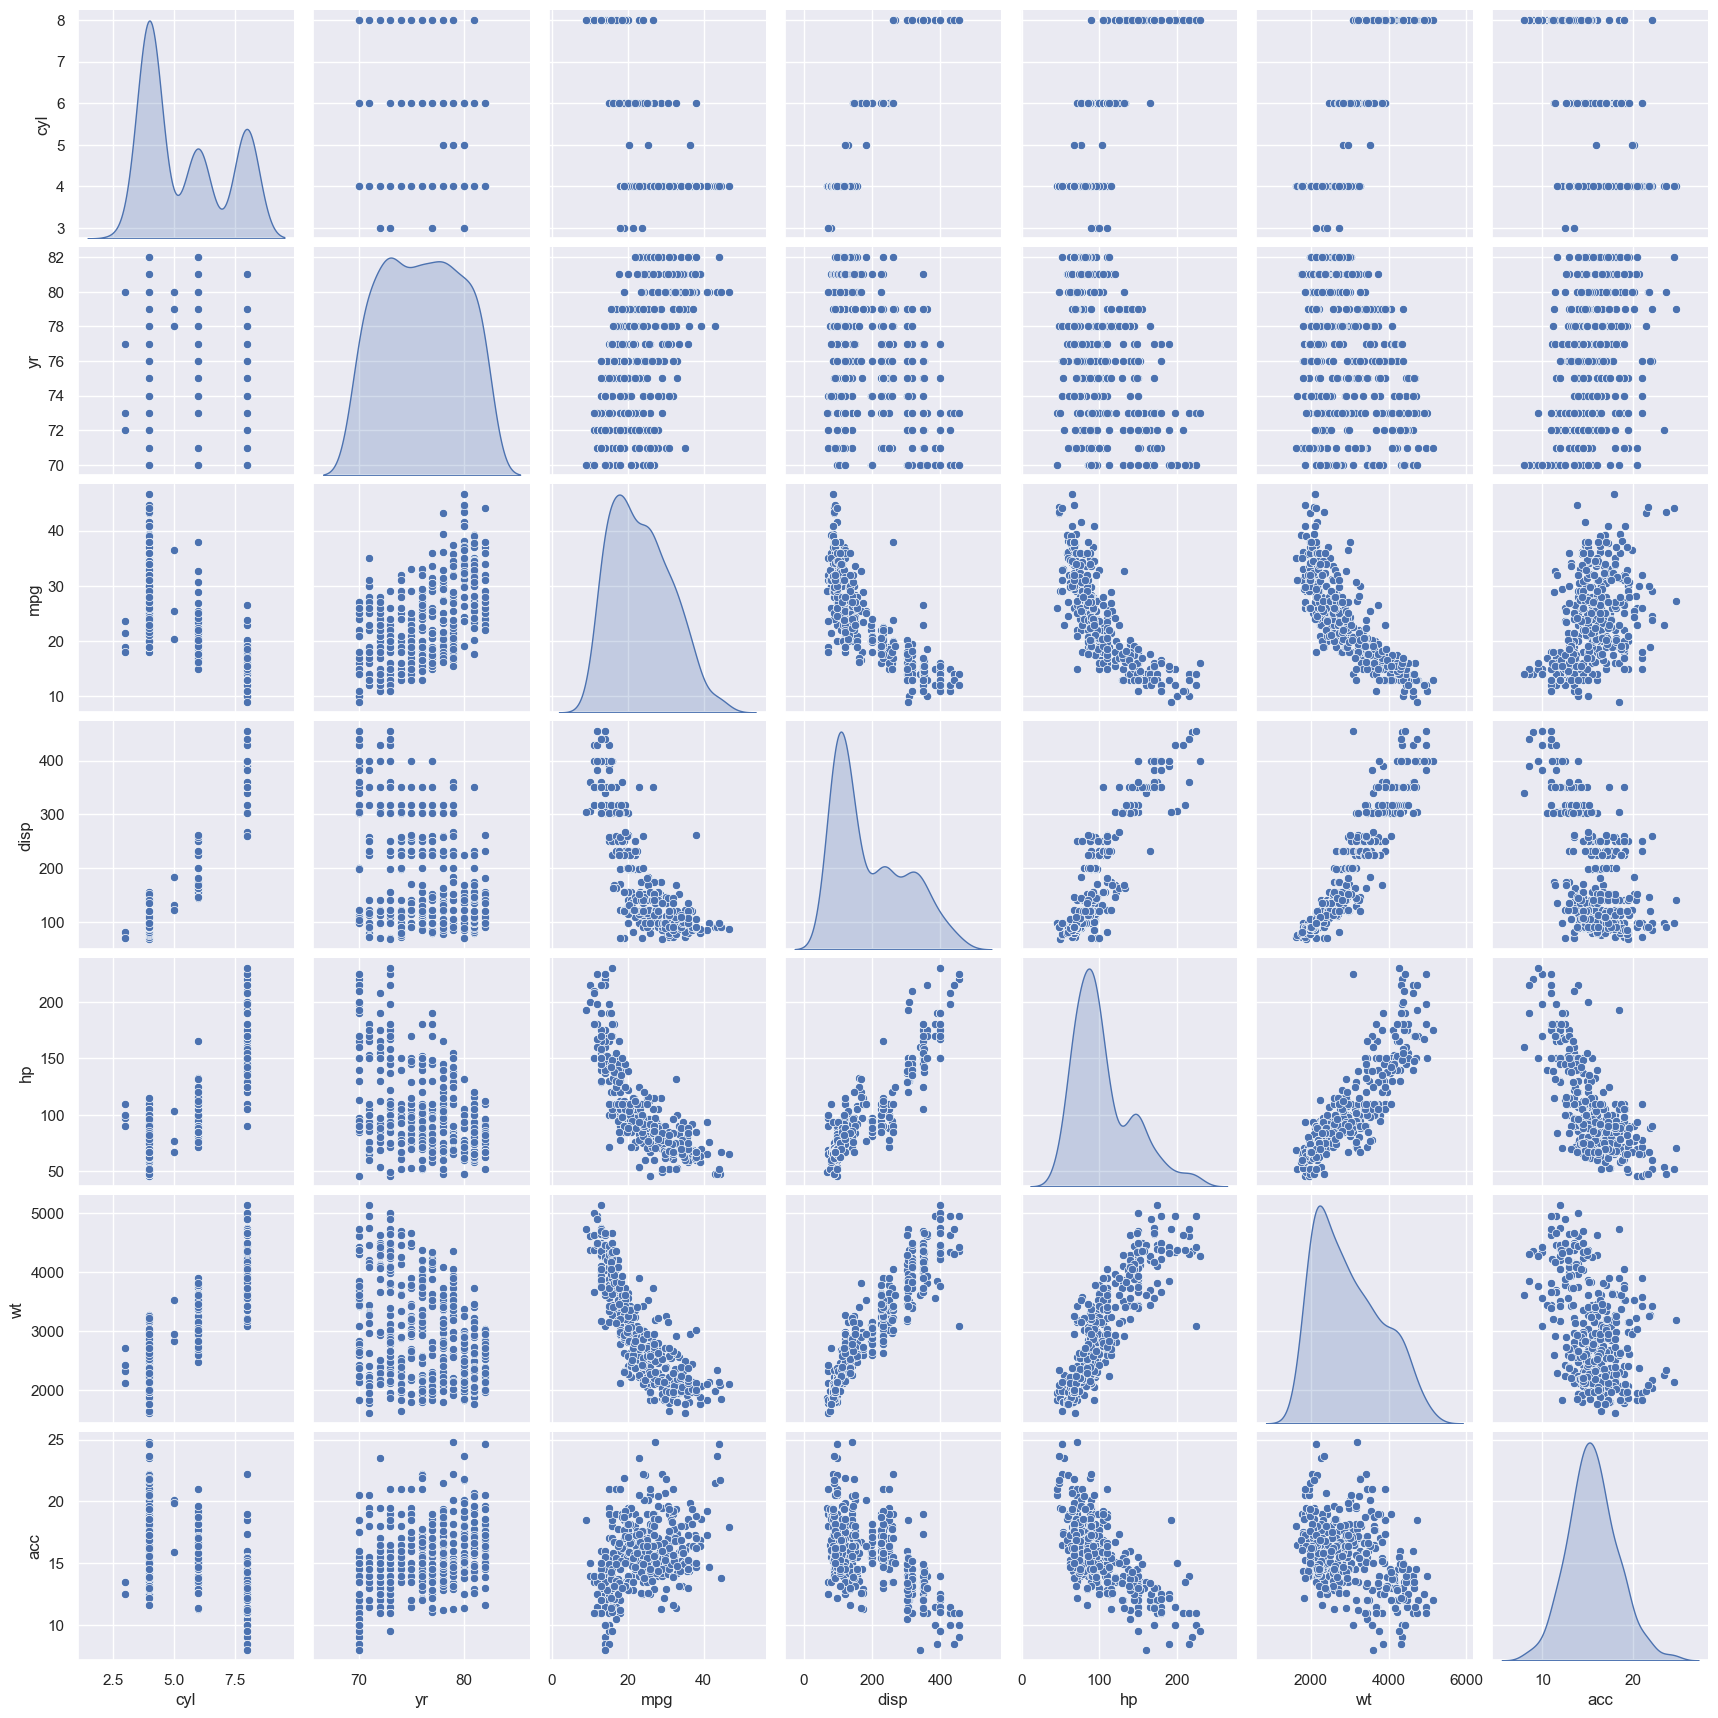

In [24]:
#pair plot for the numeric attributes
car_attr = car.iloc[:, 0:7]
sns.pairplot(car_attr, diag_kind='kde');

There appears to be a linear relationship between the variables

In [26]:
#dropping the created dummy variable
car2=car.drop(['origin_america','origin_asia','origin_europe','mpg_level_high','mpg_level_low','mpg_level_medium'],axis=1)

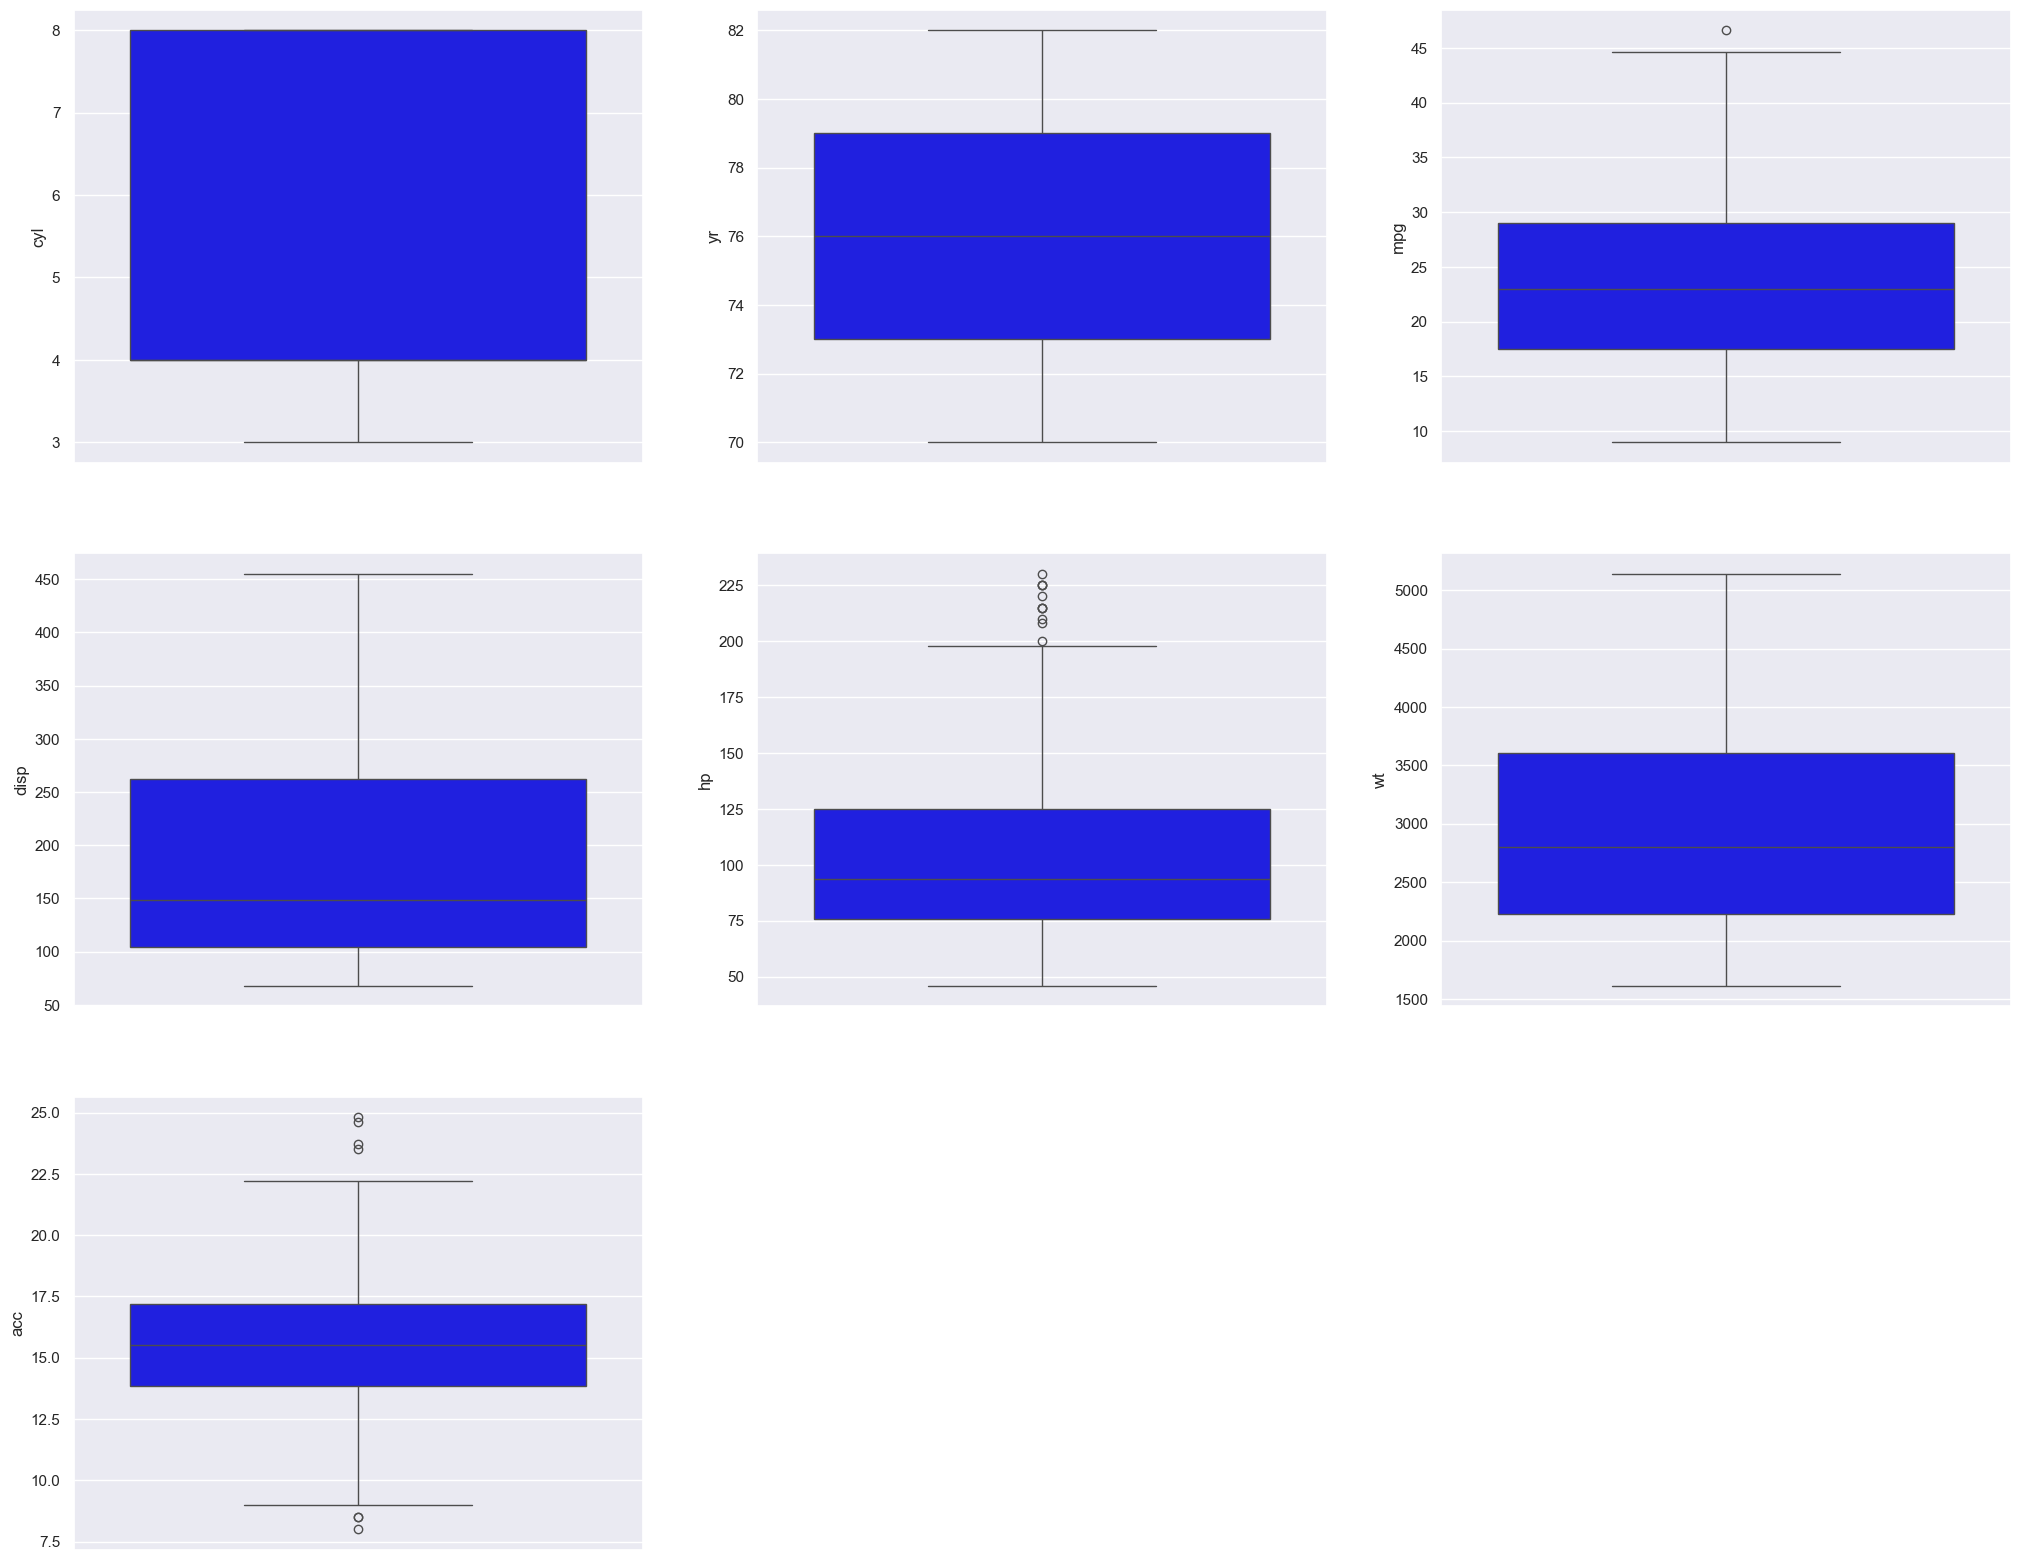

In [27]:
#checking of outliers
plt.figure(figsize=(25, 20))
col = 1
for i in car2.columns:
    plt.subplot(3, 3, col)
    sns.boxplot(car2[i],color='blue')
    col += 1

In [28]:
#replacing outliers with IQR (Q1 and Q3 +-1.5*IQR)
IQR1 = stats.iqr(car2['hp'], interpolation = 'midpoint')
IQR2 = stats.iqr(car2['acc'], interpolation = 'midpoint')

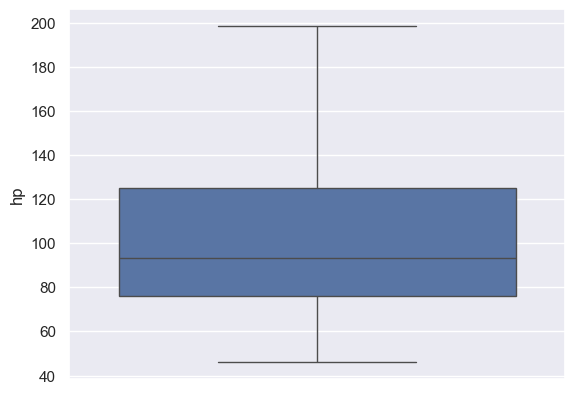

In [29]:
#Horsepower after imputing outliers
Q3 = car2['hp'].quantile(0.75)
car2['hp'] = np.where(car2["hp"] >(Q3+1.5*IQR1), 198.5,car2['hp'])
sns.boxplot(car2['hp']);

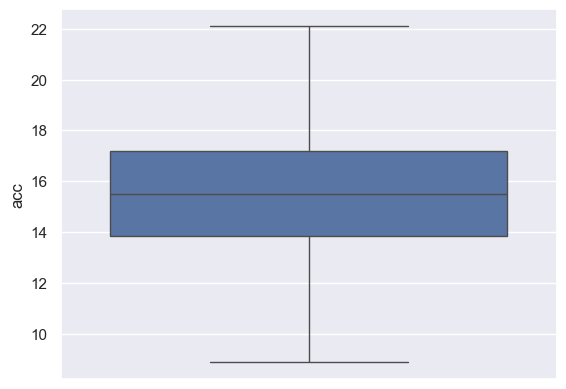

In [30]:
#accelaration after imputing outliers
Q1 = car2['acc'].quantile(0.25)
Q31=car2['acc'].quantile(0.75)
car2['acc'] = np.where(car2["acc"] >(Q31+1.5*IQR2),22.10 ,car2['acc'])
car2['acc'] = np.where(car2["acc"] <(Q1-1.5*IQR2),(Q1-1.5*IQR2),car2['acc'])
sns.boxplot(car2['acc']);

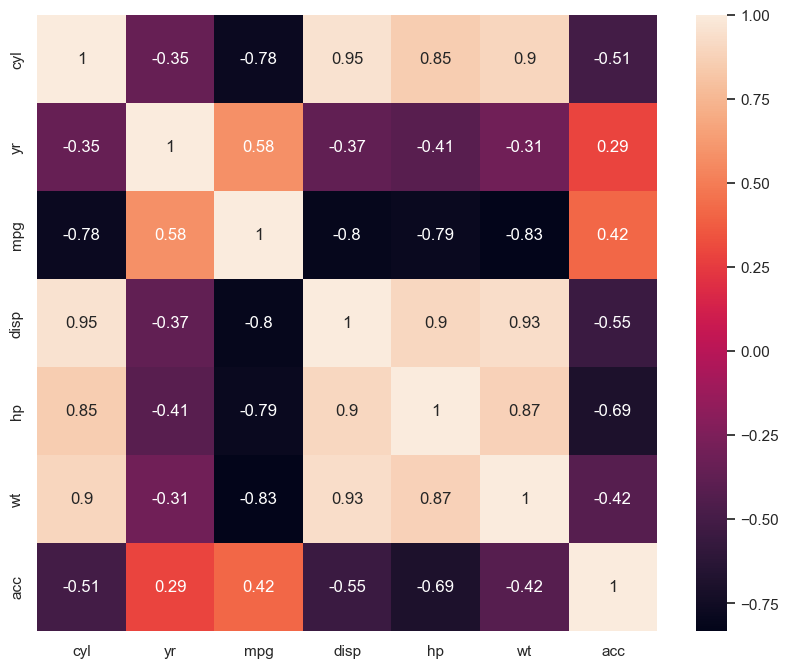

In [31]:
#checking for correlation
plt.figure(figsize=(10,8))
corr=car2.corr()
sns.heatmap(corr,annot=True);

Except Year, most of the variable are correlated with each other

## Heirarchical Clustering

In [34]:
#separating numeric variables
cc = car.iloc[:,0:7] 
cc.head()

cyl  yr   mpg   disp     hp    wt   acc
0    8  70  18.0  307.0  130.0  3504  12.0
1    8  70  15.0  350.0  165.0  3693  11.5
2    8  70  18.0  318.0  150.0  3436  11.0
3    8  70  16.0  304.0  150.0  3433  12.0
4    8  70  17.0  302.0  140.0  3449  10.5

In [35]:
#scaling the variable
cc_z = cc.apply(zscore)
cc_z.head()

cyl        yr       mpg      disp        hp        wt       acc
0  1.498191 -1.627426 -0.706439  1.090604  0.673118  0.630870 -1.295498
1  1.498191 -1.627426 -1.090751  1.503514  1.589958  0.854333 -1.477038
2  1.498191 -1.627426 -0.706439  1.196232  1.197027  0.550470 -1.658577
3  1.498191 -1.627426 -0.962647  1.061796  1.197027  0.546923 -1.295498
4  1.498191 -1.627426 -0.834543  1.042591  0.935072  0.565841 -1.840117

In [36]:
#calculating pairwise distance using average linkage method
link_method = linkage(cc_z.iloc[:,0:7], method = 'average')

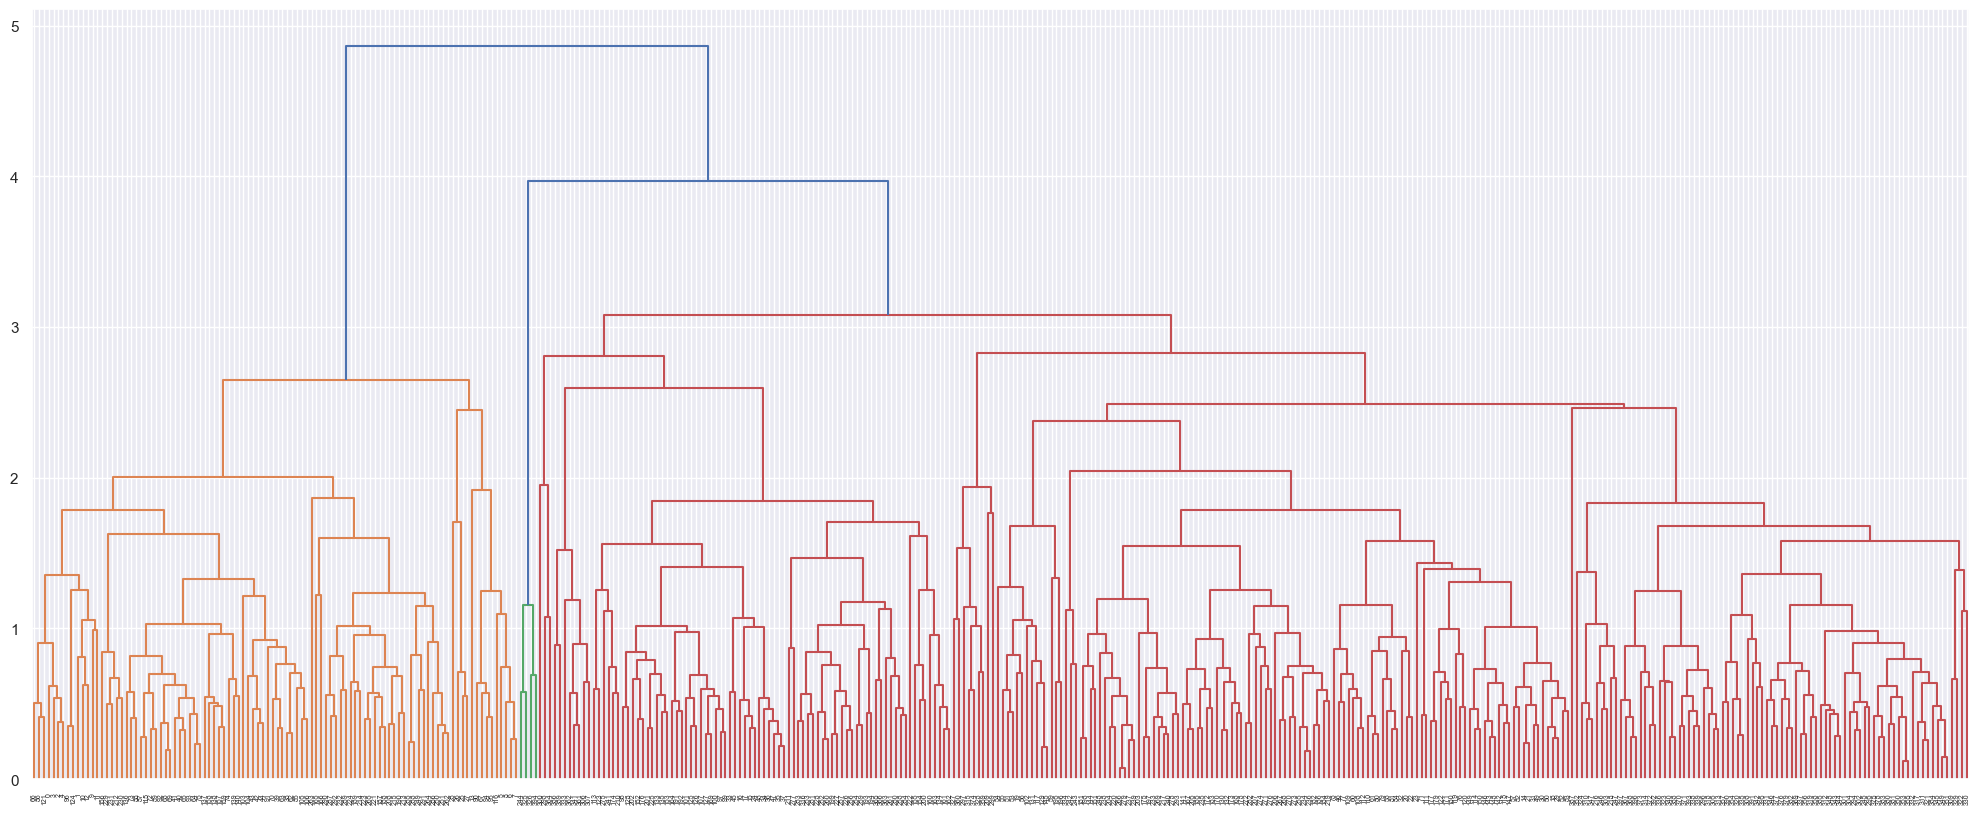

In [37]:
#plotting the H-cluster
plt.figure(figsize=(25, 10))
dendrogram(link_method)
plt.show()

Appers to be to much of a visual clutter, we'll go ahead and cut down the dendrogram to give us 2 clusters/groups

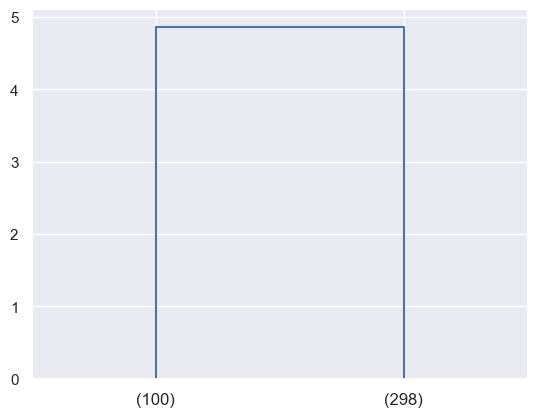

In [39]:
# dendrogram function to arrive at dendrogram
dendrogram(
    link_method,
    truncate_mode='lastp',  
    p=2,  
)
plt.show()

In [40]:
#vieweing the clusters formed
clusters = fcluster(link_method, 2, criterion='maxclust')
clusters

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1,
       1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 1, 2, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,

In [41]:
#attaching the clusters formed to the scales data
cc_z['clusters_H'] = clusters
cc_z.head()

cyl        yr       mpg      disp        hp        wt       acc  \
0  1.498191 -1.627426 -0.706439  1.090604  0.673118  0.630870 -1.295498   
1  1.498191 -1.627426 -1.090751  1.503514  1.589958  0.854333 -1.477038   
2  1.498191 -1.627426 -0.706439  1.196232  1.197027  0.550470 -1.658577   
3  1.498191 -1.627426 -0.962647  1.061796  1.197027  0.546923 -1.295498   
4  1.498191 -1.627426 -0.834543  1.042591  0.935072  0.565841 -1.840117   

   clusters_H  
0           1  
1           1  
2           1  
3           1  
4           1

In [42]:
#vieweing the distribution of clusters
cc_z.clusters_H.value_counts().sort_index()

clusters_H
1    100
2    298
Name: count, dtype: int64

In [43]:
#attaching the clusters formed to the original data
cc['clusters_H']=clusters
carH['clusters_H']=clusters
cc.head()

cyl  yr   mpg   disp     hp    wt   acc  clusters_H
0    8  70  18.0  307.0  130.0  3504  12.0           1
1    8  70  15.0  350.0  165.0  3693  11.5           1
2    8  70  18.0  318.0  150.0  3436  11.0           1
3    8  70  16.0  304.0  150.0  3433  12.0           1
4    8  70  17.0  302.0  140.0  3449  10.5           1

In [44]:
#create a new data set named Hclus
Hclus=cc
Hclus.head()

cyl  yr   mpg   disp     hp    wt   acc  clusters_H
0    8  70  18.0  307.0  130.0  3504  12.0           1
1    8  70  15.0  350.0  165.0  3693  11.5           1
2    8  70  18.0  318.0  150.0  3436  11.0           1
3    8  70  16.0  304.0  150.0  3433  12.0           1
4    8  70  17.0  302.0  140.0  3449  10.5           1

In [45]:
#aggregating the numerical variable with the clusters formed with the mean
aggdata=cc.iloc[:,0:8].groupby('clusters_H').mean()
aggdata['Freq']=cc.clusters_H.value_counts().sort_index()
aggdata

cyl         yr        mpg        disp          hp  \
clusters_H                                                           
1           7.980000  73.740000  14.684000  345.470000  160.400000   
2           4.607383  76.771812  26.477852  142.404362   85.479866   

                     wt        acc  Freq  
clusters_H                                
1           4121.560000  12.702000   100  
2           2584.137584  16.529866   298

Clearly shows two disting group with a difference in average between the clusters and variables

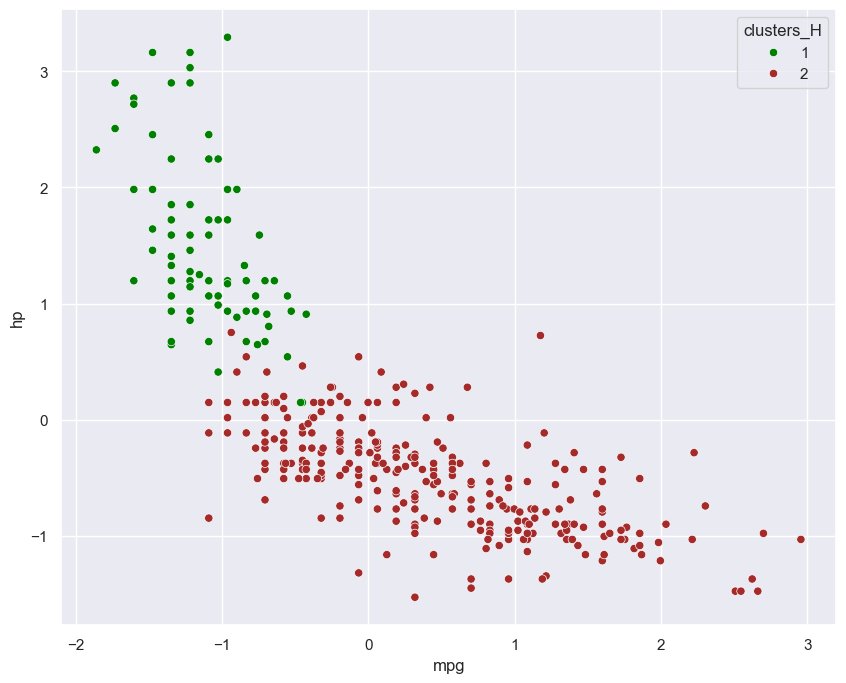

In [47]:
#plotting the clusters formed
plt.figure(figsize=(10, 8))
sns.scatterplot(x="mpg", y="hp", hue="clusters_H",
              data=cc_z, 
                    palette=['green','brown']);

## K-Means Clustering

In [49]:
#seperating the numeric values
cc = car.iloc[:,0:7] 
cc_z1 = cc.apply(zscore)
cc_z1.head()

cyl        yr       mpg      disp        hp        wt       acc
0  1.498191 -1.627426 -0.706439  1.090604  0.673118  0.630870 -1.295498
1  1.498191 -1.627426 -1.090751  1.503514  1.589958  0.854333 -1.477038
2  1.498191 -1.627426 -0.706439  1.196232  1.197027  0.550470 -1.658577
3  1.498191 -1.627426 -0.962647  1.061796  1.197027  0.546923 -1.295498
4  1.498191 -1.627426 -0.834543  1.042591  0.935072  0.565841 -1.840117

In [50]:
#calculatint the within sum of squares
wss =[] 
for i in range(1,5):
    KM = KMeans(n_clusters=i)
    KM.fit(cc_z1)
    wss.append(KM.inertia_)
wss

[2785.9999999999995, 1295.1229352629578, 946.6897366623441, 860.1306442794184]

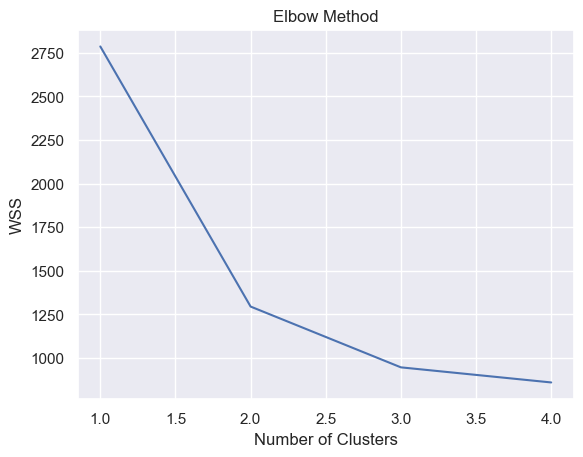

In [51]:
#plotting the WSS against the number of cluster to come up with optimal number of clusters using Elbow-method
plt.plot(range(1,5), wss);
plt.title('Elbow Method');
plt.xlabel("Number of Clusters")
plt.ylabel("WSS");

In [52]:
#using 2 centroids for clustering
k_means = KMeans(n_clusters = 2)
k_means.fit(cc_z1)
labels = k_means.labels_

In [53]:
# Calculating silhouette_score
silhouette_score(cc_z1,labels)

0.47103460587538276

In [54]:
#calculating silhouette score for different centroids
kmeans_kwargs = {
   "init": "random",
   "n_init": 10,
   "max_iter": 300,
   "random_state": 42,
}
silhouette_coefficients = []

 # Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 7):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(cc_z1)
    score = silhouette_score(cc_z1,kmeans.labels_)
    silhouette_coefficients.append(score)

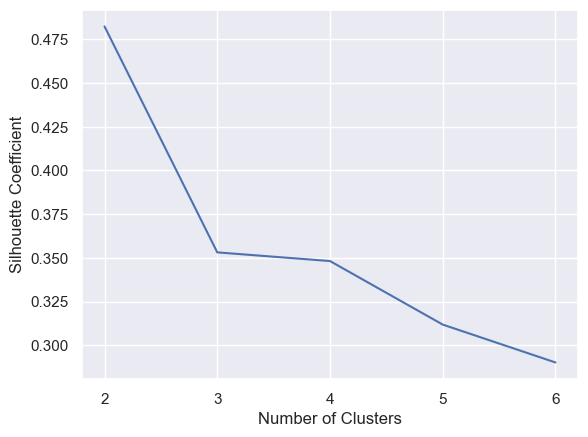

In [55]:
#plotting silhouette score for different centroids
plt.plot(range(2, 7), silhouette_coefficients)
plt.xticks(range(2, 7))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [56]:
#attaching the labels to the datasets
cc["cluster_K"] = labels
carK['cluster_K']=labels
Kclus=cc
Kclus.head()

cyl  yr   mpg   disp     hp    wt   acc  cluster_K
0    8  70  18.0  307.0  130.0  3504  12.0          1
1    8  70  15.0  350.0  165.0  3693  11.5          1
2    8  70  18.0  318.0  150.0  3436  11.0          1
3    8  70  16.0  304.0  150.0  3433  12.0          1
4    8  70  17.0  302.0  140.0  3449  10.5          1

In [57]:
#vieweing the distribution of clusters
cc.cluster_K.value_counts().sort_index()

cluster_K
0    284
1    114
Name: count, dtype: int64

In [58]:
#attaching the clsuters to the scaled data
cc_z1["cluster_K"] = labels
cc_z1.head()

cyl        yr       mpg      disp        hp        wt       acc  \
0  1.498191 -1.627426 -0.706439  1.090604  0.673118  0.630870 -1.295498   
1  1.498191 -1.627426 -1.090751  1.503514  1.589958  0.854333 -1.477038   
2  1.498191 -1.627426 -0.706439  1.196232  1.197027  0.550470 -1.658577   
3  1.498191 -1.627426 -0.962647  1.061796  1.197027  0.546923 -1.295498   
4  1.498191 -1.627426 -0.834543  1.042591  0.935072  0.565841 -1.840117   

   cluster_K  
0          1  
1          1  
2          1  
3          1  
4          1

In [59]:
#aggregating the numerical variable with the clusters formed with the mean
aggdata=cc.iloc[:,0:8].groupby('cluster_K').mean()
aggdata['Freq']=cc.cluster_K.value_counts().sort_index()
aggdata

cyl         yr        mpg        disp          hp  \
cluster_K                                                           
0          4.517606  76.880282  26.888028  136.399648   84.376761   
1          7.789474  73.842105  15.110526  335.491228  153.947368   

                    wt        acc  Freq  
cluster_K                                
0          2535.186620  16.520070   284  
1          4054.701754  13.196491   114

Clearly shows two disting group with a difference in average between the clusters and variables

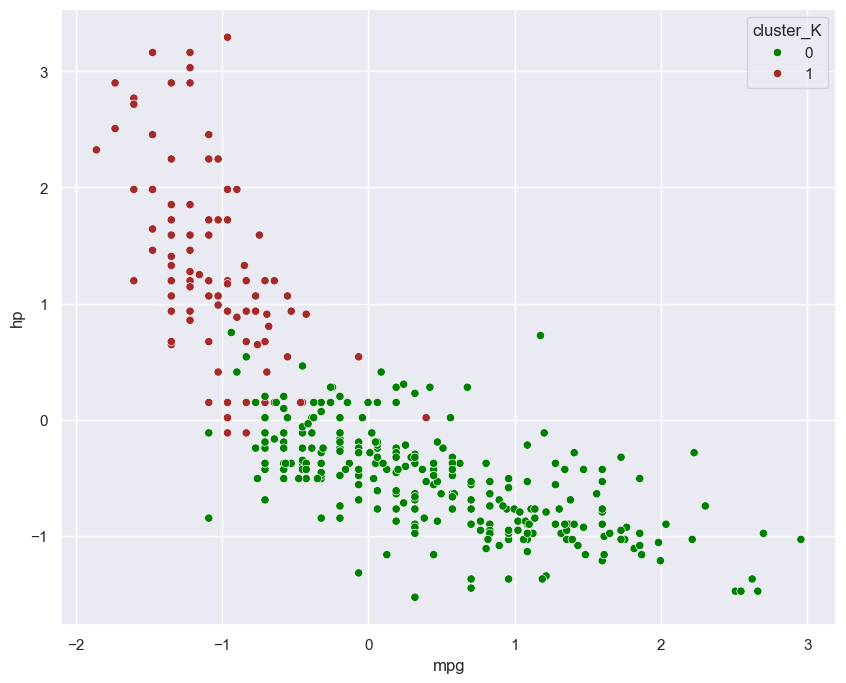

In [61]:
#plotting the clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x="mpg", y="hp", hue="cluster_K",
              data=cc_z1, 
                    palette=['green','brown']);

In [62]:
carH.clusters_H.value_counts().sort_index()

clusters_H
1    100
2    298
Name: count, dtype: int64

In [63]:
carK.cluster_K.value_counts().sort_index()

cluster_K
0    284
1    114
Name: count, dtype: int64

In [64]:
carH.shape

(398, 14)

In [65]:
carK.shape

(398, 14)

In [66]:
car.head()

cyl  yr   mpg   disp     hp    wt   acc  origin_america  origin_asia  \
0    8  70  18.0  307.0  130.0  3504  12.0            True        False   
1    8  70  15.0  350.0  165.0  3693  11.5            True        False   
2    8  70  18.0  318.0  150.0  3436  11.0            True        False   
3    8  70  16.0  304.0  150.0  3433  12.0            True        False   
4    8  70  17.0  302.0  140.0  3449  10.5            True        False   

   origin_europe  mpg_level_high  mpg_level_low  mpg_level_medium  
0          False           False          False              True  
1          False           False           True             False  
2          False           False          False              True  
3          False           False           True             False  
4          False           False          False              True

## Linear regression on the original dataset

In [68]:
X = car.drop(['mpg','origin_europe','mpg_level_low'], axis=1)
# the dependent variable
y = car[['mpg']]

In [69]:
# Split X and y into training and test set in 70:30 ratio

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=15)

In [70]:
regression_model = LinearRegression()
regression_model.fit(X_train, y_train)

LinearRegression()

In [71]:
for idx, col_name in enumerate(X_train.columns):
    print("The coefficient for {} is {}".format(col_name, regression_model.coef_[0][idx]))

The coefficient for cyl is -0.5134441386218942
The coefficient for yr is 0.4434650429116826
The coefficient for disp is 0.010688858394647022
The coefficient for hp is 0.010315514536314001
The coefficient for wt is -0.004538788568737156
The coefficient for acc is 0.19183425608862748
The coefficient for origin_america is -1.730620951368901
The coefficient for origin_asia is -0.8976724344009424
The coefficient for mpg_level_high is 8.552374663817027
The coefficient for mpg_level_medium is 1.5941218694850465


In [72]:
intercept = regression_model.intercept_[0]
print("The intercept for our model is {}".format(intercept))

The intercept for our model is -1.6635717568650108


In [73]:
regression_model.score(X_train, y_train)

0.8967703023839787

In [74]:
O=regression_model.score(X_test, y_test)
O

0.9037421476349177

## Linear regression on data with K means cluster

In [76]:
#renaming the cluster labels to light and heavy vehicles and creating dummy variables of it
carK['cluster_K']=carK['cluster_K'].astype('category')
carK['cluster_K'] = carK['cluster_K'].replace({1: 'heavy', 0: 'light'})
carK = pd.get_dummies(carK, columns=['cluster_K'])

In [77]:
carK.head()

cyl  yr   mpg   disp     hp    wt   acc  origin_america  origin_asia  \
0    8  70  18.0  307.0  130.0  3504  12.0            True        False   
1    8  70  15.0  350.0  165.0  3693  11.5            True        False   
2    8  70  18.0  318.0  150.0  3436  11.0            True        False   
3    8  70  16.0  304.0  150.0  3433  12.0            True        False   
4    8  70  17.0  302.0  140.0  3449  10.5            True        False   

   origin_europe  mpg_level_high  mpg_level_low  mpg_level_medium  \
0          False           False          False              True   
1          False           False           True             False   
2          False           False          False              True   
3          False           False           True             False   
4          False           False          False              True   

   cluster_K_light  cluster_K_heavy  
0            False             True  
1            False             True  
2            False             True  
3            False             True  
4            False             True

In [78]:
X = carK.drop(['mpg','origin_europe','mpg_level_low','cluster_K_light'], axis=1)
# the dependent variable
y = carK[['mpg']]

In [79]:
# Split X and y into training and test set in 70:30 ratio

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=12)

In [80]:
regression_model = LinearRegression()
regression_model.fit(X_train, y_train)

LinearRegression()

In [81]:
for idx, col_name in enumerate(X_train.columns):
    print("The coefficient for {} is {}".format(col_name, regression_model.coef_[0][idx]))

The coefficient for cyl is -1.1056941994982277
The coefficient for yr is 0.4339459863179707
The coefficient for disp is 0.015617908136385398
The coefficient for hp is -0.004648077923869638
The coefficient for wt is -0.004165990711405862
The coefficient for acc is 0.17611102477002552
The coefficient for origin_america is -1.7181422780471207
The coefficient for origin_asia is -0.8022319844268572
The coefficient for mpg_level_high is 9.516765385840001
The coefficient for mpg_level_medium is 2.4247277691131686
The coefficient for cluster_K_heavy is 2.371853567046815


In [82]:
intercept = regression_model.intercept_[0]
print("The intercept for our model is {}".format(intercept))

The intercept for our model is 0.6517519261765763


In [83]:
regression_model.score(X_train, y_train)

0.8941259124880583

In [84]:
K=regression_model.score(X_test, y_test)
K

0.9092616138629951

## Linear regression on data with H-clusters

In [86]:
#renaming the cluster labels to light and heavy vehicles and creating summy variable of it
carH['clusters_H']=carH['clusters_H'].astype('category')
carH['clusters_H'] = carH['clusters_H'].replace({1: 'heavy', 2: 'light'})
carH = pd.get_dummies(carH, columns=['clusters_H'])

In [87]:
X = carH.drop(['mpg','origin_europe','mpg_level_low','clusters_H_light'], axis=1)
# the dependent variable
y = carH[['mpg']]

In [88]:
# Split X and y into training and test set in 70:30 ratio

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=10)

In [89]:
regression_model = LinearRegression()
regression_model.fit(X_train, y_train)

LinearRegression()

In [90]:
for idx, col_name in enumerate(X_train.columns):
    print("The coefficient for {} is {}".format(col_name, regression_model.coef_[0][idx]))

The coefficient for cyl is -1.010483243257533
The coefficient for yr is 0.44754173575501577
The coefficient for disp is 0.015115200524614462
The coefficient for hp is -0.013301584387234106
The coefficient for wt is -0.004264179780672567
The coefficient for acc is 0.11805139164484851
The coefficient for origin_america is -2.117456931539113
The coefficient for origin_asia is -1.3974915348558086
The coefficient for mpg_level_high is 8.56594823929828
The coefficient for mpg_level_medium is 1.6577250698582782
The coefficient for clusters_H_heavy is 2.038974468807406


In [91]:
intercept = regression_model.intercept_[0]
print("The intercept for our model is {}".format(intercept))

The intercept for our model is 2.572729318232568


In [92]:
regression_model.score(X_train, y_train)

0.8988409890950728

In [93]:
H=regression_model.score(X_test, y_test)
H

0.901023837384672

In [94]:
modellists = []
modellists.append(['Linear Regression on Original Data set', O*100])
modellists.append(['Linear Regression with K means clusters', K*100])
modellists.append(['Linear Regression with Heirarchical clusters', H*100])
mdl_df = pd.DataFrame(modellists, columns = ['Model','r^2 on Test'])
mdl_df

Model  r^2 on Test
0        Linear Regression on Original Data set    90.374215
1       Linear Regression with K means clusters    90.926161
2  Linear Regression with Heirarchical clusters    90.102384

## Summary
K-means appears to explain the highest variation in the datset, but with a difference of only 1% when compared with other models, to get more clarity a larger dataset may be used, since this is a dataset of used cars it doesn't give us how many previous owners has the cars seen which might be helful variable,the gender of the previous owners, the reason/purpose that the cars were being used is also an important factor which the dataset doen't capture. With the above mentioned features it may be possible to get a higher accuracy or explainability of the models and its variables.

## Part-2 

## DOMAIN: 
Manufacturing
### CONTEXT:
Company X curates and packages wine across various vineyards spread throughout the country.
### DATA DESCRIPTION:
The data concerns the chemical composition of the wine and its respective quality.
### Attribute Information:
1. A, B, C, D: specific chemical composition measure of the wine 
2. Quality: quality of wine [ Low and High ] 

### PROJECT OBJECTIVE:
Goal is to build a synthetic data generation model using the existing data provided by the company.

In [97]:
#Loading the required packages
import numpy as np   
import pandas as pd    
import matplotlib.pyplot as plt 
from scipy.stats import zscore
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
import seaborn as sns
%matplotlib inline 
sns.set(color_codes=True)
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split

In [98]:
#importing the data
wi=pd.ExcelFile('./Part2 - Company.xlsx',engine='openpyxl')
wi.sheet_names
wi = wi.parse("Sheet1")
wi.head()

A    B    C    D    Quality
0   47   27   45  108  Quality A
1  174  133  134  166  Quality B
2  159  163  135  131        NaN
3   61   23    3   44  Quality A
4   59   60    9   68  Quality A

In [99]:
row, column = wi.shape
print('The dataset contains', row, 'rows and', column, 'columns')

The dataset contains 61 rows and 5 columns


In [100]:
#make a copy of the data
wi1=wi.copy()

In [101]:
#dropping the target variable
wi=wi.drop('Quality',axis=1)

In [102]:
#checking for data types
print('The data type of each attribute: \n')
wi1.info()

The data type of each attribute: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   A        61 non-null     int64 
 1   B        61 non-null     int64 
 2   C        61 non-null     int64 
 3   D        61 non-null     int64 
 4   Quality  43 non-null     object
dtypes: int64(4), object(1)
memory usage: 2.5+ KB


In [103]:
print('The Target Variable has set 18 missing values \n')
wi1.isnull().sum()

The Target Variable has set 18 missing values 



A           0
B           0
C           0
D           0
Quality    18
dtype: int64

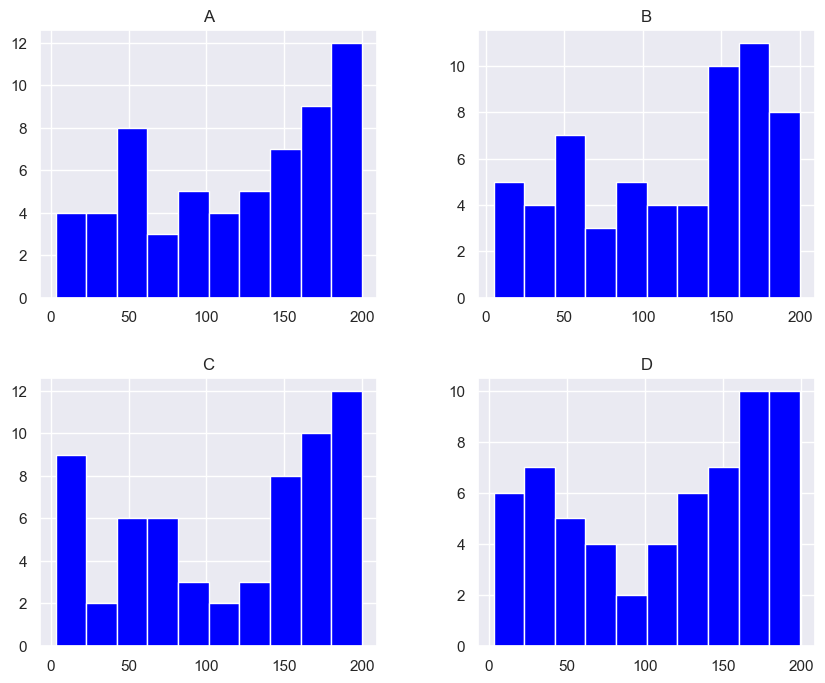

In [104]:
#checking the distribution of the data points
wi.hist(bins = 10, figsize = (10, 8), color = 'blue')
plt.show()

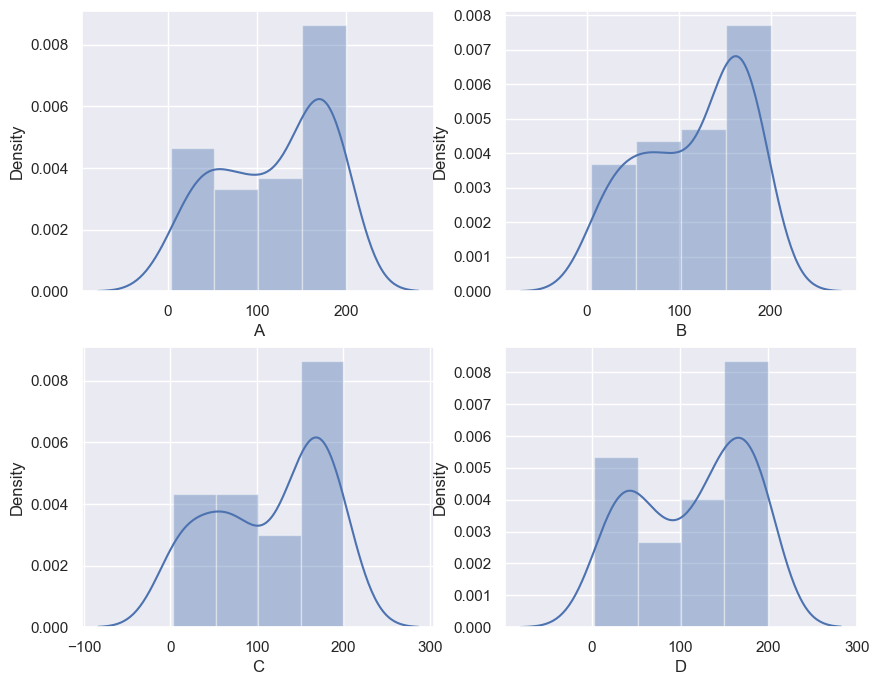

In [105]:
#checking for the density of the variable
plt.figure(figsize=(10, 8))
col = 1
for i in wi.columns:
    plt.subplot(2, 2, col)
    sns.distplot(wi[i], color = 'b')
    col += 1 

the chemical compositions are on the same scales between 0 to 200

In [107]:
#scaling the numeric variables
w1 = wi.apply(zscore)
w1.head()

A         B         C         D
0 -1.168034 -1.561080 -1.061569 -0.103138
1  0.904992  0.284923  0.306077  0.823013
2  0.660147  0.807376  0.321443  0.264129
3 -0.939512 -1.630740 -1.706975 -1.125099
4 -0.972158 -0.986381 -1.614775 -0.741864

In [108]:
#checking for the distribution of the targrt variables
wi1['Quality'].value_counts()

Quality
Quality A    26
Quality B    17
Name: count, dtype: int64

In [109]:
#applying kmeans with 2 centroids
k_means = KMeans(n_clusters = 2)
k_means.fit(w1)
labels = k_means.labels_

In [110]:
# Calculating silhouette_score
silhouette_score(w1,labels)

0.6891674125195145

In [111]:
#attaching the cluster labels to the original dataset
wi1["Quality_k"] = labels

In [112]:
#checking for the first 15 observations
wi1.head(15)

A    B    C    D    Quality  Quality_k
0    47   27   45  108  Quality A          1
1   174  133  134  166  Quality B          0
2   159  163  135  131        NaN          0
3    61   23    3   44  Quality A          1
4    59   60    9   68  Quality A          1
5   153  140  154  199        NaN          0
6    34   28   78   22  Quality A          1
7   191  144  143  154        NaN          0
8   160  181  194  178  Quality B          0
9   145  178  158  141        NaN          0
10   76   94  107   37  Quality A          1
11  138  200  153  192  Quality B          0
12   27  106   57   37  Quality A          1
13   45   76   56   57  Quality A          1
14  186  142  146  174        NaN          0

In [113]:
#renaming the cluster labels
wi1['Quality_k'] = wi1['Quality_k'].replace({0: 'Quality A', 1: 'Quality B'})

In [114]:
#checking for datatypes
wi1.dtypes

A             int64
B             int64
C             int64
D             int64
Quality      object
Quality_k    object
dtype: object

In [115]:
#dropping na rows
wn=wi1.dropna()

In [116]:
#checking for the shape
wn.shape

(43, 6)

In [117]:
#using the cluster labels and actual target labels to check for accuracy
pred = wn['Quality_k']
actual=wn['Quality']

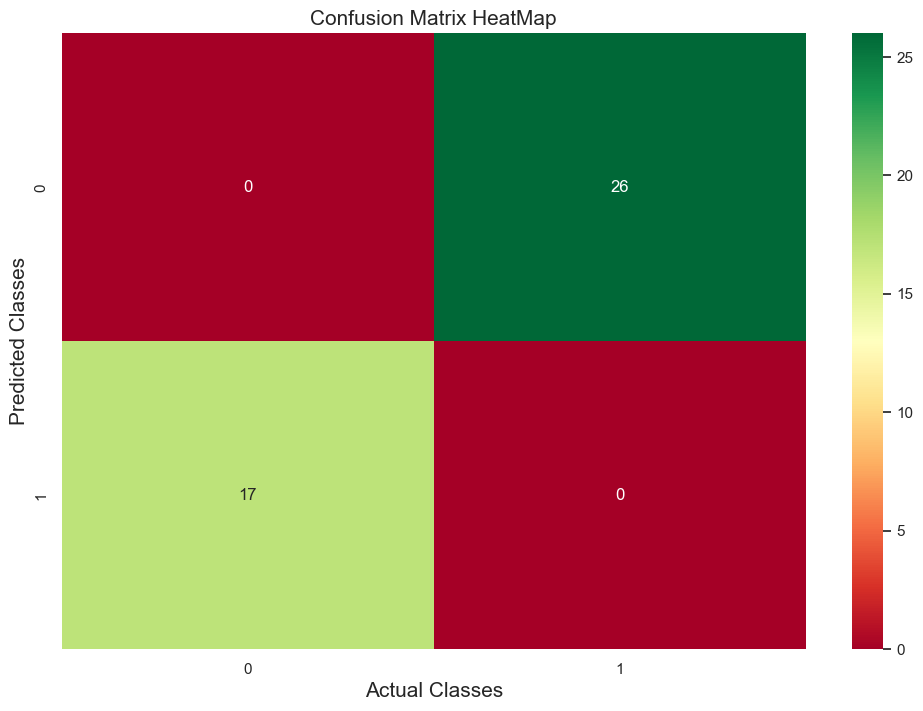

In [118]:
#visualization of confusion matrix in the form of a heatmap
cm= confusion_matrix(actual, pred)
plt.figure(figsize = (12, 8))
sns.heatmap(cm, annot = True, cmap = 'RdYlGn', fmt = 'd')
plt.xlabel('Actual Classes', fontsize = 15)
plt.ylabel('Predicted Classes', fontsize = 15)
plt.title('Confusion Matrix HeatMap', fontsize = 15);

There appears to be no misclassification when checking the it with the non missing target variables and the predicted clusters,
Hence the new labels can be used as a target variable

## Part-3

### DOMAIN:
Automobile
### CONTEXT: 
The purpose is to classify a given silhouette as one of three types of vehicle, using a set of features extracted from the silhouette.The vehicle may be viewed from one of many different angles.
### DATA DESCRIPTION: 
The data contains features extracted from the silhouette of vehicles in different angles. Four "Corgie" model vehicles
were used for the experiment: a double decker bus, Cheverolet van, Saab 9000 and an Opel Manta 400 cars. This particular combination of vehicles was chosen with the expectation that the bus, van and either one of the cars would be readily distinguishable, but it would be more difficult to distinguish between the cars.<br/>
All the features are numeric i.e. geometric features extracted from the silhouette.
### PROJECT OBJECTIVE: 
Apply dimensionality reduction technique – PCA and train a model using principal components instead of training the
model using just the raw data.

In [121]:
#Loading the required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from sklearn import metrics
%matplotlib inline
sns.set(color_codes=True)
import warnings
warnings.filterwarnings('ignore')

## EDA

In [123]:
#import the dataset
ve = pd.read_csv('./Part3 - vehicle.csv')
ve.head()

compactness  circularity  distance_circularity  radius_ratio  \
0           95         48.0                  83.0         178.0   
1           91         41.0                  84.0         141.0   
2          104         50.0                 106.0         209.0   
3           93         41.0                  82.0         159.0   
4           85         44.0                  70.0         205.0   

   pr.axis_aspect_ratio  max.length_aspect_ratio  scatter_ratio  \
0                  72.0                       10          162.0   
1                  57.0                        9          149.0   
2                  66.0                       10          207.0   
3                  63.0                        9          144.0   
4                 103.0                       52          149.0   

   elongatedness  pr.axis_rectangularity  max.length_rectangularity  \
0           42.0                    20.0                        159   
1           45.0                    19.0                        143   
2           32.0                    23.0                        158   
3           46.0                    19.0                        143   
4           45.0                    19.0                        144   

   scaled_variance  scaled_variance.1  scaled_radius_of_gyration  \
0            176.0              379.0                      184.0   
1            170.0              330.0                      158.0   
2            223.0              635.0                      220.0   
3            160.0              309.0                      127.0   
4            241.0              325.0                      188.0   

   scaled_radius_of_gyration.1  skewness_about  skewness_about.1  \
0                         70.0             6.0              16.0   
1                         72.0             9.0              14.0   
2                         73.0            14.0               9.0   
3                         63.0             6.0              10.0   
4                        127.0             9.0              11.0   

   skewness_about.2  hollows_ratio class  
0             187.0            197   van  
1             189.0            199   van  
2             188.0            196   car  
3             199.0            207   van  
4             180.0            183   bus

In [124]:
#checking for the dimension of the data
rows, column = ve.shape
print('The dataset contains', rows, 'rows and', column, 'columns.')

The dataset contains 846 rows and 19 columns.


In [125]:
#checking for the data type
print('The data type of each attribute: \n')
ve.info()

The data type of each attribute: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 846 entries, 0 to 845
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   compactness                  846 non-null    int64  
 1   circularity                  841 non-null    float64
 2   distance_circularity         842 non-null    float64
 3   radius_ratio                 840 non-null    float64
 4   pr.axis_aspect_ratio         844 non-null    float64
 5   max.length_aspect_ratio      846 non-null    int64  
 6   scatter_ratio                845 non-null    float64
 7   elongatedness                845 non-null    float64
 8   pr.axis_rectangularity       843 non-null    float64
 9   max.length_rectangularity    846 non-null    int64  
 10  scaled_variance              843 non-null    float64
 11  scaled_variance.1            844 non-null    float64
 12  scaled_radius_of_gyration    844 non-null  

In [126]:
print('Duplicated rows: ', ve[ve.duplicated()].shape[0])

Duplicated rows:  0


In [127]:
print('Null values:\n', ve.isnull().sum())

Null values:
 compactness                    0
circularity                    5
distance_circularity           4
radius_ratio                   6
pr.axis_aspect_ratio           2
max.length_aspect_ratio        0
scatter_ratio                  1
elongatedness                  1
pr.axis_rectangularity         3
max.length_rectangularity      0
scaled_variance                3
scaled_variance.1              2
scaled_radius_of_gyration      2
scaled_radius_of_gyration.1    4
skewness_about                 6
skewness_about.1               1
skewness_about.2               1
hollows_ratio                  0
class                          0
dtype: int64


There appears to be quite a few missing values

In [129]:
#replacing the missing values with median values
for cols in ve.columns:
    if(cols != 'class'): 
        ve[cols] = ve[cols].fillna(ve[cols].median())

In [130]:
#5-point summary
ve.describe().T

count        mean         std    min     25%  \
compactness                  846.0   93.678487    8.234474   73.0   87.00   
circularity                  846.0   44.823877    6.134272   33.0   40.00   
distance_circularity         846.0   82.100473   15.741569   40.0   70.00   
radius_ratio                 846.0  168.874704   33.401356  104.0  141.00   
pr.axis_aspect_ratio         846.0   61.677305    7.882188   47.0   57.00   
max.length_aspect_ratio      846.0    8.567376    4.601217    2.0    7.00   
scatter_ratio                846.0  168.887707   33.197710  112.0  147.00   
elongatedness                846.0   40.936170    7.811882   26.0   33.00   
pr.axis_rectangularity       846.0   20.580378    2.588558   17.0   19.00   
max.length_rectangularity    846.0  147.998818   14.515652  118.0  137.00   
scaled_variance              846.0  188.596927   31.360427  130.0  167.00   
scaled_variance.1            846.0  439.314421  176.496341  184.0  318.25   
scaled_radius_of_gyration    846.0  174.706856   32.546277  109.0  149.00   
scaled_radius_of_gyration.1  846.0   72.443262    7.468734   59.0   67.00   
skewness_about               846.0    6.361702    4.903244    0.0    2.00   
skewness_about.1             846.0   12.600473    8.930962    0.0    5.00   
skewness_about.2             846.0  188.918440    6.152247  176.0  184.00   
hollows_ratio                846.0  195.632388    7.438797  181.0  190.25   

                               50%     75%     max  
compactness                   93.0  100.00   119.0  
circularity                   44.0   49.00    59.0  
distance_circularity          80.0   98.00   112.0  
radius_ratio                 167.0  195.00   333.0  
pr.axis_aspect_ratio          61.0   65.00   138.0  
max.length_aspect_ratio        8.0   10.00    55.0  
scatter_ratio                157.0  198.00   265.0  
elongatedness                 43.0   46.00    61.0  
pr.axis_rectangularity        20.0   23.00    29.0  
max.length_rectangularity    146.0  159.00   188.0  
scaled_variance              179.0  217.00   320.0  
scaled_variance.1            363.5  586.75  1018.0  
scaled_radius_of_gyration    173.5  198.00   268.0  
scaled_radius_of_gyration.1   71.5   75.00   135.0  
skewness_about                 6.0    9.00    22.0  
skewness_about.1              11.0   19.00    41.0  
skewness_about.2             188.0  193.00   206.0  
hollows_ratio                197.0  201.00   211.0

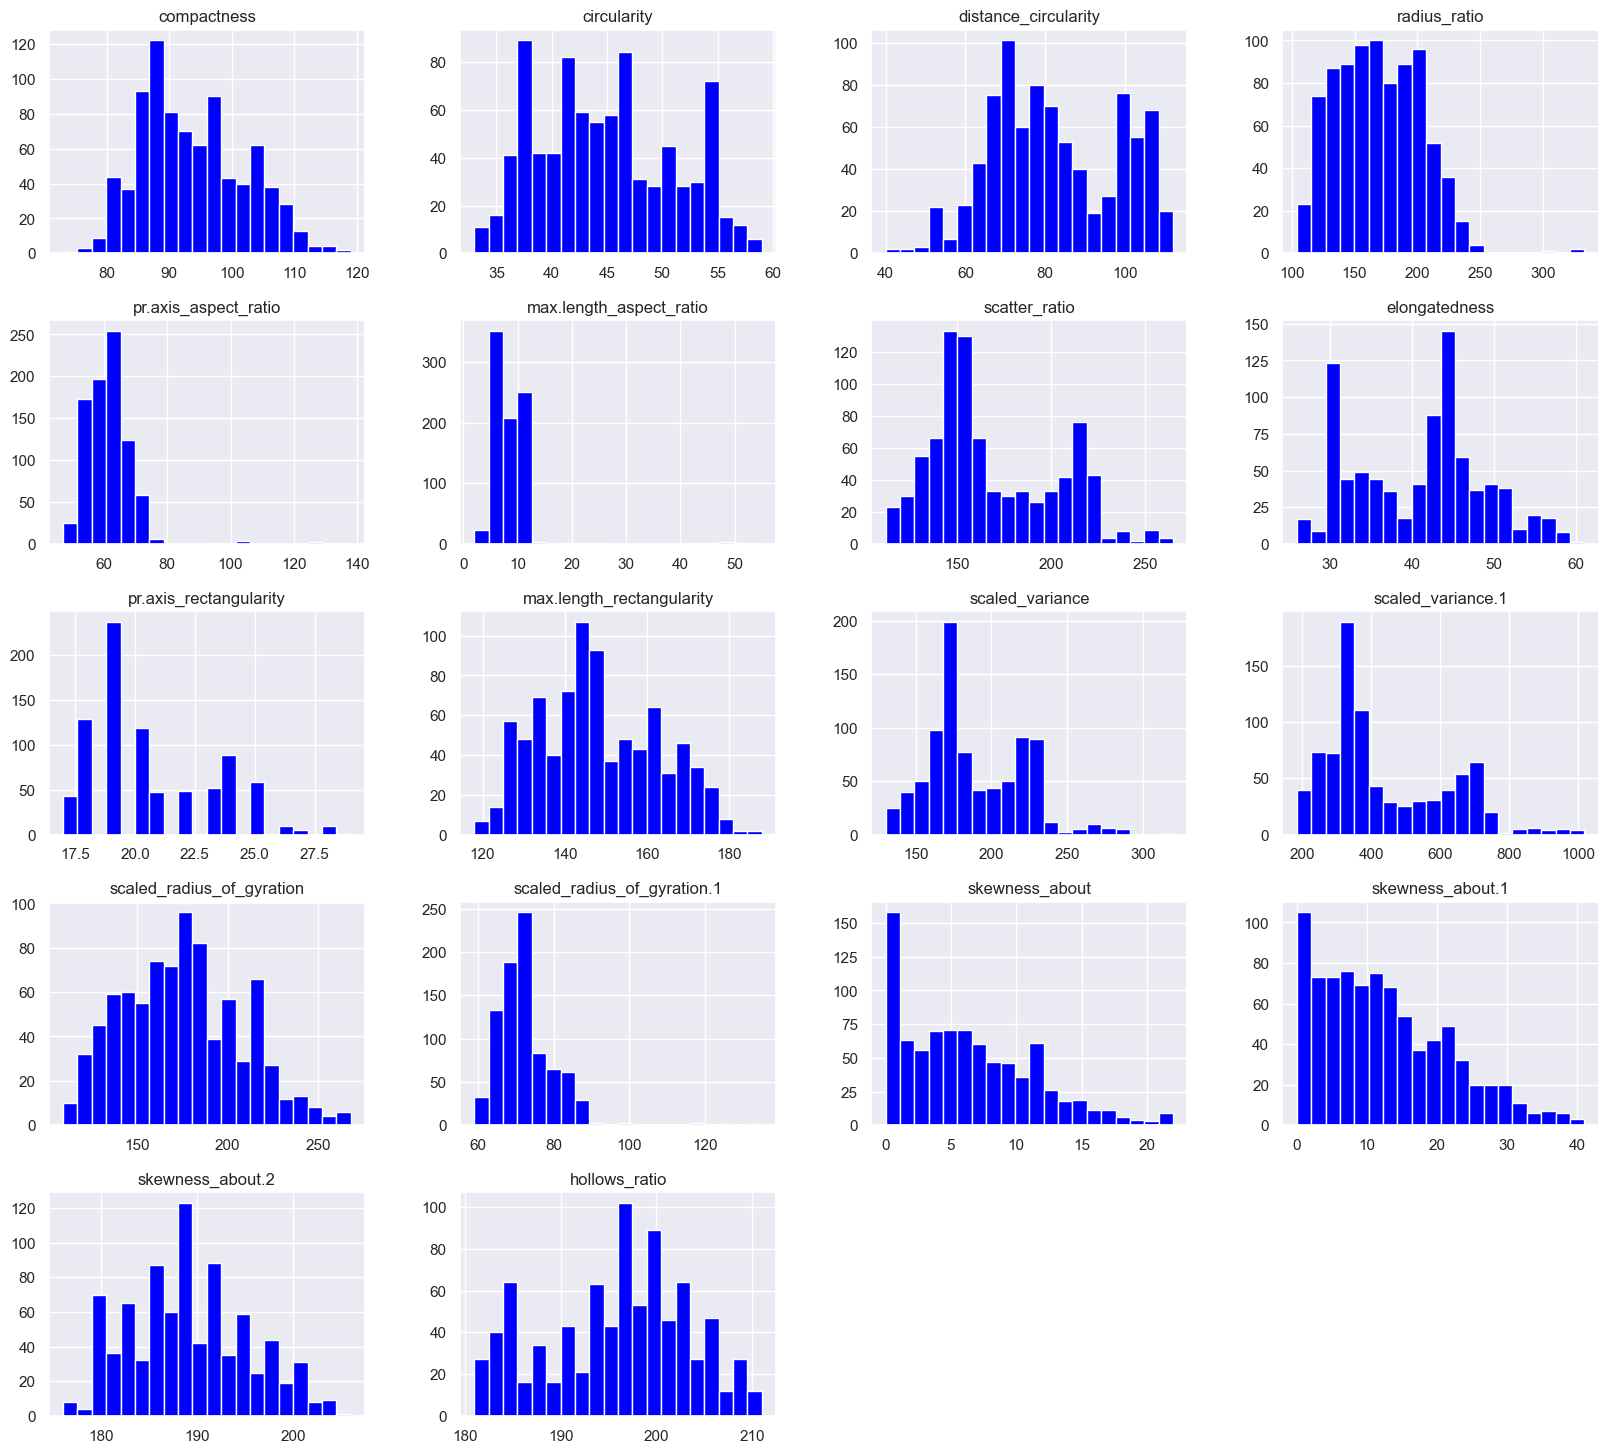

In [131]:
#plotting the distribution of the numerical variables
ve.hist(bins = 20, figsize = (20, 18), color = 'blue')
plt.show()

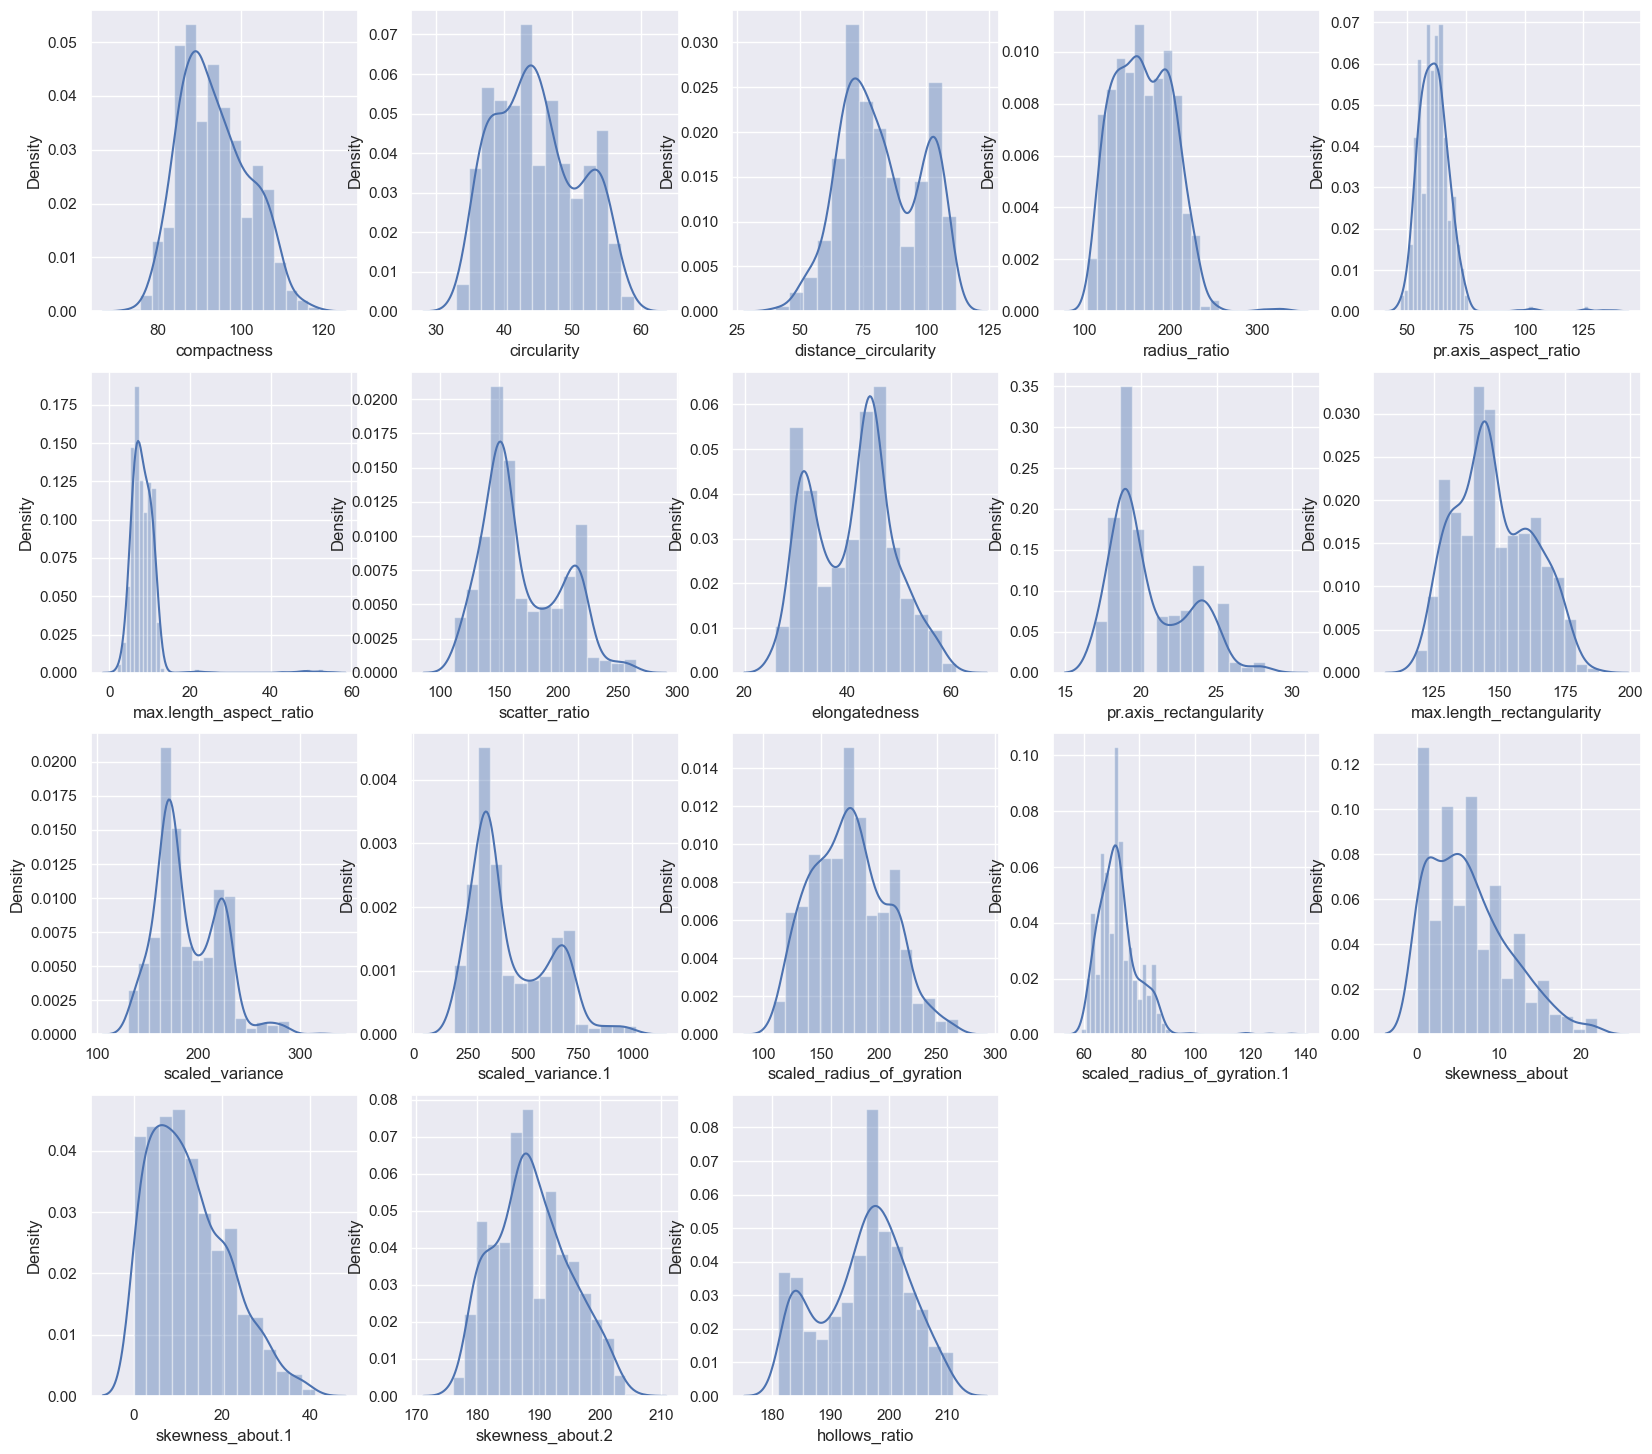

In [132]:
#Density plots
plt.figure(figsize=(20, 18))
col = 1
for i in ve.drop(columns='class').columns:
    plt.subplot(4, 5, col)
    sns.distplot(ve[i], color = 'b')
    col += 1 

Columns have data distributed across multiple scales.
Several columns have distributions that are not unimodal (eg.: distance_circularity, hollows_ratio, elongatedness
Column skweness_about, skewness_about.1 have data that is right skewed whereas for column skewness_about.2 data is nearly normally distributed.
Some columns have long right tail (eg.: pr.axis_aspect_ratio) as evident from the above distplot it is highly likely that they will have outliers.

class
car    429
bus    218
van    199
Name: count, dtype: int64


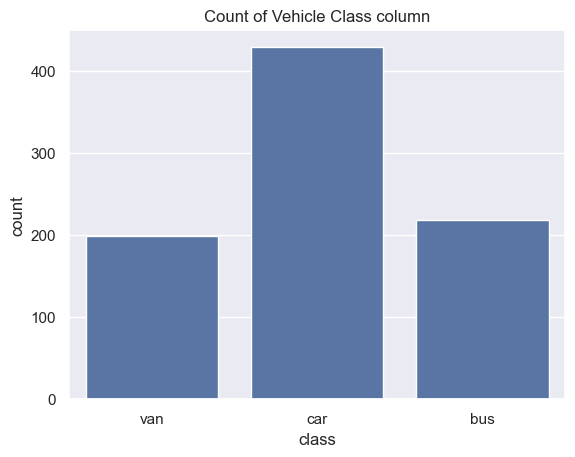

In [134]:
#checking the distribution of the class variable
print(ve['class'].value_counts())
plt.title('Count of Vehicle Class column')
sns.countplot(x = 'class', data = ve);

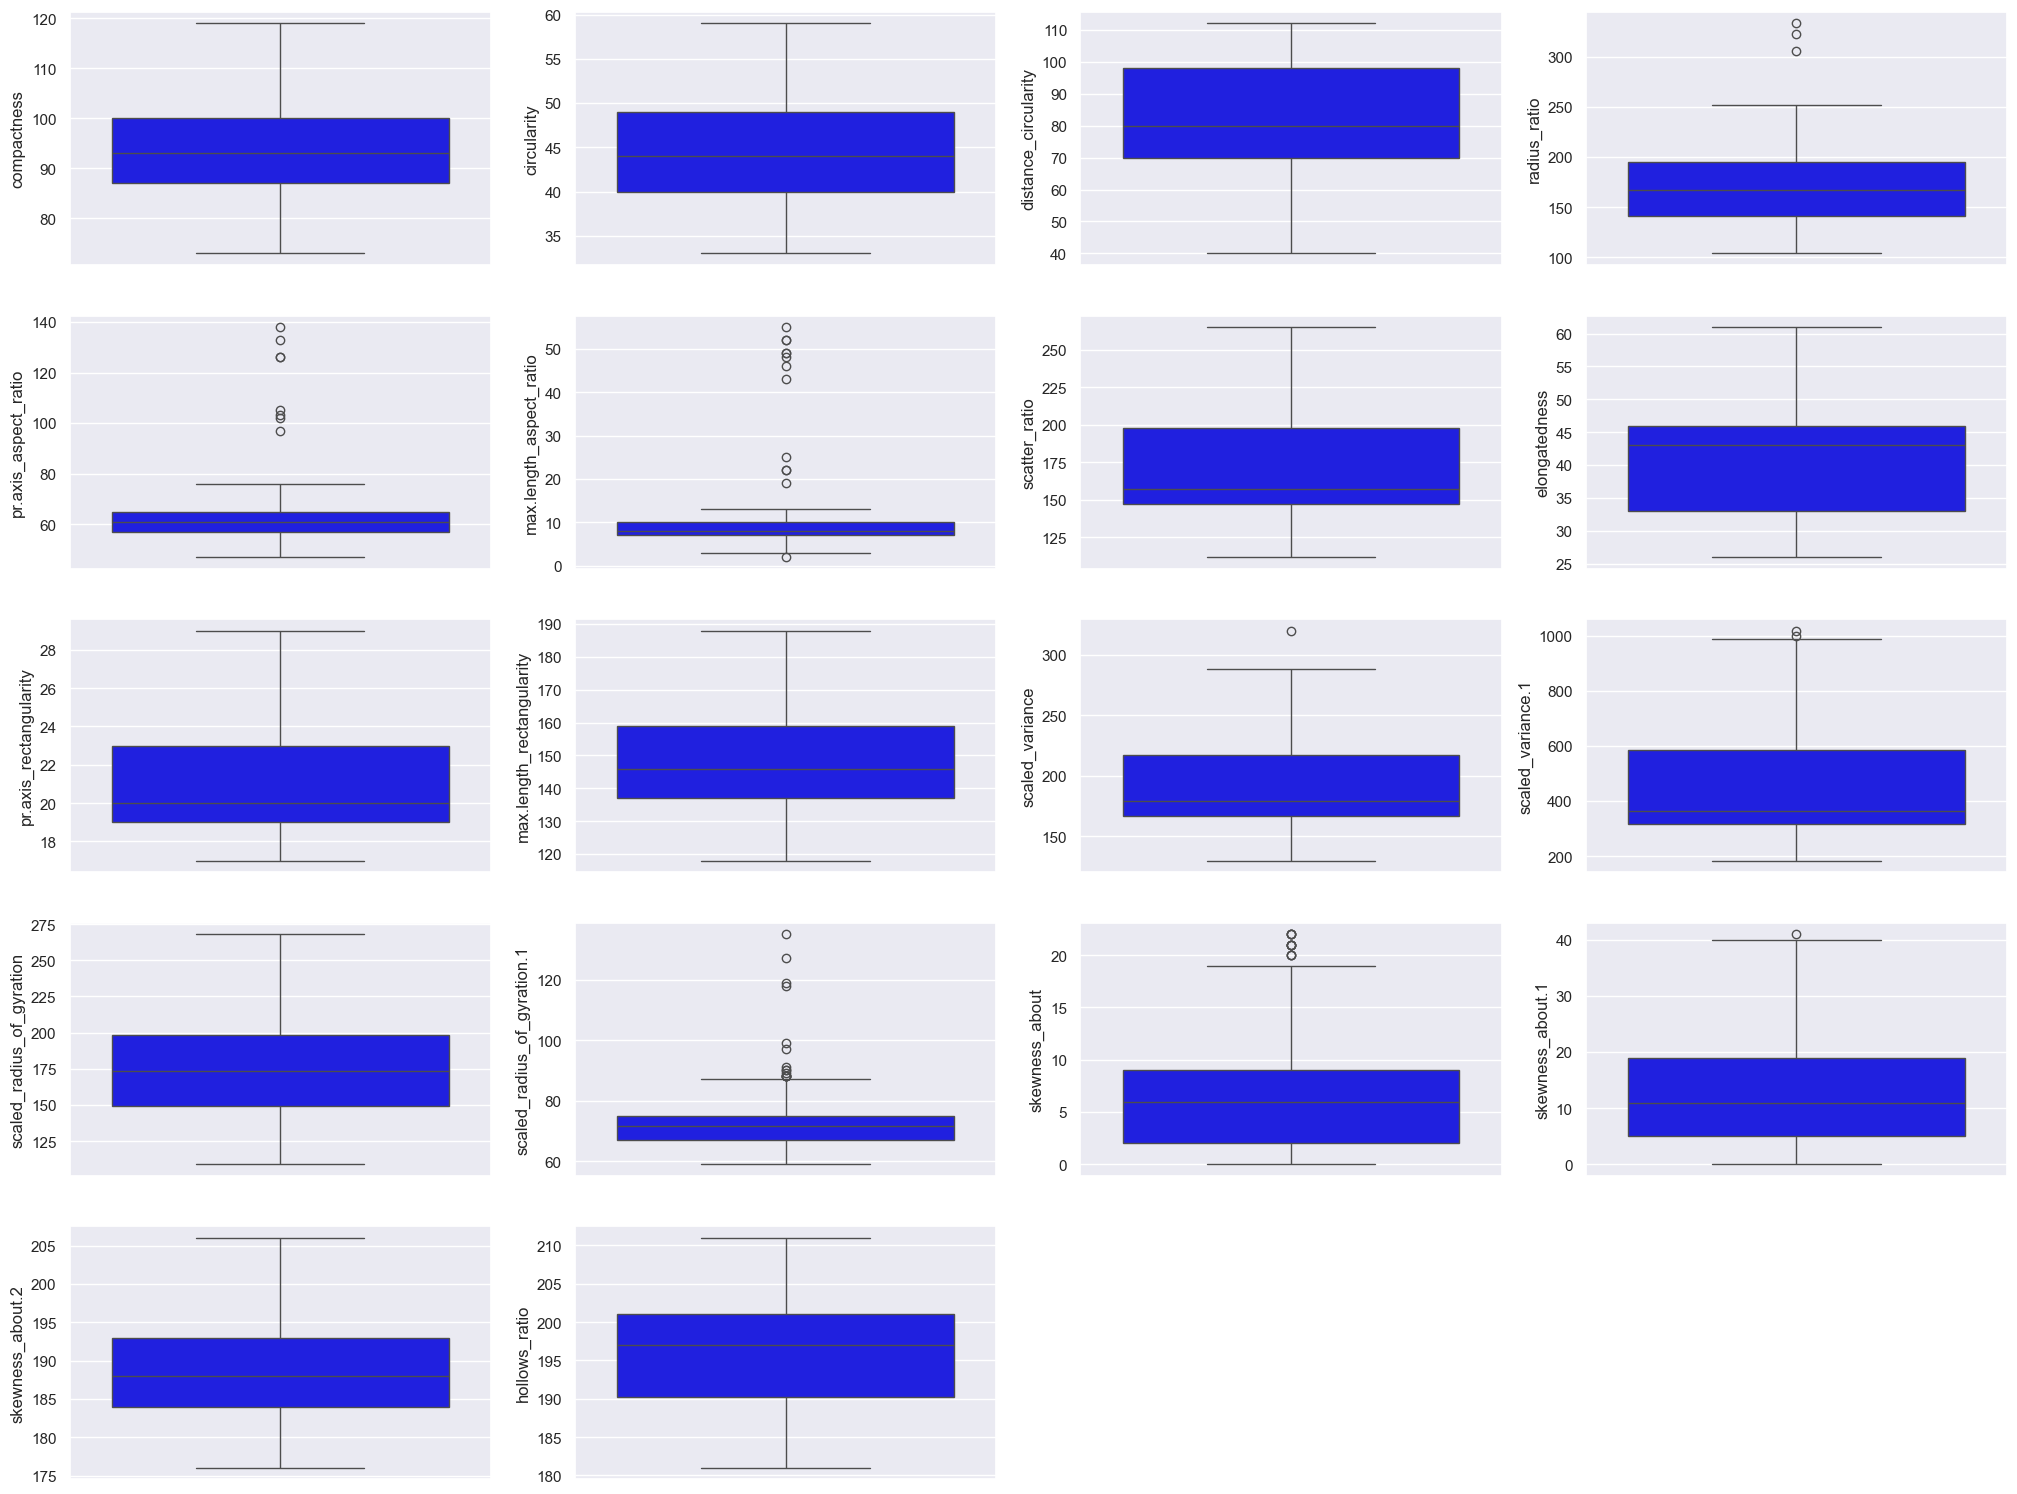

In [135]:
#boxplots for outliers
plt.figure(figsize=(25,23))
col = 1
for i in ve.drop(columns='class').columns:
    plt.subplot(6, 4, col)
    sns.boxplot(ve[i],color='blue')
    col += 1

Above Boxplots reveal that there are outliers in 8 different columns., will have them treated eventually

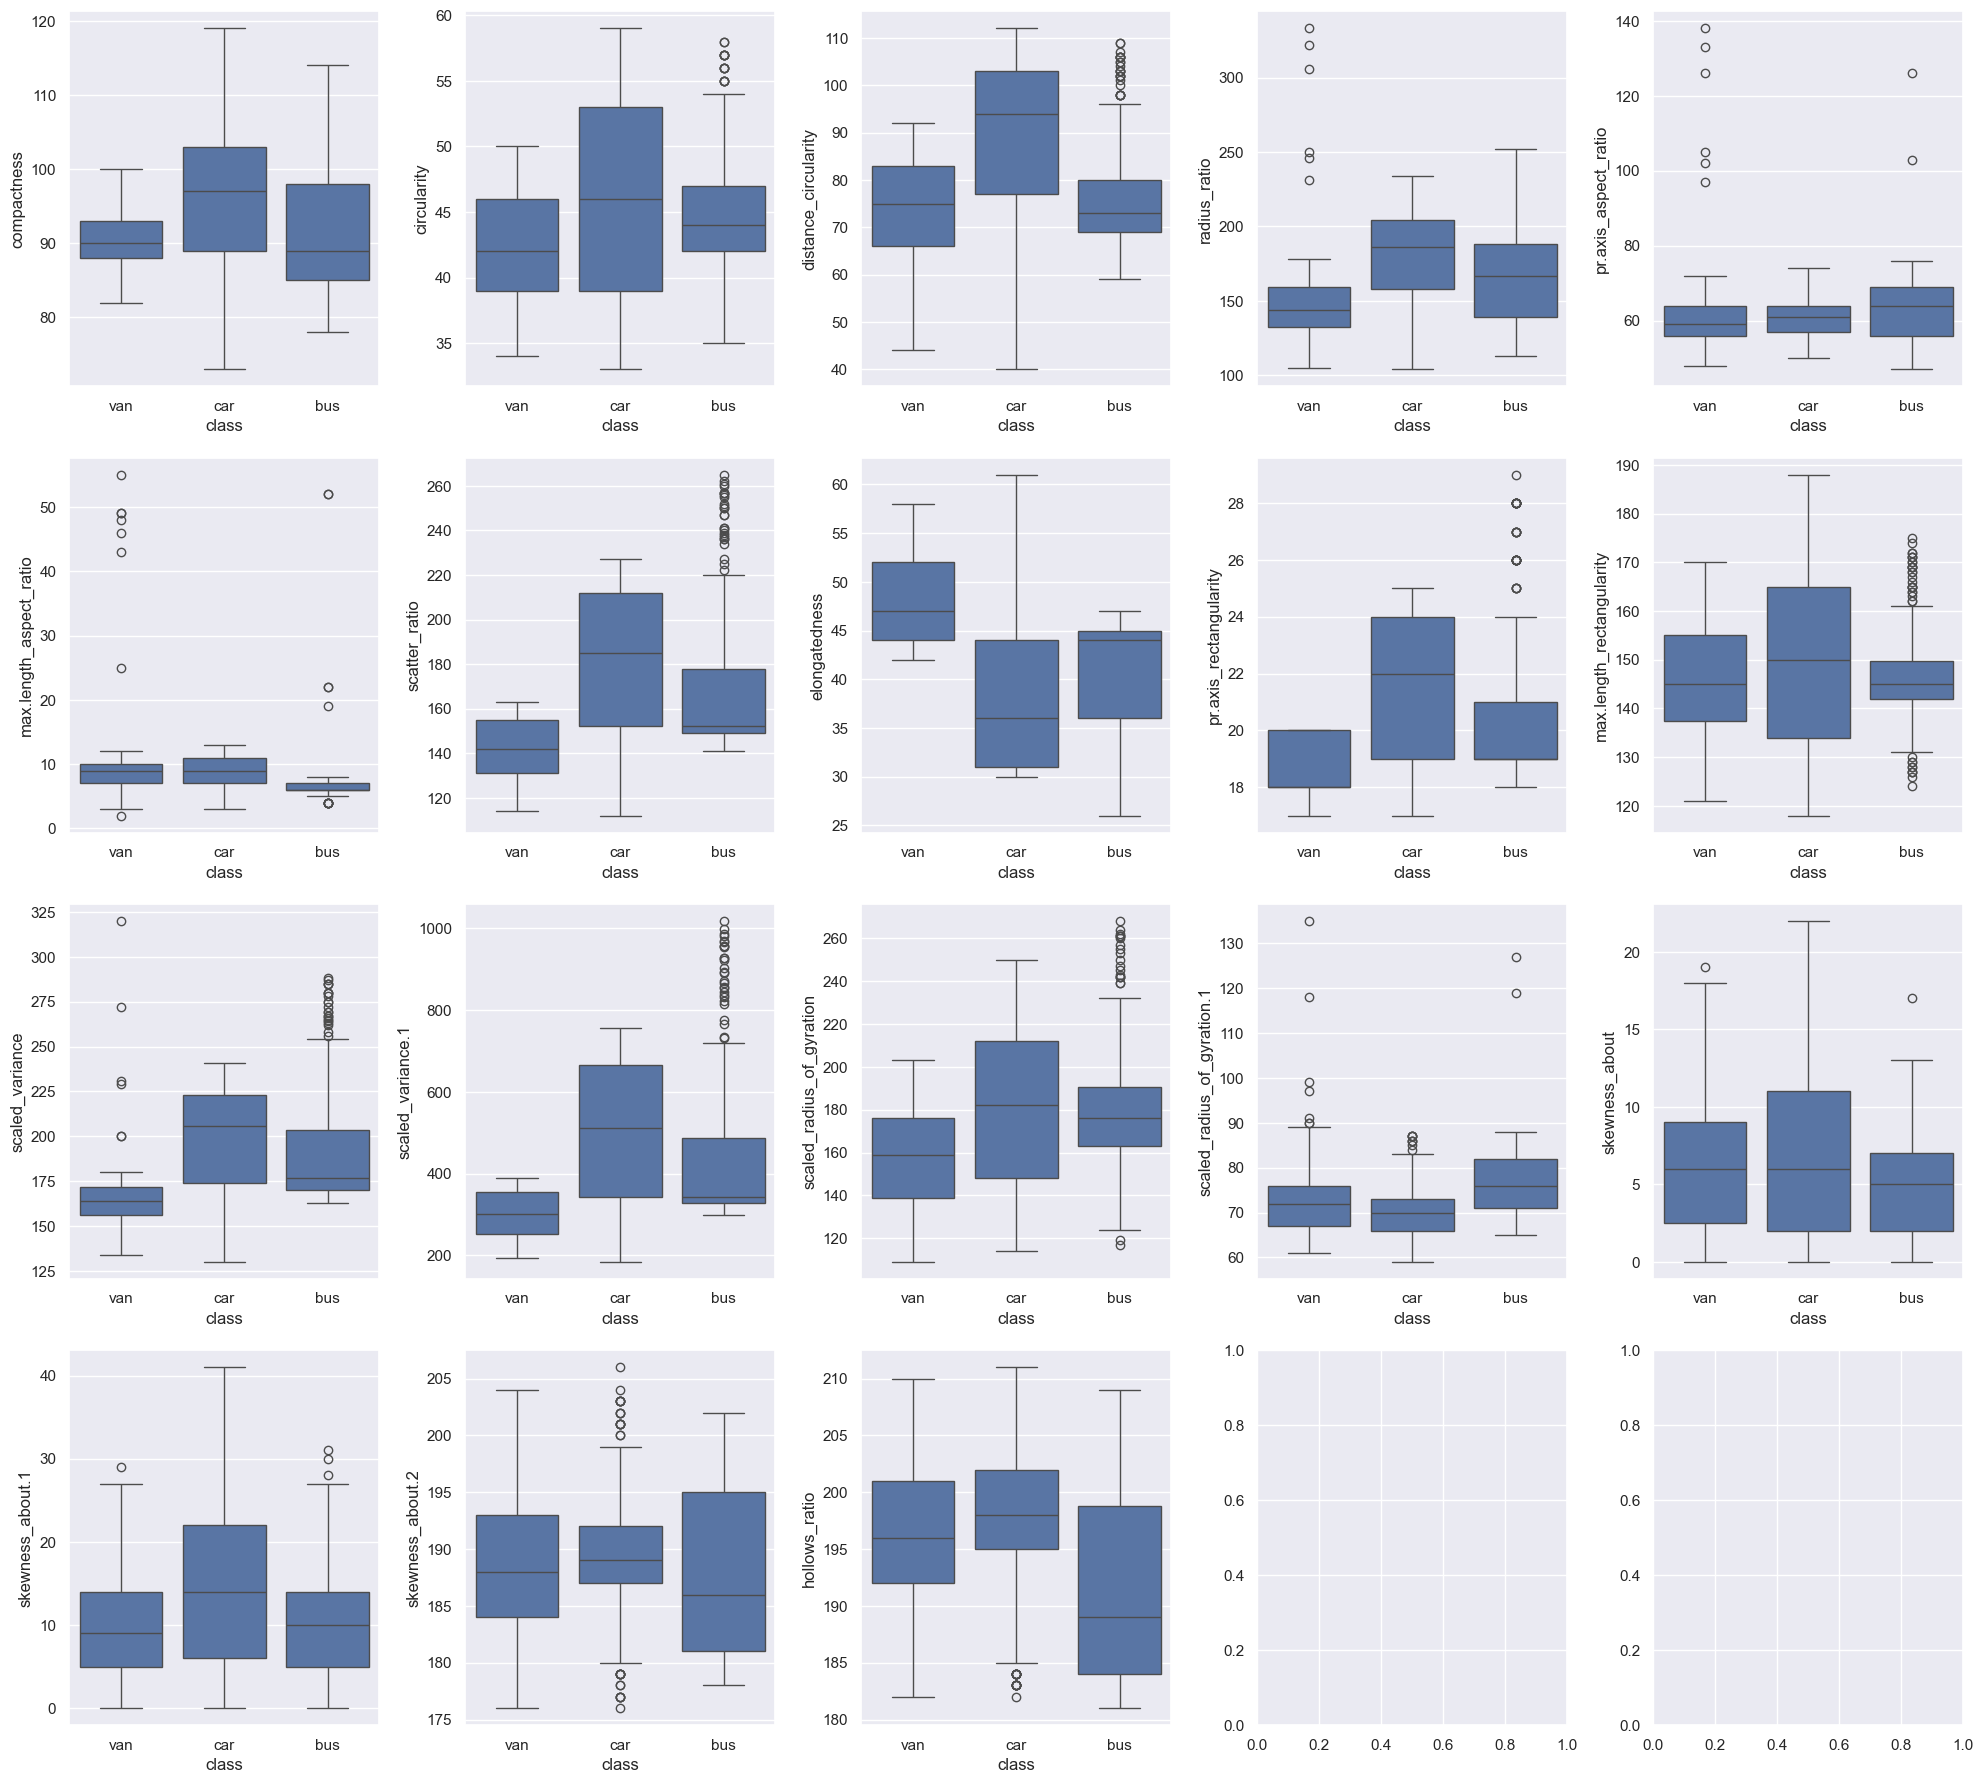

In [137]:
#Boxplots against the class with other numeric variables
fig,axs = plt.subplots(4,5,figsize=(20,18))
sns.boxplot(x="class", y="compactness",data=ve,ax=axs[0,0]);
sns.boxplot(x="class", y="circularity",data=ve,ax=axs[0,1]);
sns.boxplot(x="class", y="distance_circularity",data=ve,ax=axs[0,2]);
sns.boxplot(x="class", y="radius_ratio",data=ve,ax=axs[0,3]);
sns.boxplot(x="class", y="pr.axis_aspect_ratio",data=ve,ax=axs[0,4]);
sns.boxplot(x="class", y="max.length_aspect_ratio",data=ve,ax=axs[1,0]);
sns.boxplot(x="class", y="scatter_ratio",data=ve,ax=axs[1,1]);
sns.boxplot(x="class", y="elongatedness",data=ve,ax=axs[1,2]);
sns.boxplot(x="class", y="pr.axis_rectangularity",data=ve,ax=axs[1,3]);
sns.boxplot(x="class", y="max.length_rectangularity",data=ve,ax=axs[1,4]);
sns.boxplot(x="class", y="scaled_variance",data=ve,ax=axs[2,0]);
sns.boxplot(x="class", y="scaled_variance.1",data=ve,ax=axs[2,1]);
sns.boxplot(x="class", y="scaled_radius_of_gyration",data=ve,ax=axs[2,2]);
sns.boxplot(x="class", y="scaled_radius_of_gyration.1",data=ve,ax=axs[2,3]);
sns.boxplot(x="class", y="skewness_about",data=ve,ax=axs[2,4]);
sns.boxplot(x="class", y="skewness_about.1",data=ve,ax=axs[3,0]);
sns.boxplot(x="class", y="skewness_about.2",data=ve,ax=axs[3,1]);
sns.boxplot(x="class", y="hollows_ratio",data=ve,ax=axs[3,2]);
fig.tight_layout()

There is significant difference between classes when compared with the mean and median with all the numeric attributes

In [139]:
#find the outliers and replace them by median
for col_name in ve.drop(columns = 'class').columns:
    q1 = ve[col_name].quantile(0.25)
    q3 = ve[col_name].quantile(0.75)
    iqr = q3 - q1 
    low = q1 - 1.5 * iqr
    high = q3 + 1.5 * iqr 
    ve.loc[(ve[col_name] < low) | (ve[col_name] > high), col_name] = ve[col_name].median()

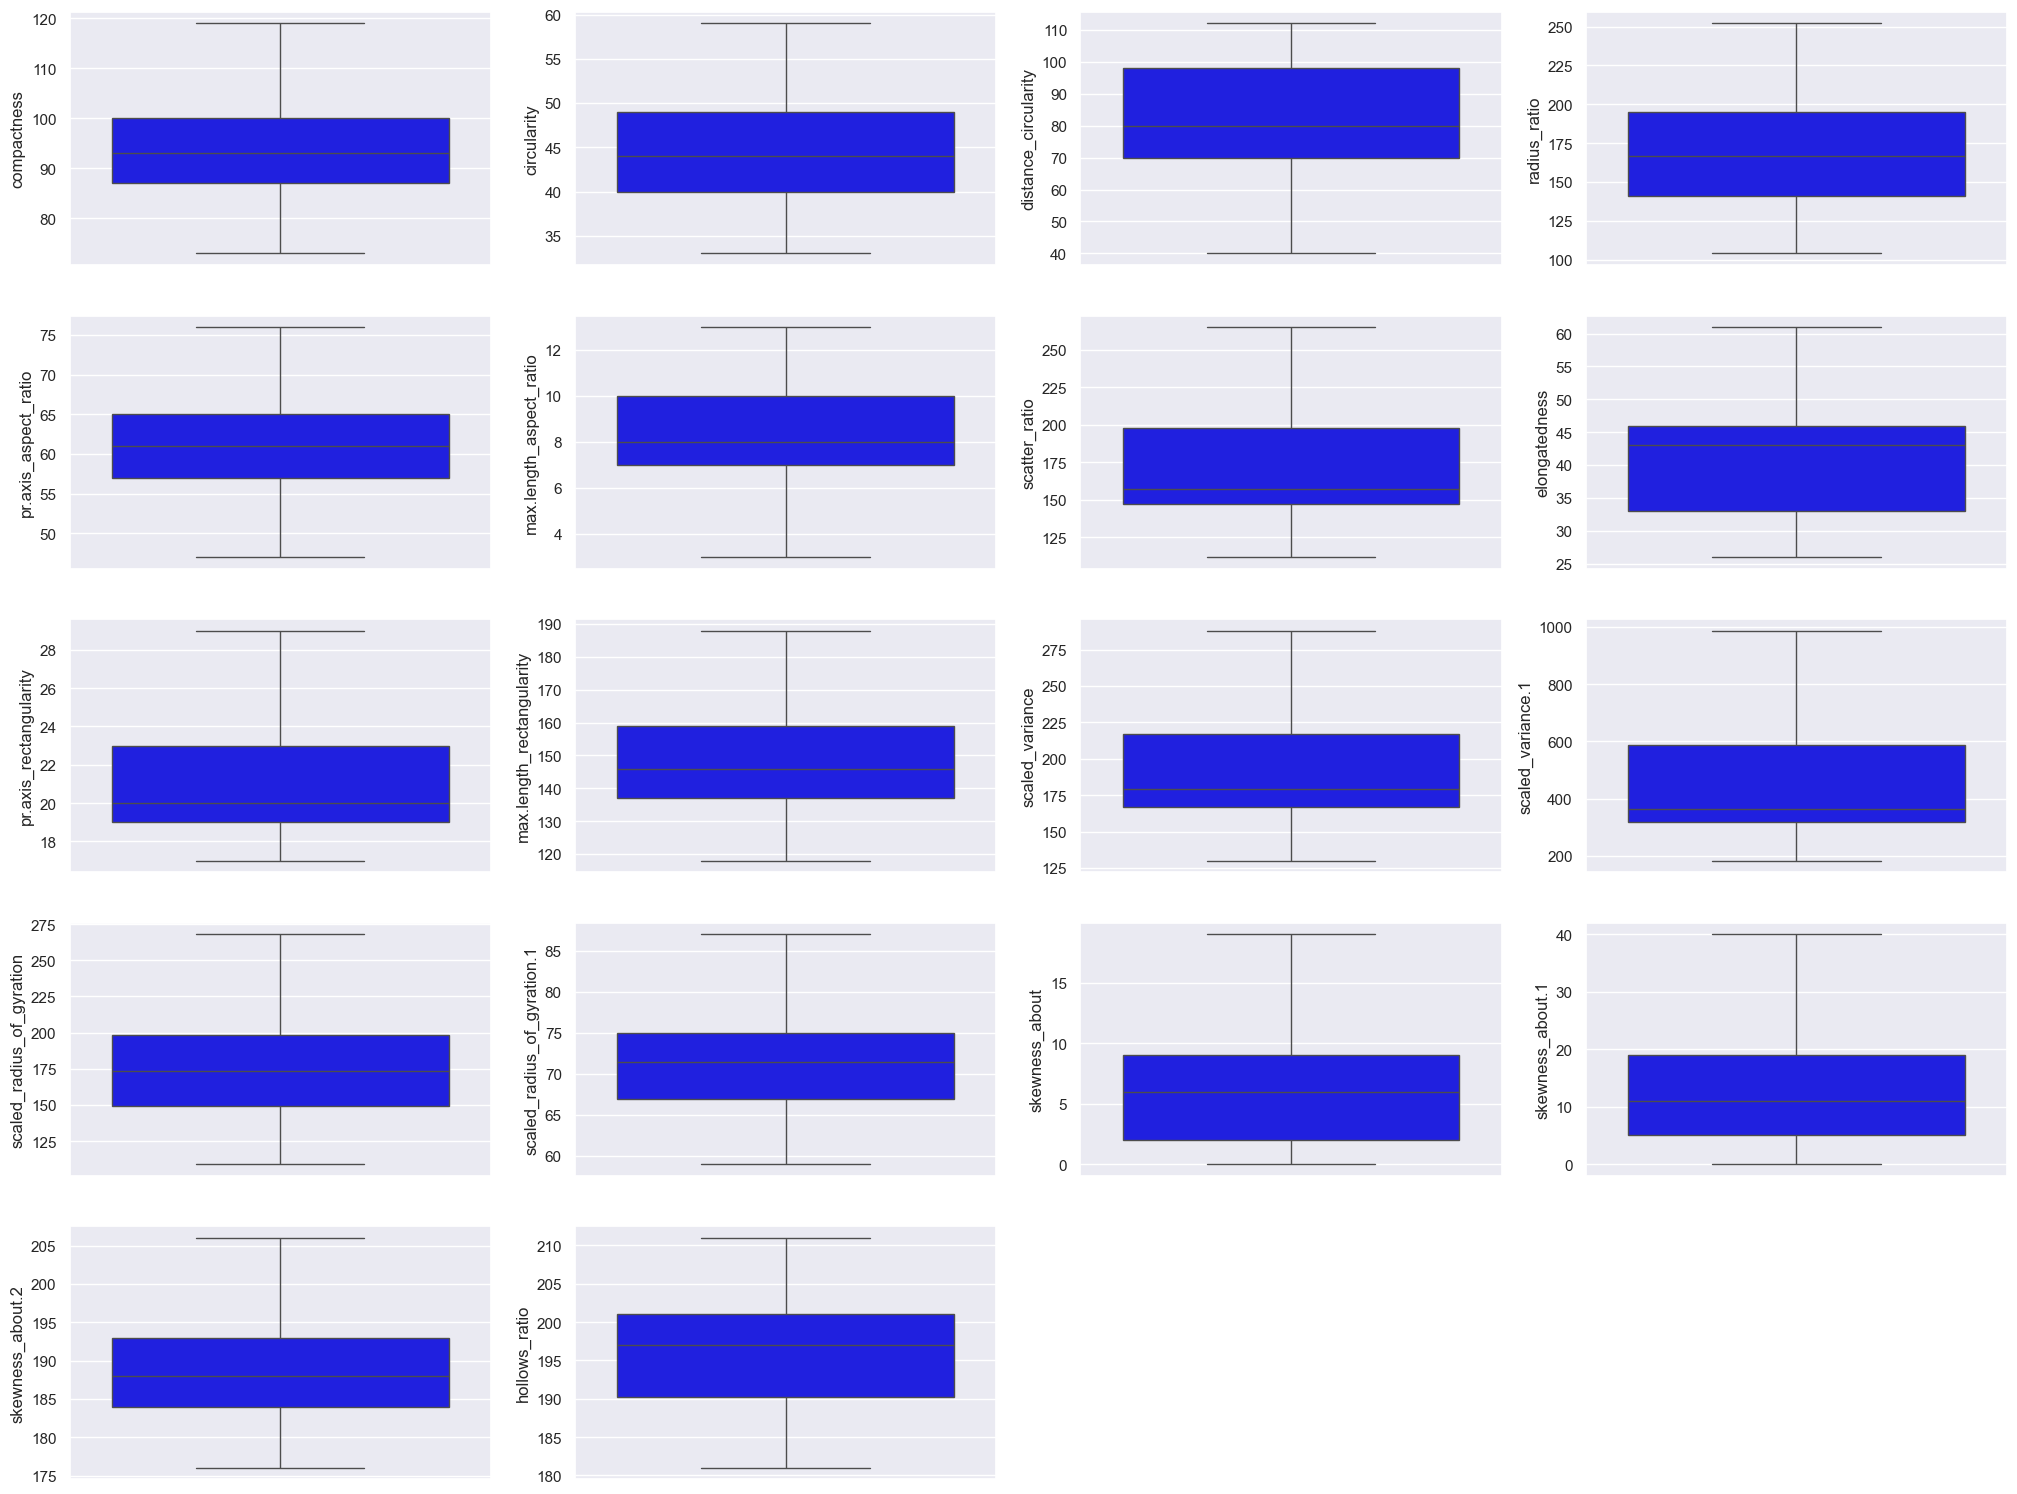

In [140]:
#boxplot after outlier treatment
plt.figure(figsize=(25,23))
col = 1
for i in ve.drop(columns='class').columns:
    plt.subplot(6, 4, col)
    sns.boxplot(ve[i],color='blue')
    col += 1

In [141]:
#spliiting the data to check for correlation with the class variable
X = ve.loc[:, ve.columns != 'class']
y = ve['class'].astype('category').cat.codes

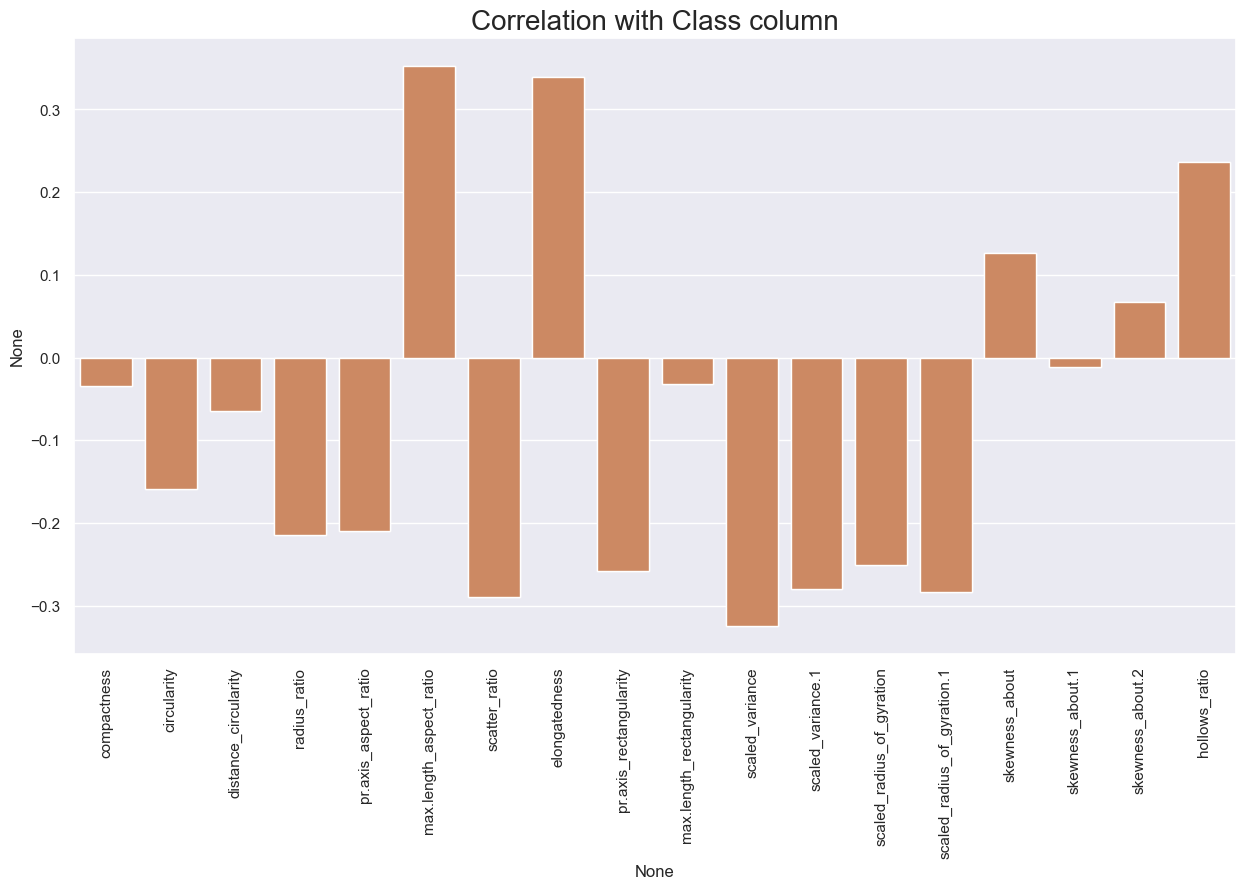

In [142]:
#plotting the correlation with target variable
plt.figure(figsize = (15, 8))
ax=sns.barplot(x=X.columns, y = X.corrwith(y))
sns.barplot(x = X.columns, y = X.corrwith(y))
plt.title('Correlation with Class column', fontsize = 20)
x=plt.setp(ax.get_xticklabels(), rotation=90)

## PCA

In [144]:
#scaling the muerica variables
XScaled=X.apply(zscore)
XScaled.head()

compactness  circularity  distance_circularity  radius_ratio  \
0     0.160580     0.518073              0.057177      0.300945   
1    -0.325470    -0.623732              0.120741     -0.850666   
2     1.254193     0.844303              1.519141      1.265808   
3    -0.082445    -0.623732             -0.006386     -0.290423   
4    -1.054545    -0.134387             -0.769150      1.141310   

   pr.axis_aspect_ratio  max.length_aspect_ratio  scatter_ratio  \
0              1.933135                 0.912212      -0.207598   
1             -0.740596                 0.427456      -0.599423   
2              0.863642                 0.912212       1.148719   
3              0.328896                 0.427456      -0.750125   
4             -0.027601                -0.057300      -0.599423   

   elongatedness  pr.axis_rectangularity  max.length_rectangularity  \
0       0.136262               -0.224342                   0.758332   
1       0.520519               -0.610886                  -0.344578   
2      -1.144597                0.935290                   0.689401   
3       0.648605               -0.610886                  -0.344578   
4       0.520519               -0.610886                  -0.275646   

   scaled_variance  scaled_variance.1  scaled_radius_of_gyration  \
0        -0.400771          -0.337407                   0.285705   
1        -0.594220          -0.618623                  -0.513630   
2         1.114582           1.131806                   1.392477   
3        -0.916635          -0.739145                  -1.466683   
4         1.694930          -0.647319                   0.408680   

   scaled_radius_of_gyration.1  skewness_about  skewness_about.1  \
0                    -0.315806       -0.032330          0.387162   
1                     0.009122        0.624090          0.161740   
2                     0.171586        1.718123         -0.401818   
3                    -1.453054       -0.032330         -0.289106   
4                    -0.072110        0.624090         -0.176395   

   skewness_about.2  hollows_ratio  
0         -0.312012       0.183957  
1          0.013265       0.452977  
2         -0.149374       0.049447  
3          1.639649       1.529056  
4         -1.450481      -1.699181

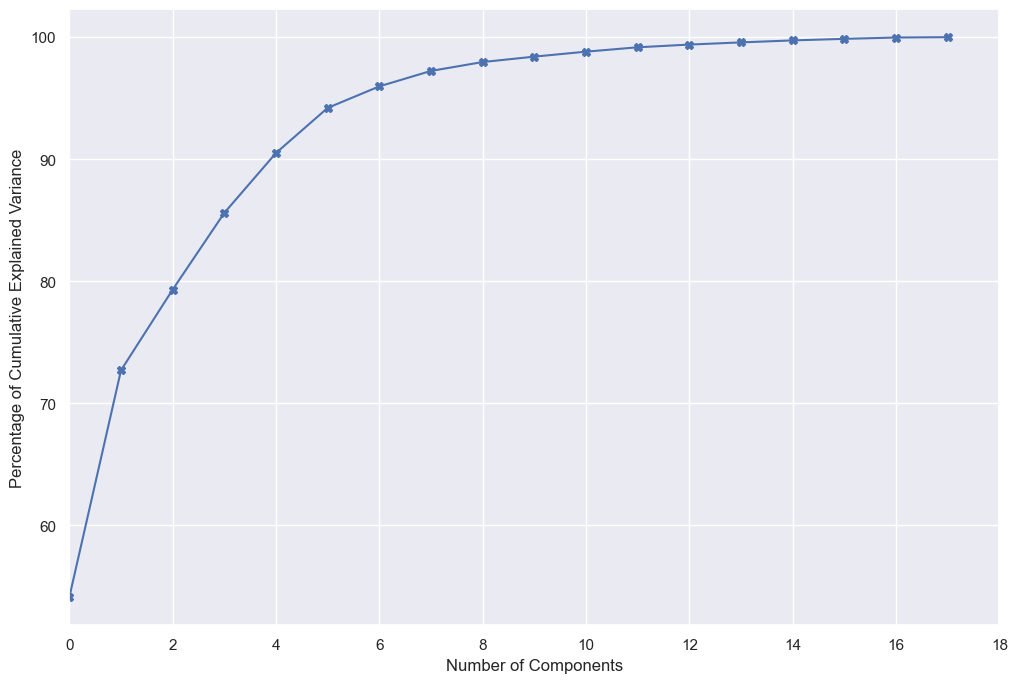

In [145]:
#plotting the cummulative variance explained by the principal componets
pca = PCA()
X_pca_ = pca.fit_transform(XScaled)
plt.figure(figsize = (12, 8))
plt.plot((np.cumsum(pca.explained_variance_ratio_) * 100), marker = 'X')
plt.xlim(0, 18)
plt.xlabel('Number of Components')
plt.ylabel('Percentage of Cumulative Explained Variance');

In [146]:
print(pca.explained_variance_)

[9.74940269e+00 3.35071912e+00 1.19238155e+00 1.13381916e+00
 8.83997312e-01 6.66265745e-01 3.18150910e-01 2.28179142e-01
 1.31018595e-01 7.98619108e-02 7.33979478e-02 6.46162669e-02
 4.01448646e-02 3.22758478e-02 2.93936408e-02 2.27005257e-02
 1.98136761e-02 5.16287320e-03]


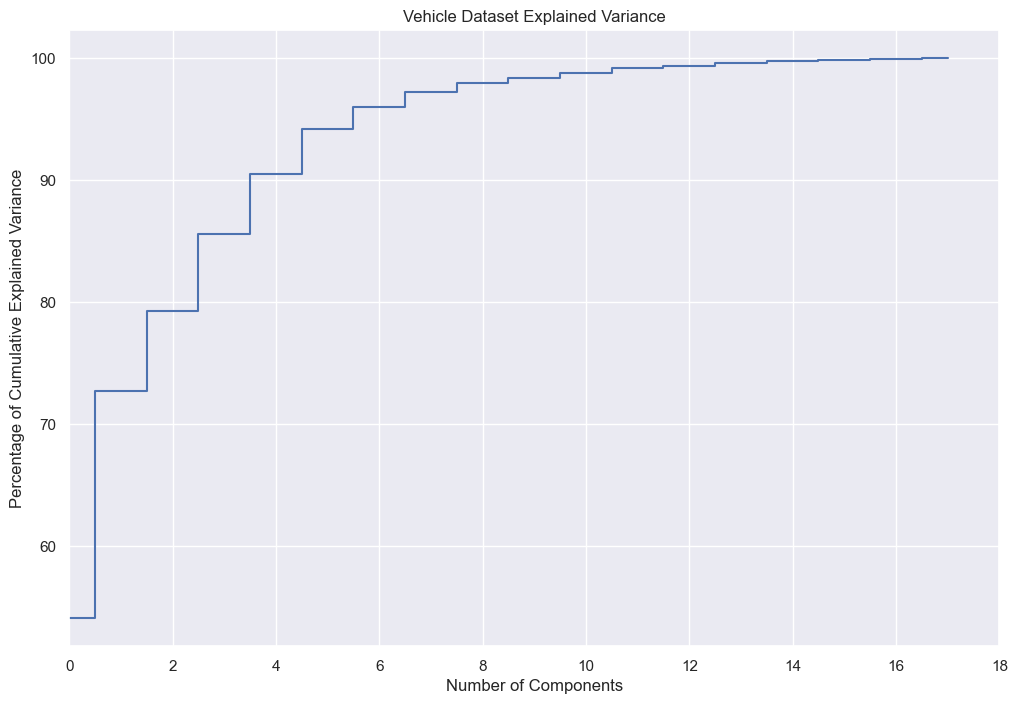

In [147]:
#plotting the
plt.figure(figsize = (12, 8))
plt.step(list(range(18)), (np.cumsum(pca.explained_variance_ratio_) * 100), where = 'mid')
plt.xlim(0, 18)
plt.xlabel('Number of Components')
plt.ylabel('Percentage of Cumulative Explained Variance')
plt.title('Vehicle Dataset Explained Variance');

We can see that the first six components explain more than 95% of variation.
Between first 5 components, more than 91% of the information is captured.
The above plot shows almost 95% variance by the first 6 components. Therefore we can drop 7th component onwards.

In [149]:
#Using 6 components and printing the eigen vectors
pca3 = PCA(n_components=6)
pca3.fit(XScaled)
print(pca3.components_)
print(pca3.explained_variance_ratio_)
Xpca3 = pca3.transform(XScaled)

[[ 0.27250289  0.28725469  0.30242111  0.26971354  0.09786073  0.19520014
   0.31052393 -0.3090069   0.307287    0.27815416  0.29976509  0.30553237
   0.26323762 -0.04193594  0.03608321  0.05872048  0.03801314  0.08474   ]
 [-0.08704358  0.13162176 -0.04614301 -0.19793126 -0.25783995 -0.10804563
   0.07528535 -0.01322994  0.0875602   0.12215424  0.07726575  0.07150302
   0.21058205  0.50362158 -0.01576632 -0.09274624 -0.50162122 -0.50761211]
 [-0.03818521 -0.20114691  0.06346211  0.05628517 -0.06199275 -0.14895782
   0.10904283 -0.09085269  0.1060705  -0.21368469  0.1445998   0.11034373
  -0.20287019  0.07386402 -0.55917399  0.6706805  -0.06224071 -0.04170535]
 [ 0.13867501 -0.03805548  0.10895429 -0.25435509 -0.61276572  0.27867816
   0.00539295  0.06521486  0.03089915  0.04146747 -0.06400509 -0.00219687
  -0.08553965 -0.11539962  0.47370331  0.42842603 -0.0274096   0.09603749]
 [ 0.13710147 -0.13899555 -0.08001743  0.13374437  0.12360146 -0.63489336
   0.08555746 -0.07907344  0.08164

In [150]:
#printing the original features and the reduced features
pca_6 = PCA(n_components = 6)
X_pca = pca_6.fit_transform(XScaled)
print('Original number of features:', X.shape[1])
print('Reduced number of features:', X_pca.shape[1])

Original number of features: 18
Reduced number of features: 6


In [151]:
#viewing the first 5 observations of the pca components
pca_df = pd.DataFrame(data = X_pca)
pca_df.head()

0         1         2         3         4         5
0  0.584228 -0.675673 -0.453334 -0.750656 -0.777515 -1.848809
1 -1.512180 -0.348934 -0.333436  1.268953 -0.324929 -0.118317
2  3.913448  0.234507 -1.265094  0.137224  0.915751 -0.685594
3 -1.535193 -3.044413 -0.469623  0.324317 -0.611590  0.367777
4 -0.642062  1.488882 -0.246288 -0.550939  0.471655 -1.012697

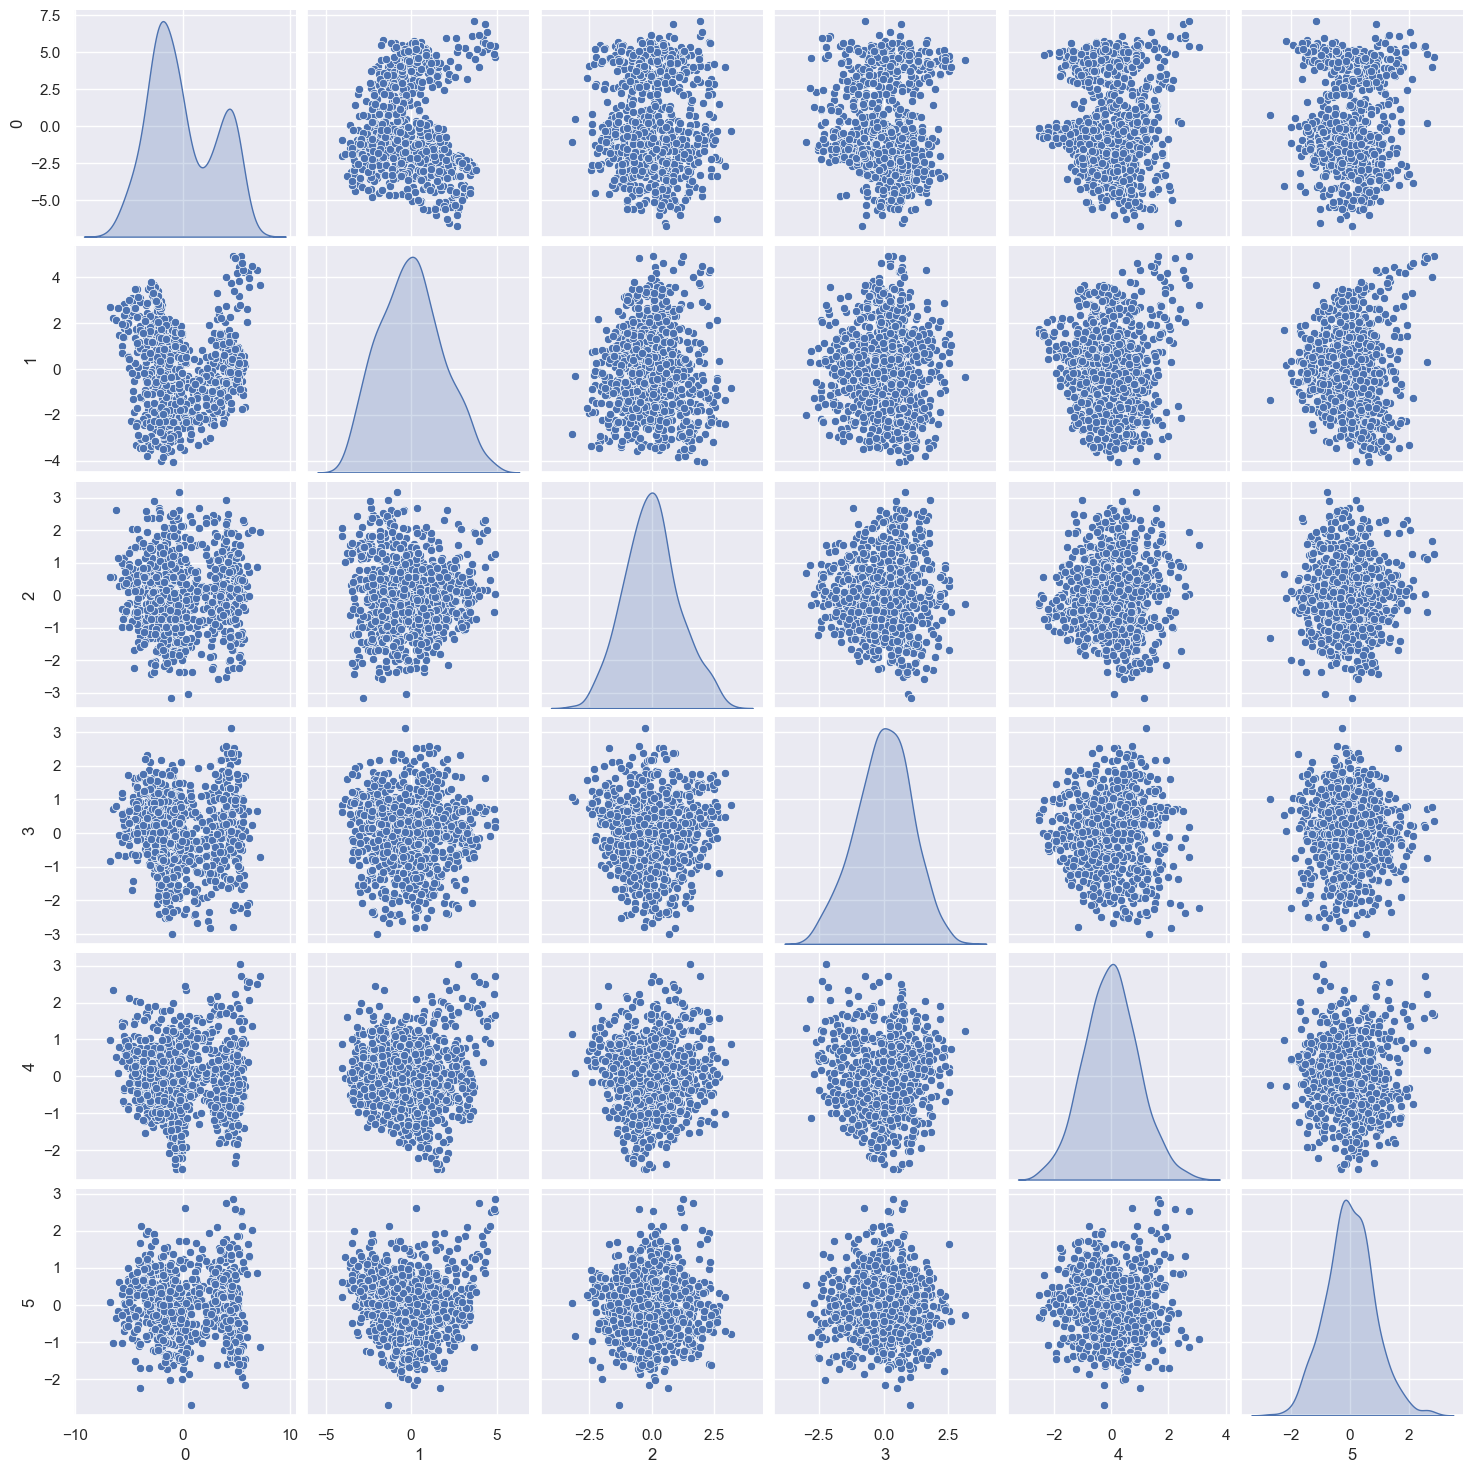

In [152]:
sns.pairplot(pca_df, diag_kind = 'kde');

## SVM

In [154]:
#splitting the original data into train and test 70:30
X_train, X_test, y_train, y_test = train_test_split(XScaled, y, test_size = 0.3, random_state = 10)

In [155]:
rtr, ctr = X_train.shape
print('The training set comprises of', rtr, 'rows and', ctr, 'columns.')

The training set comprises of 592 rows and 18 columns.


In [156]:
rt, ct = X_test.shape
print('The test set comprises of', rt, 'rows and', ct, 'columns.')

The test set comprises of 254 rows and 18 columns.


In [157]:
#splitting the pca data into train and test 70:30
X_tr, X_te, y_tr, y_te = train_test_split(X_pca, y, test_size = 0.3, random_state = 10)

In [158]:
rtr_pca, ctr_pca = X_tr.shape
print('The PCA training set comprises of', rtr_pca, 'rows and', ctr_pca, 'columns.')

The PCA training set comprises of 592 rows and 6 columns.


In [159]:
rt_pca, ct_pca = X_te.shape
print('The PCA test set comprises of', rt_pca, 'rows and', ct_pca, 'columns.')

The PCA test set comprises of 254 rows and 6 columns.


In [160]:
# Building a Support Vector Machine on train data
svc_model = SVC(C= 4, kernel='rbf', gamma='scale')
svc_model.fit(X_train, y_train)

SVC(C=4)

In [161]:
#predicting on train data
sv_train_predict = svc_model .predict(X_train)
print("Model Accuracy on train: {0:.4f}".format(metrics.accuracy_score(y_train, sv_train_predict)))
print()

Model Accuracy on train: 0.9899



In [162]:
#predicting on test data
sv_test_predict = svc_model .predict(X_test)
print("Model Accuracy on test: {0:.4f}".format(metrics.accuracy_score(y_test, sv_test_predict)))
print()

Model Accuracy on test: 0.9685



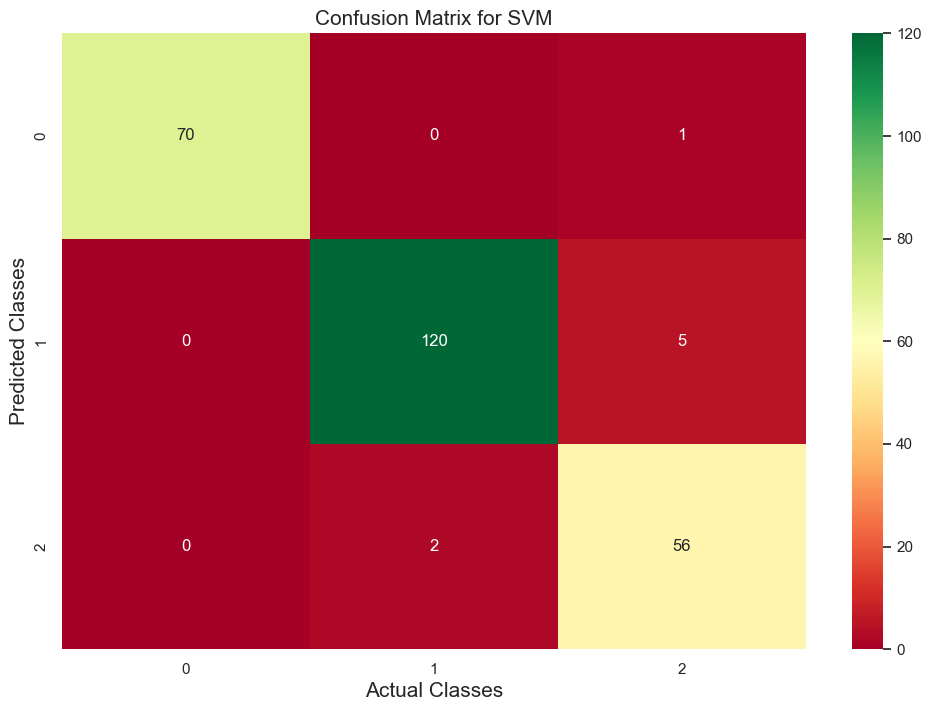

In [163]:
#visualization of confusion matrix in the form of a heatmap
cm= confusion_matrix(y_test, sv_test_predict)
plt.figure(figsize = (12, 8))
sns.heatmap(cm, annot = True, cmap = 'RdYlGn', fmt = 'd')
plt.xlabel('Actual Classes', fontsize = 15)
plt.ylabel('Predicted Classes', fontsize = 15)
plt.title('Confusion Matrix for SVM', fontsize = 15);

In [164]:
#printing classification report
print("Classification Report")
print(metrics.classification_report(y_test, sv_test_predict, labels=[0,1,2]))

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        71
           1       0.98      0.96      0.97       125
           2       0.90      0.97      0.93        58

    accuracy                           0.97       254
   macro avg       0.96      0.97      0.97       254
weighted avg       0.97      0.97      0.97       254



In [165]:
precision_SV, recall_SV, f1_score_SV, support = precision_recall_fscore_support(y_test, sv_test_predict,average='macro')
print('Precision Score :', '%0.2f' % precision_SV)
print('Recall Score :', '%0.2f' % recall_SV)
print('F1-Score:', '%0.2f' % f1_score_SV)
SV_Acc= accuracy_score(y_test, sv_test_predict)
print('Accuracy Score :','%0.2f' % SV_Acc)

Precision Score : 0.96
Recall Score : 0.97
F1-Score: 0.97
Accuracy Score : 0.97


In [166]:
#SVM on the pca data
svc_model_pca = SVC(C= 4, kernel='rbf', gamma='scale')
svc_model_pca.fit(X_tr, y_tr)

SVC(C=4)

In [167]:
#predicting on train data
sv_tr_predict = svc_model_pca .predict(X_tr)
print("Model Accuracy on train: {0:.4f}".format(metrics.accuracy_score(y_tr, sv_tr_predict)))
print()

Model Accuracy on train: 0.9476



In [168]:
#predicting on test data
sv_te_predict = svc_model_pca .predict(X_te)
print("Model Accuracy on test: {0:.4f}".format(metrics.accuracy_score(y_te, sv_te_predict)))
print()

Model Accuracy on test: 0.9213



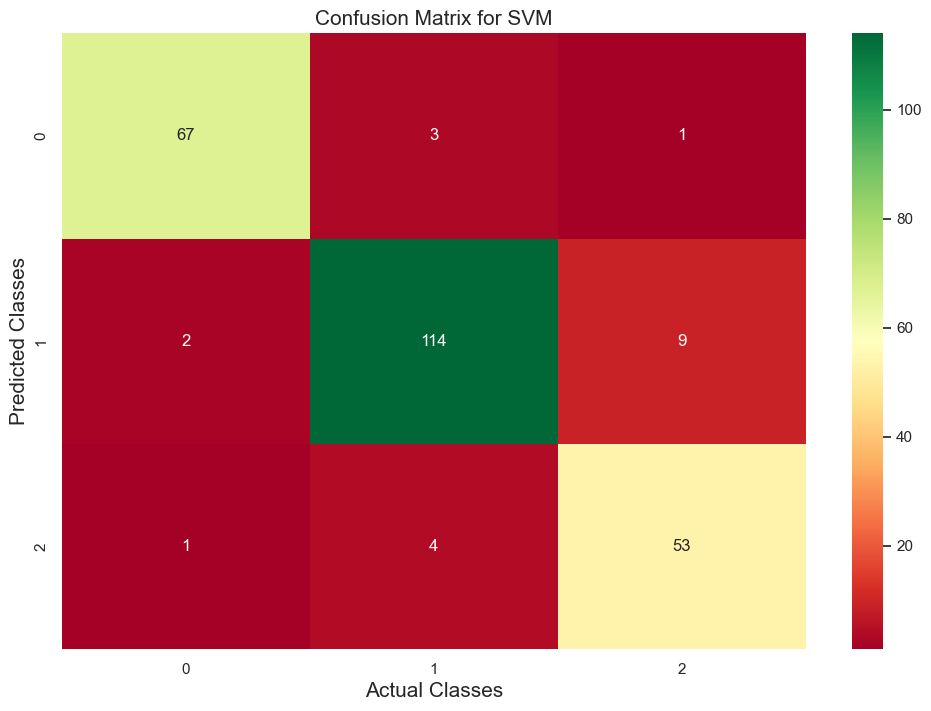

In [169]:
#visualization of confusion matrix in the form of a heatmap
cm= confusion_matrix(y_te, sv_te_predict)
plt.figure(figsize = (12, 8))
sns.heatmap(cm, annot = True, cmap = 'RdYlGn', fmt = 'd')
plt.xlabel('Actual Classes', fontsize = 15)
plt.ylabel('Predicted Classes', fontsize = 15)
plt.title('Confusion Matrix for SVM', fontsize = 15);

In [170]:
#printing classification report
print("Classification Report")
print(metrics.classification_report(y_te, sv_te_predict, labels=[0,1,2]))

Classification Report
              precision    recall  f1-score   support

           0       0.96      0.94      0.95        71
           1       0.94      0.91      0.93       125
           2       0.84      0.91      0.88        58

    accuracy                           0.92       254
   macro avg       0.91      0.92      0.92       254
weighted avg       0.92      0.92      0.92       254



In [171]:
precision_SV_pca, recall_SV_pca, f1_score_SV_pca, support_pca = precision_recall_fscore_support(y_te, sv_te_predict,average='macro')
print('Precision Score :', '%0.2f' % precision_SV_pca)
print('Recall Score :', '%0.2f' % recall_SV_pca)
print('F1-Score:', '%0.2f' % f1_score_SV_pca)
SV_Acc_pca= accuracy_score(y_te, sv_te_predict)
print('Accuracy Score :','%0.2f' % SV_Acc_pca)

Precision Score : 0.91
Recall Score : 0.92
F1-Score: 0.92
Accuracy Score : 0.92


In [172]:
modellists = []
modellists.append(['Support Vector Classifier without PCA', SV_Acc * 100, recall_SV * 100, precision_SV * 100,f1_score_SV*100])
modellists.append(['Support Vector Classifier with PCA', SV_Acc_pca* 100, recall_SV_pca * 100, precision_SV_pca * 100,f1_score_SV_pca*100])
mdl_df = pd.DataFrame(modellists, columns = ['Model','Accuracy Score of Test Data', 'Recall Score', 'Precision Score','F1 Score'])
mdl_df

Model  Accuracy Score of Test Data  \
0  Support Vector Classifier without PCA                    96.850394   
1     Support Vector Classifier with PCA                    92.125984   

   Recall Score  Precision Score   F1 Score  
0     97.047758        96.227745  96.596702  
1     92.315169        91.352049  91.773898

Bothe the model give more than 90% accuracy on the test data, PCA used only 6 attributes to come up with an accuracy of 90%+ where as the model without pca used all the variables to come up with 90%+ accuracy, the difference can be illustrated even better if the dataset had been cursed with dimensionality, since its 18 variable in the original data the difference is very subtle.

## Part-4

### DOMAIN: 
Sports management
### CONTEXT: 
Company X is a sports management company for international cricket.
### DATA DESCRIPTION: 
The data is collected belongs to batsman from IPL series conducted so far. Attribute Information:
1. Runs: Runs score by the batsman
2. Ave: Average runs scored by the batsman per match
3. SR: strike rate of the batsman
4. Fours: number of boundary/four scored
5. Six: number of boundary/six scored
6. HF: number of half centuries scored so far

### PROJECT OBJECTIVE:
Goal is to build a data driven batsman ranking model for the sports management company to make business decisions.


In [175]:
#loading the required packages
import numpy as np   
import pandas as pd    
import matplotlib.pyplot as plt 
from sklearn.cluster import KMeans
from scipy.stats import zscore
from sklearn.metrics import silhouette_samples, silhouette_score
import seaborn as sns
%matplotlib inline 
sns.set(color_codes=True)
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [176]:
#importing the data
bb=pd.read_csv('./Part4 - batting_bowling_ipl_bat.csv')
bb=bb.dropna(axis=0)
bb.head()

Name   Runs    Ave      SR  Fours  Sixes   HF
1   CH Gayle  733.0  61.08  160.74   46.0   59.0  9.0
3  G Gambhir  590.0  36.87  143.55   64.0   17.0  6.0
5   V Sehwag  495.0  33.00  161.23   57.0   19.0  5.0
7   CL White  479.0  43.54  149.68   41.0   20.0  5.0
9   S Dhawan  569.0  40.64  129.61   58.0   18.0  5.0

## EDA

In [178]:
#checking for the dimension of the data
rows, column = bb.shape
print('The dataset contains', rows, 'rows and', column, 'columns.')

The dataset contains 90 rows and 7 columns.


In [179]:
#checking for the data type
print('The data type of each attribute: \n')
bb.info()

The data type of each attribute: 

<class 'pandas.core.frame.DataFrame'>
Index: 90 entries, 1 to 179
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Name    90 non-null     object 
 1   Runs    90 non-null     float64
 2   Ave     90 non-null     float64
 3   SR      90 non-null     float64
 4   Fours   90 non-null     float64
 5   Sixes   90 non-null     float64
 6   HF      90 non-null     float64
dtypes: float64(6), object(1)
memory usage: 5.6+ KB


In [180]:
#5-point summary
bb.describe().T

count        mean         std    min      25%      50%       75%  \
Runs    90.0  219.933333  156.253669   2.00   98.000  196.500  330.7500   
Ave     90.0   24.729889   13.619215   0.50   14.665   24.440   32.1950   
SR      90.0  119.164111   23.656547  18.18  108.745  120.135  131.9975   
Fours   90.0   19.788889   16.399845   0.00    6.250   16.000   28.0000   
Sixes   90.0    7.577778    8.001373   0.00    3.000    6.000   10.0000   
HF      90.0    1.188889    1.688656   0.00    0.000    0.500    2.0000   

          max  
Runs   733.00  
Ave     81.33  
SR     164.10  
Fours   73.00  
Sixes   59.00  
HF       9.00

In [181]:
print('Duplicated rows: ', bb[bb.duplicated()].shape[0])

Duplicated rows:  0


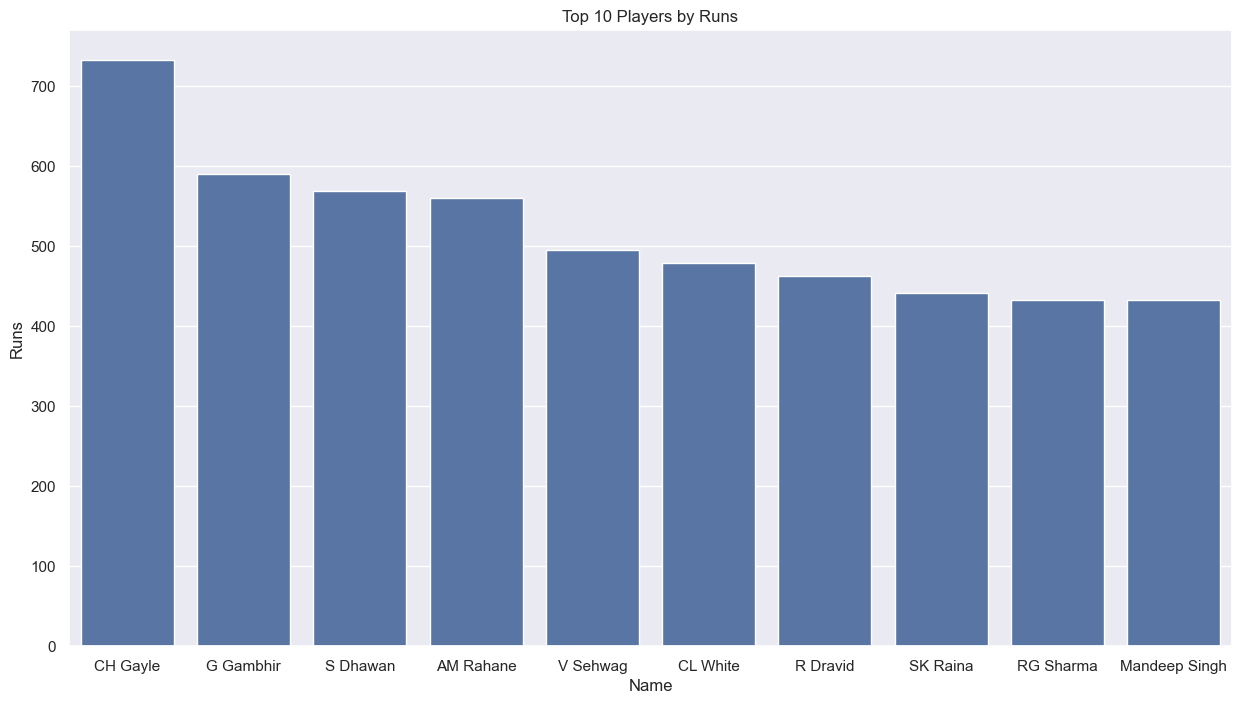

In [182]:
plt.figure(figsize=(15,8))
b1=bb.groupby('Name')['Runs'].sum().sort_values(ascending = False ).head(10)
b1= b1.reset_index() 
b1.columns = ['Name' ,'Runs']
sns.barplot(data= b1 , x= 'Name' , y ='Runs');
plt.title("Top 10 Players by Runs");

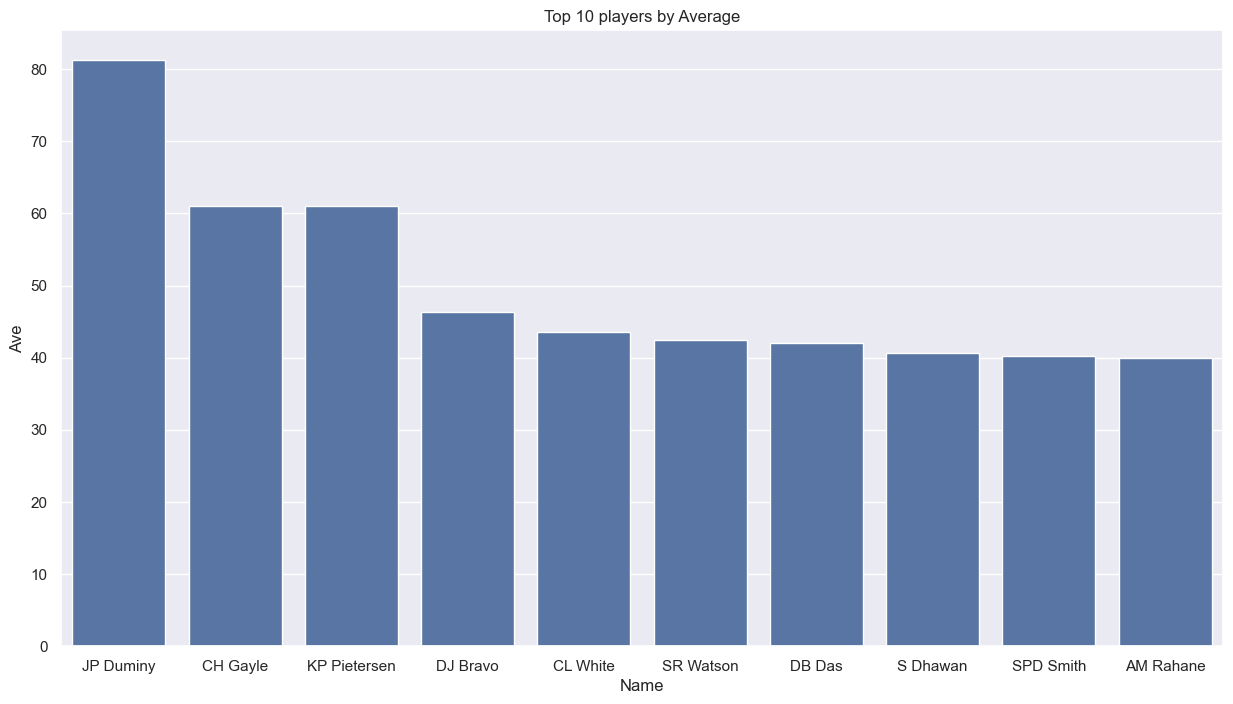

In [183]:
plt.figure(figsize=(15,8))
b1=bb.groupby('Name')['Ave'].sum().sort_values(ascending = False ).head(10)
b1= b1.reset_index() 
b1.columns = ['Name' ,'Ave']
sns.barplot(data= b1 , x= 'Name' , y ='Ave')
plt.title("Top 10 players by Average");

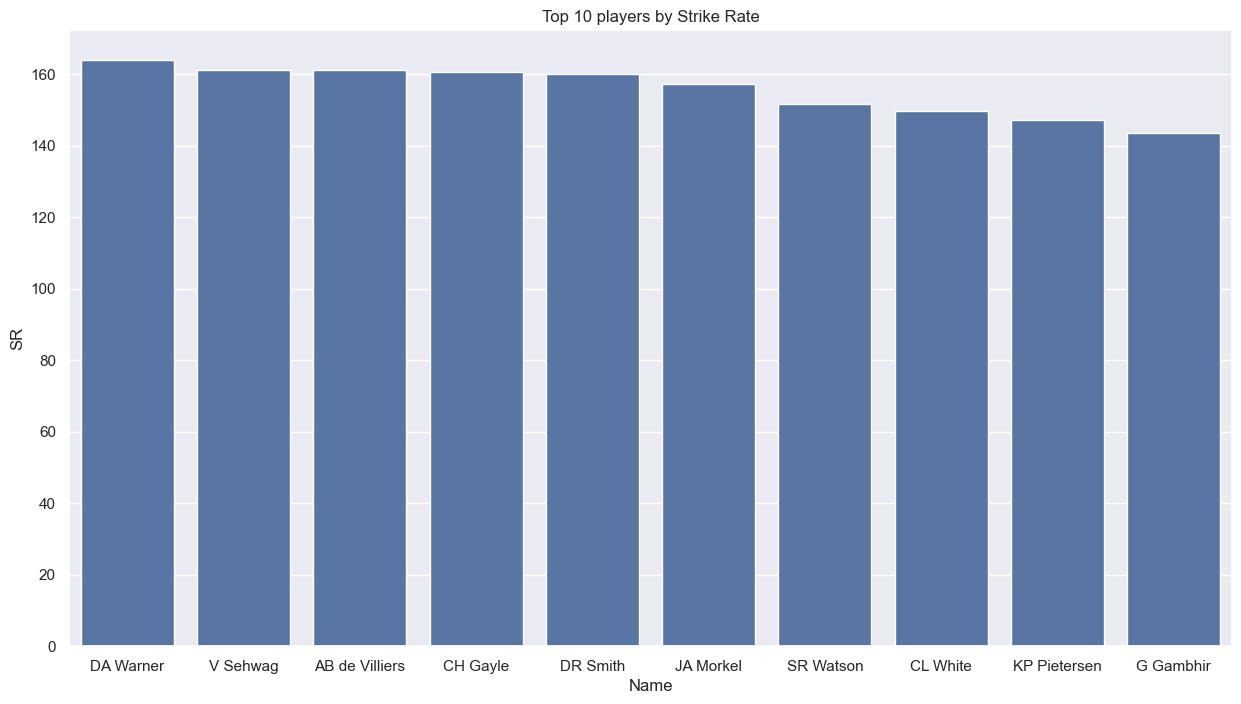

In [184]:
plt.figure(figsize=(15,8))
b1=bb.groupby('Name')['SR'].sum().sort_values(ascending = False ).head(10)
b1= b1.reset_index() 
b1.columns = ['Name' ,'SR']
sns.barplot(data= b1 , x= 'Name' , y ='SR')
plt.title("Top 10 players by Strike Rate");

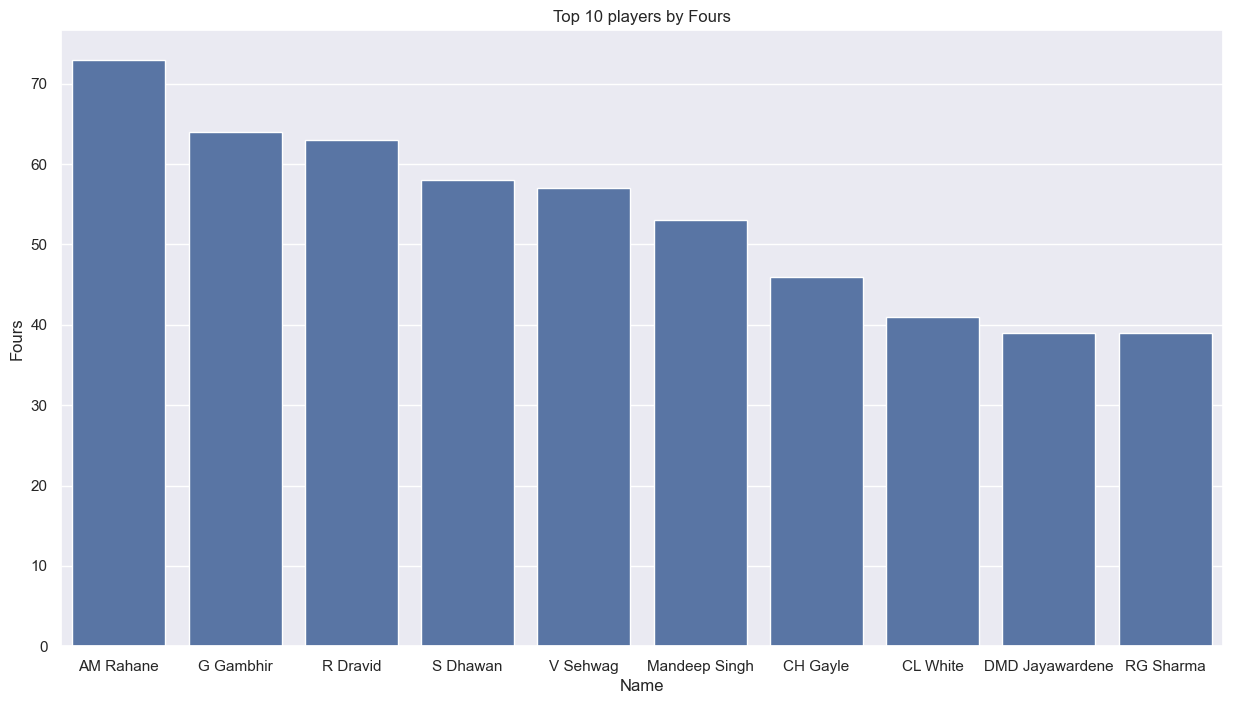

In [185]:
plt.figure(figsize=(15,8))
b1=bb.groupby('Name')['Fours'].sum().sort_values(ascending = False ).head(10)
b1= b1.reset_index() 
b1.columns = ['Name' ,'Fours']
sns.barplot(data= b1 , x= 'Name' , y ='Fours')
plt.title("Top 10 players by Fours");

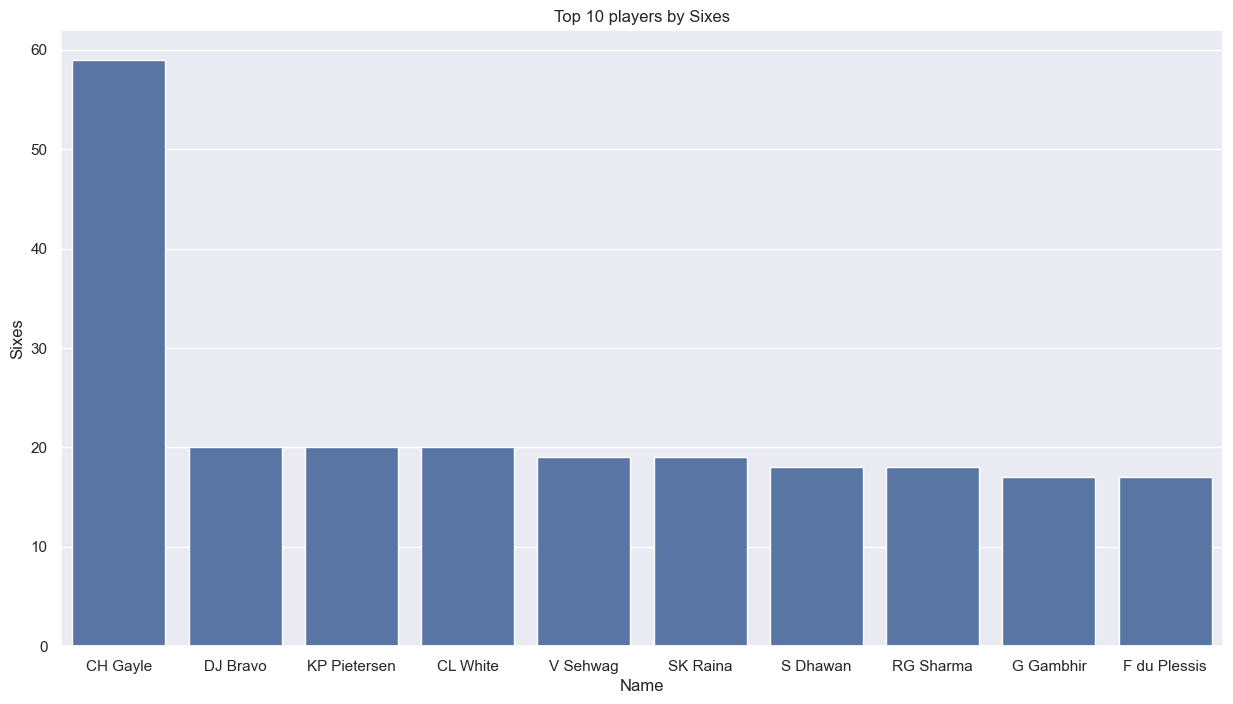

In [186]:
plt.figure(figsize=(15,8))
b1=bb.groupby('Name')['Sixes'].sum().sort_values(ascending = False ).head(10)
b1= b1.reset_index() 
b1.columns = ['Name' ,'Sixes']
sns.barplot(data= b1 , x= 'Name' , y ='Sixes')
plt.title("Top 10 players by Sixes");

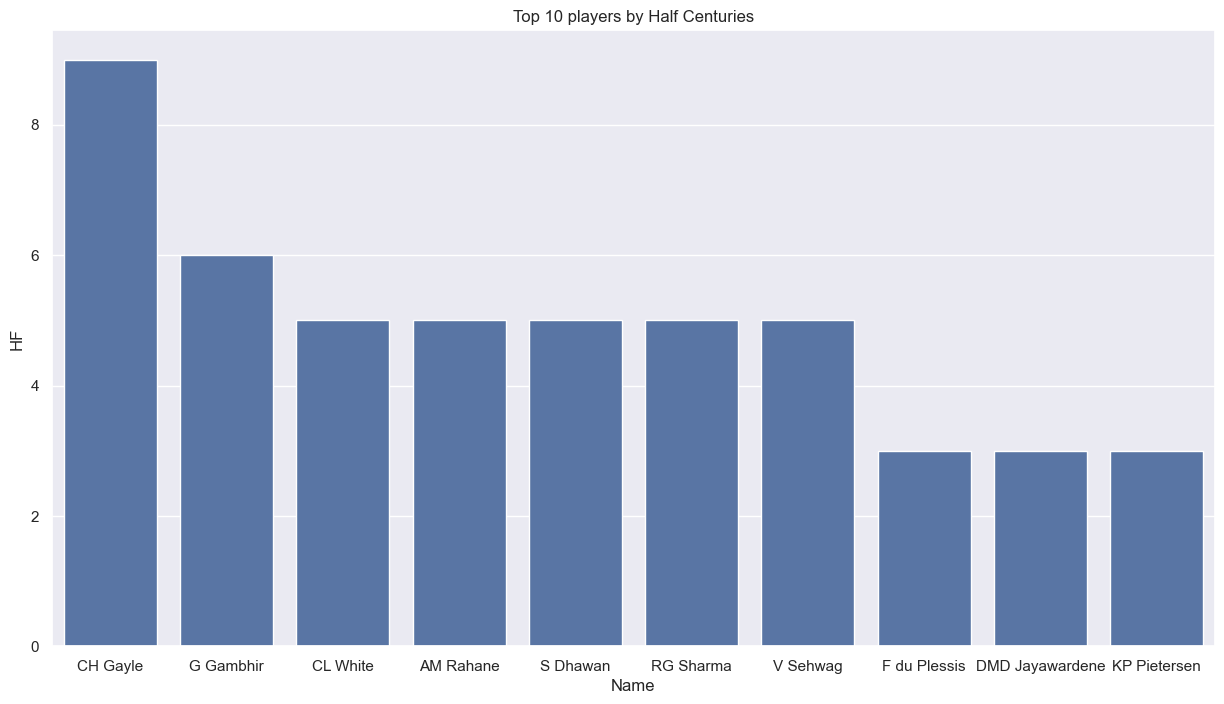

In [187]:
plt.figure(figsize=(15,8))
b1=bb.groupby('Name')['HF'].sum().sort_values(ascending = False ).head(10)
b1= b1.reset_index() 
b1.columns = ['Name' ,'HF']
sns.barplot(data= b1 , x= 'Name' , y ='HF')
plt.title("Top 10 players by Half Centuries");

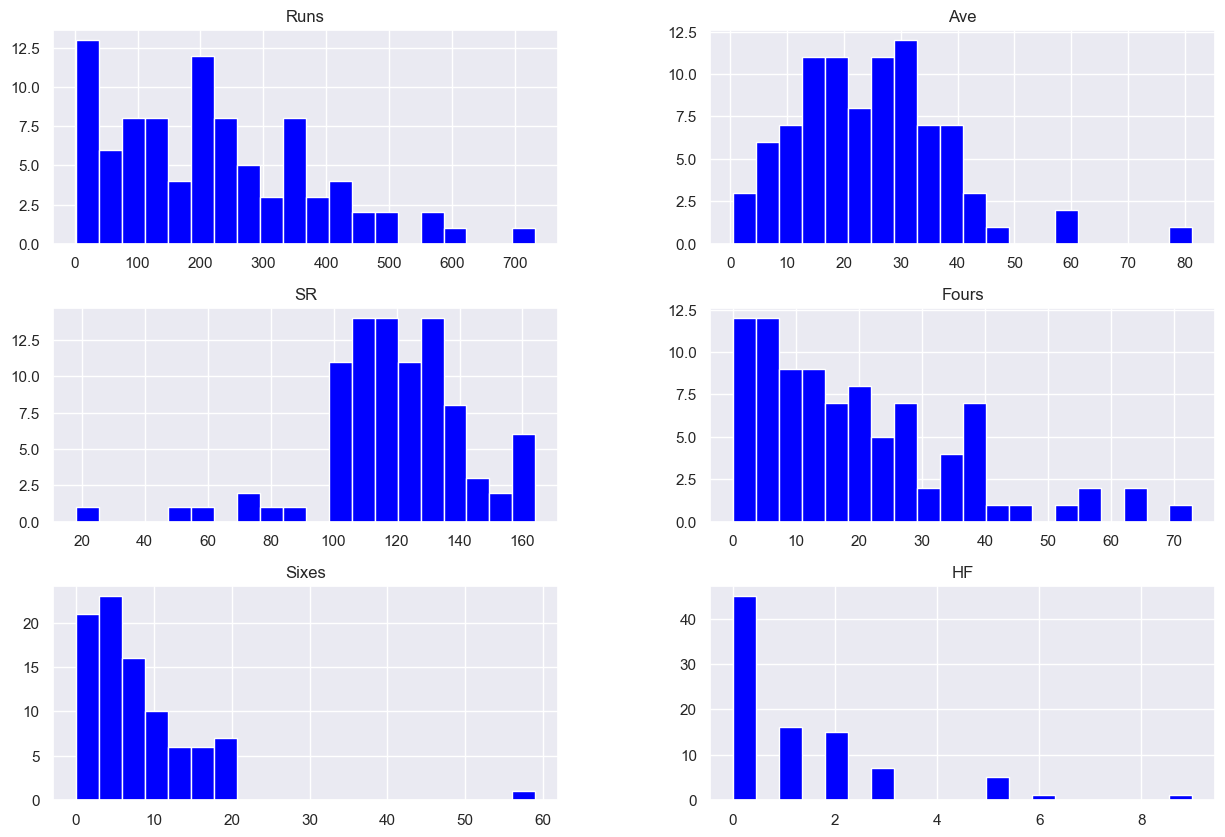

In [188]:
bb.hist(bins = 20, figsize = (15, 10), color = 'blue')
plt.show()

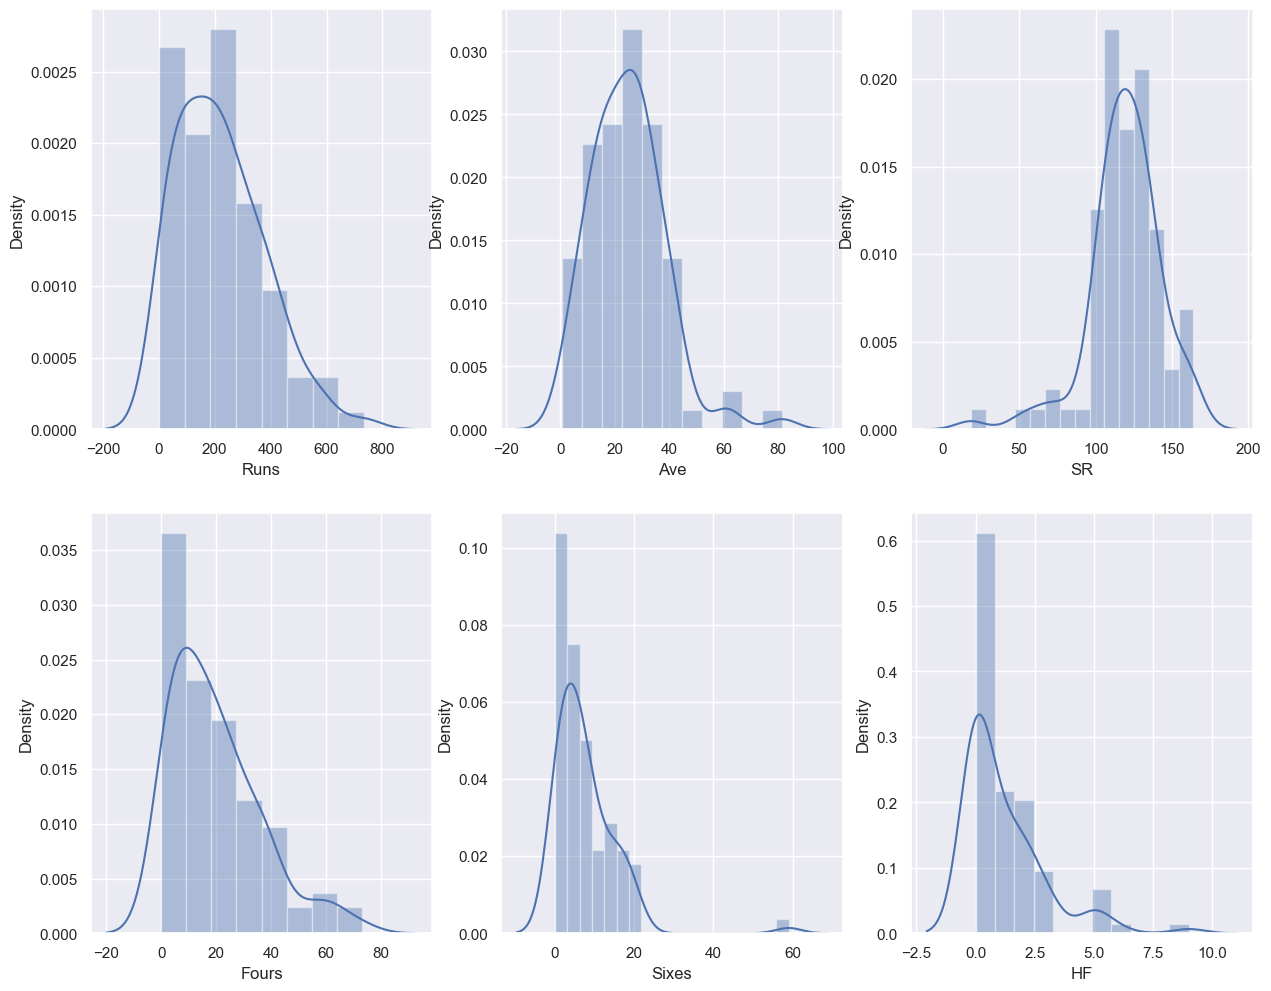

In [189]:
plt.figure(figsize=(15, 12))
col = 1
for i in bb.drop(columns='Name').columns:
    plt.subplot(2, 3, col)
    sns.distplot(bb[i], color = 'b')
    col += 1 

Strike rate, fours, sixes and half centuries have a skewed distribution

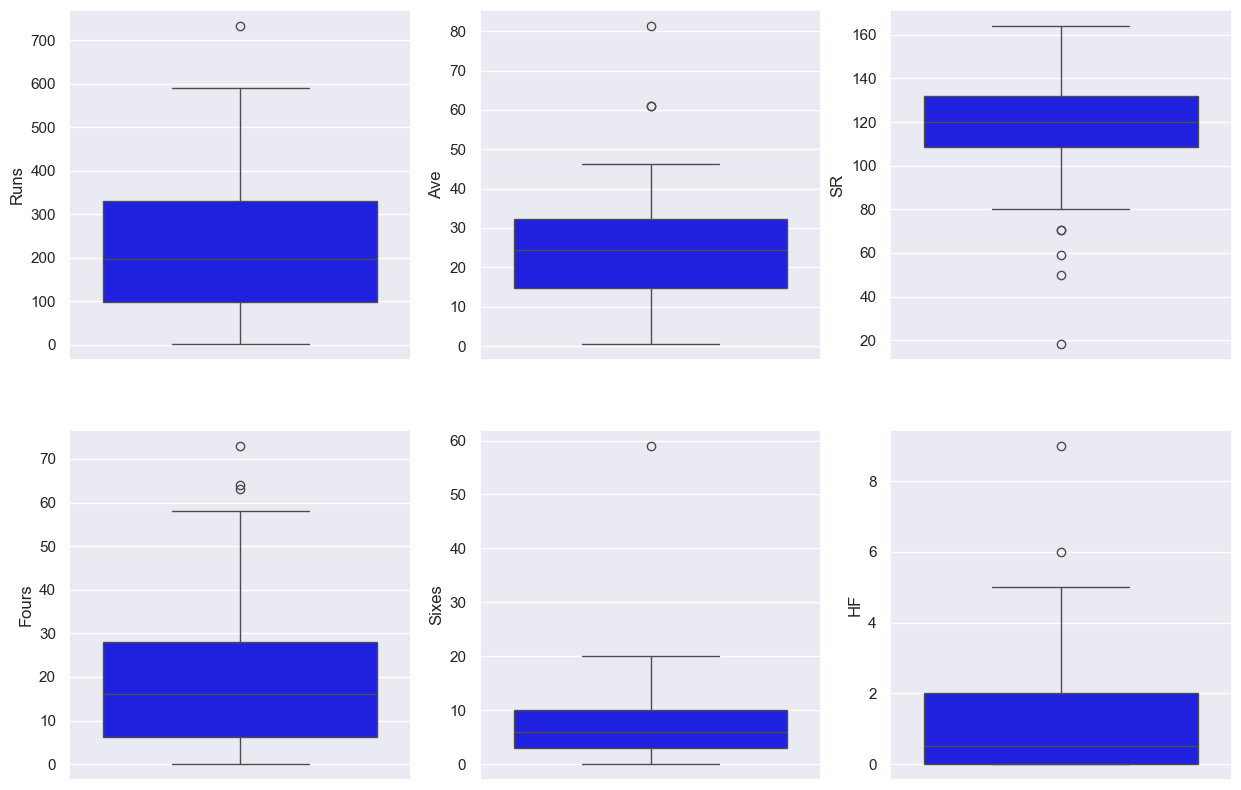

In [191]:
plt.figure(figsize=(15, 10))
col = 1
for i in bb.drop(columns='Name').columns:
    plt.subplot(2, 3, col)
    sns.boxplot(bb[i],color='blue')
    col += 1

There appears to be outliers, will not be treating them as its highly likely that these are genuine observation

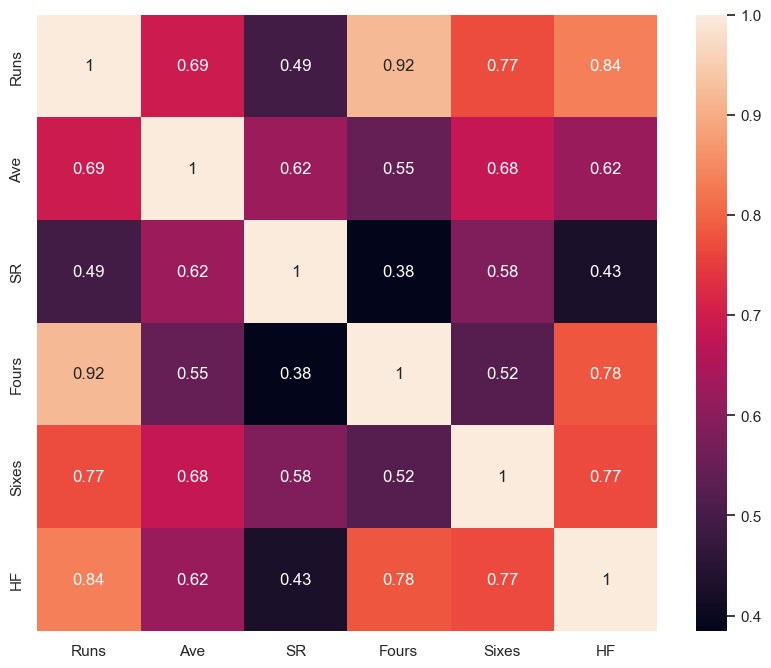

In [193]:
#checking for correlation
plt.figure(figsize=(10,8))
corr=bb.drop(columns='Name').corr()
sns.heatmap(corr,annot=True);

All the variable except fours with strike rate, strike rate with half centuries,strike rate with runs, have high correlation

In [195]:
#scaling the numeric variables
cc = bb.iloc[:,1:7] 
cc1 = cc.apply(zscore)
cc1.head()

Runs       Ave        SR     Fours     Sixes        HF
1  3.301945  2.683984  1.767325  1.607207  6.462679  4.651551
3  2.381639  0.896390  1.036605  2.710928  1.184173  2.865038
5  1.770248  0.610640  1.788154  2.281703  1.435530  2.269533
7  1.667276  1.388883  1.297182  1.300618  1.561209  2.269533
9  2.246490  1.174755  0.444038  2.343021  1.309851  2.269533

In [196]:
#checking for the within sum of squares
wss =[] 
for i in range(1,6):
    KM = KMeans(n_clusters=i)
    KM.fit(cc1)
    wss.append(KM.inertia_)
wss

[540.0,
 296.2613535473202,
 223.36518460916955,
 192.84095366191792,
 145.40761145887325]

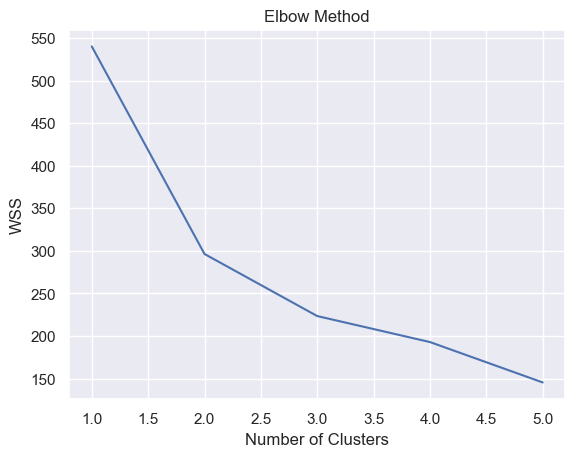

In [197]:
#plotting to check for optimal clustres 
plt.plot(range(1,6), wss);
plt.title('Elbow Method');
plt.xlabel("Number of Clusters")
plt.ylabel("WSS");

In [198]:
#using 2 centroids
k_means = KMeans(n_clusters = 2)
k_means.fit(cc1)
labels = k_means.labels_

In [199]:
# Calculating silhouette_score
silhouette_score(cc1,labels)

0.41111085574076756

In [200]:
#plotting silhouette score for different centroids
kmeans_kwargs = {
   "init": "random",
   "n_init": 10,
   "max_iter": 300,
   "random_state": 42,
}
silhouette_coefficients = []
# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 6):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(cc1)
    score = silhouette_score(cc1,kmeans.labels_)
    silhouette_coefficients.append(score)

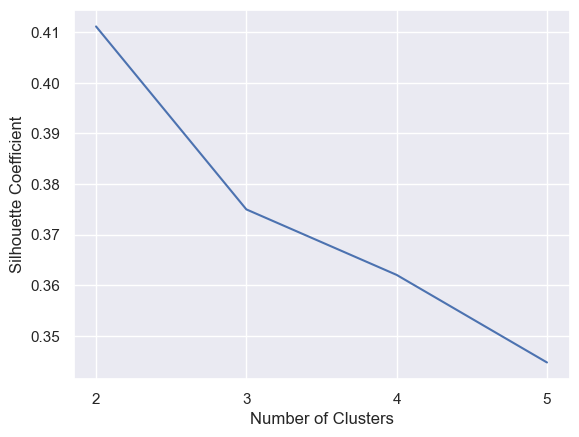

In [201]:
plt.plot(range(2,6), silhouette_coefficients)
plt.xticks(range(2, 6))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [202]:
#attaching the labels to the original data
bb['cluster']=labels
bb.head()

Name   Runs    Ave      SR  Fours  Sixes   HF  cluster
1   CH Gayle  733.0  61.08  160.74   46.0   59.0  9.0        1
3  G Gambhir  590.0  36.87  143.55   64.0   17.0  6.0        1
5   V Sehwag  495.0  33.00  161.23   57.0   19.0  5.0        1
7   CL White  479.0  43.54  149.68   41.0   20.0  5.0        1
9   S Dhawan  569.0  40.64  129.61   58.0   18.0  5.0        1

In [203]:
#veiwing the distribution of the clusters
bb.cluster.value_counts().sort_index()

cluster
0    55
1    35
Name: count, dtype: int64

In [205]:
# Select only numeric columns (we'll skip the ones that are not numbers)
numeric_cols = bb.select_dtypes(include='number').columns

# Now group by 'cluster' and calculate the mean only for numeric data
aggdata = bb.groupby('cluster')[numeric_cols].mean()

# Add the frequency of each cluster
aggdata['Freq'] = bb['cluster'].value_counts().sort_index()

# aggregated data.
aggdata

Runs        Ave          SR      Fours      Sixes        HF  \
cluster                                                                      
0        122.745455  17.582000  110.481455  10.309091   3.636364  0.218182   
1        372.657143  35.962286  132.808286  34.685714  13.771429  2.714286   

         cluster  Freq  
cluster                 
0            0.0    55  
1            1.0    35

In [207]:
#based on the above table renaming/ranking the playes in Grade A and Grade B
bb['cluster'] = bb['cluster'].replace({1: 'Grade A', 0: 'Grade B'})

In [209]:
#list of Grade A players
Grade_A = bb[bb['cluster'] == 'Grade A']
Grade_A.head(10)

Name   Runs    Ave      SR  Fours  Sixes   HF  cluster
1         CH Gayle  733.0  61.08  160.74   46.0   59.0  9.0  Grade A
3        G Gambhir  590.0  36.87  143.55   64.0   17.0  6.0  Grade A
5         V Sehwag  495.0  33.00  161.23   57.0   19.0  5.0  Grade A
7         CL White  479.0  43.54  149.68   41.0   20.0  5.0  Grade A
9         S Dhawan  569.0  40.64  129.61   58.0   18.0  5.0  Grade A
11       AM Rahane  560.0  40.00  129.33   73.0   10.0  5.0  Grade A
13    KP Pietersen  305.0  61.00  147.34   22.0   20.0  3.0  Grade A
15       RG Sharma  433.0  30.92  126.60   39.0   18.0  5.0  Grade A
17  AB de Villiers  319.0  39.87  161.11   26.0   15.0  3.0  Grade A
19       JP Duminy  244.0  81.33  128.42   13.0   11.0  2.0  Grade A

In [211]:
#list of Grade B players
Grade_B = bb[bb['cluster'] == 'Grade B']
Grade_B.head()

Name   Runs    Ave      SR  Fours  Sixes   HF  cluster
69      MS Bisla  213.0  30.42  133.12   16.0   10.0  1.0  Grade B
73      BJ Hodge  245.0  30.62  140.00   18.0    9.0  0.0  Grade B
75       NV Ojha  255.0  23.18  113.83   21.0   13.0  1.0  Grade B
77        DB Das  126.0  42.00  135.48    9.0    6.0  0.0  Grade B
79  AC Gilchrist  172.0  34.40  120.27   21.0    4.0  1.0  Grade B

## PART-5


## List of all Possible Dimensionality Techniques and when to use them
### Dimensionality reduction techniques can be classified into two 3 types
### Feature selection: <br/>
a) Missing Value Ratio: If the dataset has too many missing values, we use this approach to reduce the number of variables. We can drop the variables having a large number of missing values in them. <br/>
b) Low Variance filter: We apply this approach to identify and drop constant variables from the dataset. The target variable is not unduly affected by variables with low variance, and hence these variables can be safely dropped. <br/>
c) High Correlation filter: A pair of variables having high correlation increases multicollinearity in the dataset. So, we can use this technique to find highly correlated features and drop them accordingly. <br/>
d) Random Forest: This is one of the most commonly used techniques which tells us the importance of each feature present in the dataset. We can find the importance of each feature and keep the top most features, resulting in dimensionality reduction. <br/>
e) Both Backward Feature Elimination and Forward Feature Selection techniques take a lot of computational time and are thus  generally used on smaller datasets. <br/>
### Components / Factor Based: <br/>
a) Factor Analysis: This technique is best suited for situations where we have highly correlated set of variables. It divides the variables based on their correlation into different groups, and represents each group with a factor. <br/>
b) Principal Component Analysis: This is one of the most widely used techniques for dealing with linear data. It divides the data into a set of components which try to explain as much variance as possible. <br/>
c) Independent Component Analysis: We can use ICA to transform the data into independent components which describe the data using less number of components. <br/>
### Projection Based: <br/>
a) ISOMAP: We use this technique when the data is strongly non-linear. <br/>
b) t-SNE: This technique also works well when the data is strongly non-linear. It works extremely well for visualizations as well. <br/>
c) UMAP: This technique works well for high dimensional data. Its run-time is shorter as compared to t-SNE. <br/>


### Application: Exploring Handwritten Digits


In [215]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.images.shape

(1797, 8, 8)

The images data is a three-dimensional array: 1,797 samples, each consisting of an
8×8 grid of pixels.

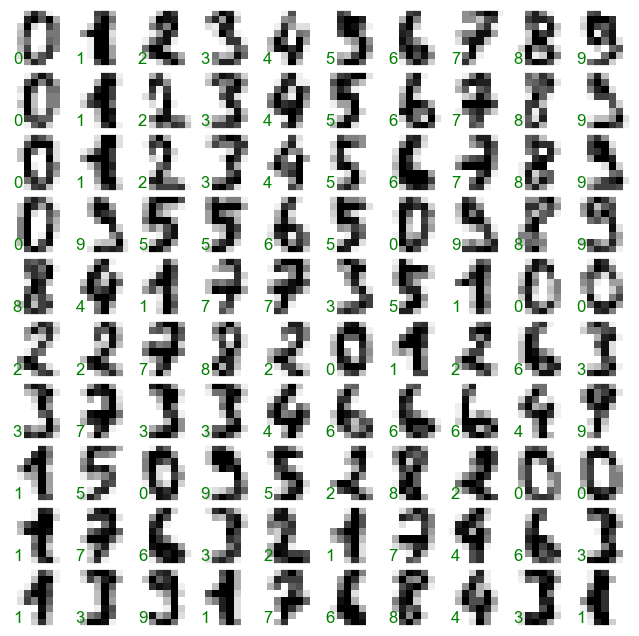

In [218]:
# visualize the first hundred of these
import matplotlib.pyplot as plt
fig, axes = plt.subplots(10, 10, figsize=(8, 8),
subplot_kw={'xticks':[], 'yticks':[]},
gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i,ax in enumerate(axes.flat):
    ax.imshow(digits.images[i], cmap='binary', interpolation='nearest')
    ax.text(0.05, 0.05, str(digits.target[i]),
    transform=ax.transAxes, color='green')

In [219]:
#two-dimensional,[n_samples, n_features] representation
X = digits.data
X.shape

(1797, 64)

In [220]:
y = digits.target
y.shape

(1797,)

 1,797 samples and 64 features.

In [222]:
#transform the data to two dimensions using manifold learning algorithm called Isomap
from sklearn.manifold import Isomap
iso = Isomap(n_components=2)
iso.fit(digits.data)
data_projected = iso.transform(digits.data)
data_projected.shape

(1797, 2)

 The projected data is now two-dimensional

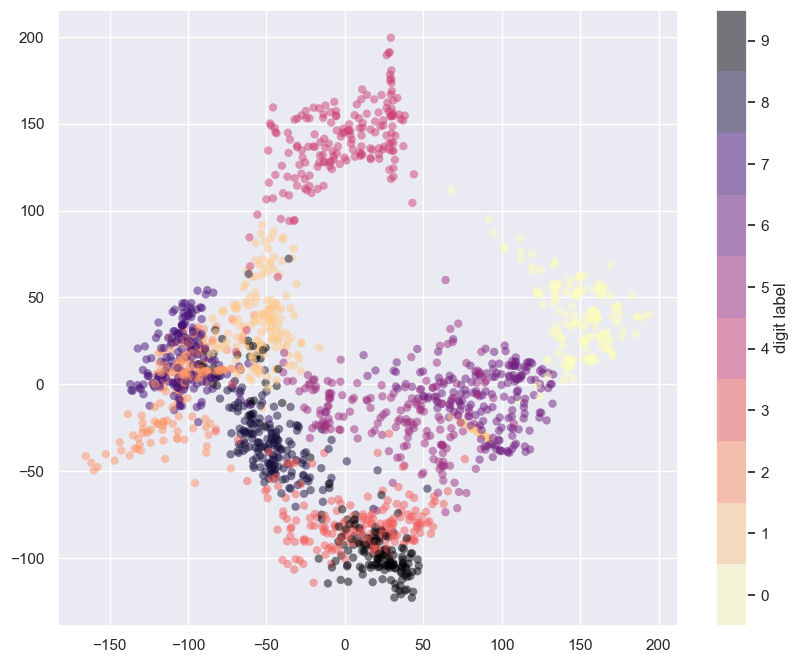

In [227]:
# plot this data to see if we can learn anything from its structure 
plt.figure(figsize=(10, 8))
plt.scatter(data_projected[:, 0], data_projected[:, 1], c=digits.target,edgecolor='none', alpha=0.5,cmap=plt.cm.get_cmap('magma_r', 10))
plt.colorbar(label='digit label', ticks=range(10))
plt.clim(-0.5, 9.5);

In [228]:
from sklearn.model_selection import train_test_split
 # Split X and y into training and test set in 70:30 ratio

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=15)

In [229]:
#fit a Gaussian naive Bayes model
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X_train, y_train)
pred = model.predict(X_test)

In [230]:
# gauge its accuracy by comparing the true values of the test set to the predictions
from sklearn.metrics import accuracy_score
accuracy_score(y_test, pred)

0.8407407407407408

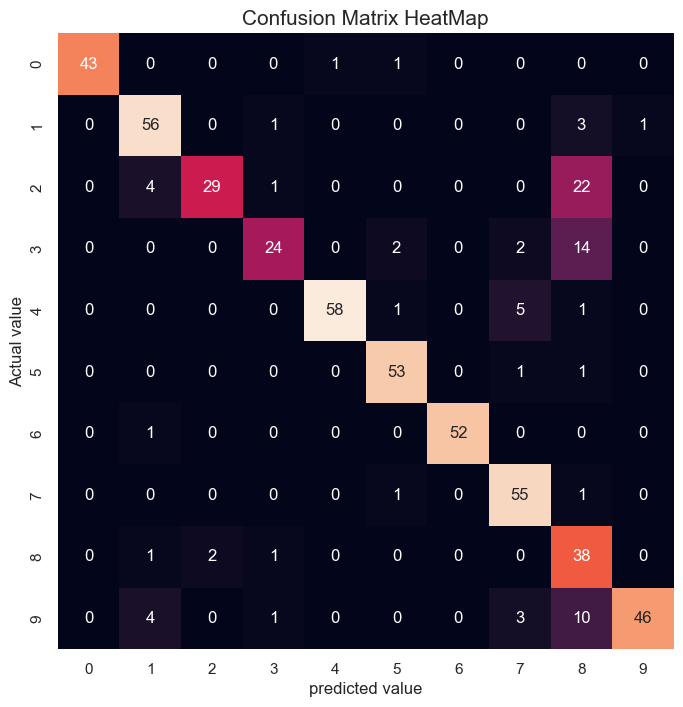

In [231]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
%matplotlib inline 
sns.set(color_codes=True)
#visualization of confusion matrix in the form of a heatmap
plt.figure(figsize = (12, 8))
mat = confusion_matrix(y_test, pred)
sns.heatmap(mat, square=True, annot=True, cbar=False)
plt.xlabel('predicted value')
plt.ylabel('Actual value');
plt.title('Confusion Matrix HeatMap', fontsize = 15);

This shows us where the mislabeled points tend to be: for example, a large number of
twos here are misclassified as either ones or eights

Another way to gain intuition into
the characteristics of the model is to plot the inputs again, with their predicted labels.
We’ll use green for correct labels, and red for incorrect labels

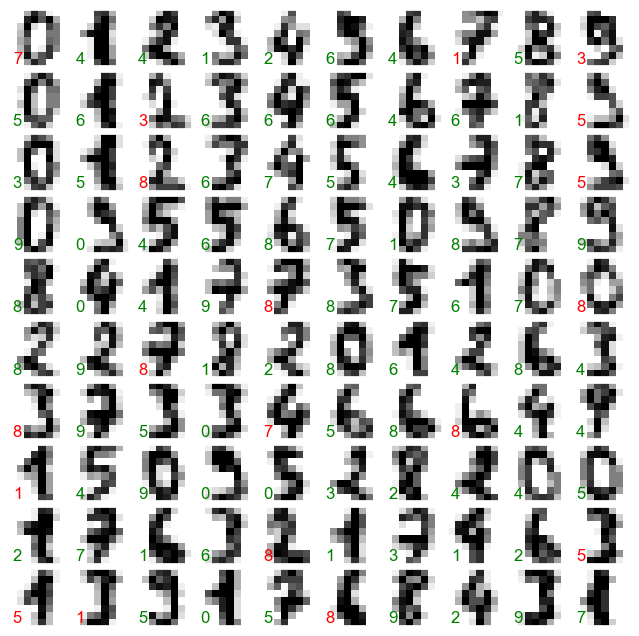

In [235]:
fig, axes = plt.subplots(10, 10, figsize=(8, 8),
 subplot_kw={'xticks':[], 'yticks':[]},
 gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i, ax in enumerate(axes.flat):
    ax.imshow(digits.images[i], cmap='binary', interpolation='nearest')
    ax.text(0.05, 0.05, str(pred[i]),
    transform=ax.transAxes,
    color='green' if (y_test[i] == pred[i]) else 'red')